# Eye-Tracking Data Analysis for PLR Tests
This notebook implements analysis of Pupillary Light Reflex (PLR) tests using eye-tracking data.
The analysis includes data cleaning, pupil size extraction, signal quality assessment, and biomarker calculation.

In [1]:
# Import required libraries

# pandas - For data manipulation and analysis of tabular data (landmarks and protocol files)
import pandas as pd

# numpy - For numerical operations and array manipulation of pupil measurements
import numpy as np

# matplotlib - For creating static visualizations of pupil response data
import matplotlib.pyplot as plt

# pathlib - For cross-platform file path handling
from pathlib import Path

# logging - For tracking program execution and debugging information
import logging

# scipy.signal - For signal processing operations like Savitzky-Golay filtering
from scipy import signal

# seaborn - For enhanced statistical data visualization built on matplotlib
import seaborn as sns

# shapely.geometry - For polygon area calculation
from shapely.geometry import Polygon

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

## Data Loading Functions
Functions to load and validate landmarks and protocol files

In [2]:
def load_landmarks_file(file_path):
    """
    Load and validate landmarks data file
    
    Args:
        file_path (str): Path to landmarks CSV file
        
    Returns:
        pd.DataFrame: Processed landmarks data
    """
    try:
        df = pd.read_csv(file_path)
        
        # Required columns for timestamp and status
        base_columns = ['timestamp', 'id', 'retcode']
        
        # Generate expected landmark column names for both eyes
        landmark_columns = []
        for eye in ['left', 'right']:
            for i in range(1, 28):  # 27 landmarks per eye
                landmark_columns.extend([
                    f'{eye}_lm_{i}_x',
                    f'{eye}_lm_{i}_y'
                ])
        
        required_columns = base_columns + landmark_columns
        
        # Verify all required columns exist
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {', '.join(missing_columns)}")
            
        logger.info(f"Successfully validated landmarks file {file_path.name} with {len(df)} rows")
        return df
    except Exception as e:
        logger.error(f"Error loading landmarks file: {e}")
        raise

In [3]:
def load_protocol_file(file_path):
    """
    Load and validate protocol data file
    
    Args:
        file_path (str): Path to protocol CSV file
        
    Returns:
        pd.DataFrame: Protocol timing data
    """
    try:
        df = pd.read_csv(file_path)
        required_columns = ['time', 'event']
        if not all(col in df.columns for col in required_columns):
            raise ValueError("Missing required columns in protocol file")
        return df
    except Exception as e:
        logger.error(f"Error loading protocol file: {e}")
        raise

In [4]:
data_path = Path().cwd().parent / "data"
for subfolder in data_path.iterdir():
    if subfolder.is_dir():
        landmarks_file = subfolder / f'{subfolder.name}_plr_landmarks.csv'
        protocol_file = subfolder / f'{subfolder.name}_plr_protocol.csv'
        
        # Load landmarks and protocol files
        landmarks_df = load_landmarks_file(landmarks_file)
        protocol_df = load_protocol_file(protocol_file)

2025-04-13 15:45:53,030 - INFO - Successfully validated landmarks file 60f931f1-b263-4947-80e6-18869129b673_plr_landmarks.csv with 267 rows


2025-04-13 15:45:53,040 - INFO - Successfully validated landmarks file 51d6b22d-383b-45b8-b606-96021b625e46_plr_landmarks.csv with 237 rows
2025-04-13 15:45:53,055 - INFO - Successfully validated landmarks file 63fc1ae2-f2bc-4115-a8e7-532e85f27244_plr_landmarks.csv with 268 rows
2025-04-13 15:45:53,055 - INFO - Successfully validated landmarks file 63fc1ae2-f2bc-4115-a8e7-532e85f27244_plr_landmarks.csv with 268 rows
2025-04-13 15:45:53,074 - INFO - Successfully validated landmarks file 54423378-0c67-4fb7-b08b-bef45eef2397_plr_landmarks.csv with 241 rows
2025-04-13 15:45:53,074 - INFO - Successfully validated landmarks file 54423378-0c67-4fb7-b08b-bef45eef2397_plr_landmarks.csv with 241 rows
2025-04-13 15:45:53,093 - INFO - Successfully validated landmarks file 42df01c6-0846-4735-9693-5356505c17da_plr_landmarks.csv with 271 rows
2025-04-13 15:45:53,106 - INFO - Successfully validated landmarks file 5911b4f1-885e-4f7a-bf71-f51efe13fd16_plr_landmarks.csv with 267 rows
2025-04-13 15:45:53,

## Data Cleaning
Functions to clean and preprocess the landmarks data

In [26]:
def filter_ok_landmarks_data(df):
    """
    Clean landmarks data by removing invalid frames
    
    Args:
        df (pd.DataFrame): Raw landmarks data
        
    Returns:
        pd.DataFrame: Cleaned landmarks data
    """
    # Remove frames with invalid retCode
    cleaned_df = df[df['retcode'] == 'OK'].copy()
    
    # Reset index after filtering
    cleaned_df.reset_index(drop=True, inplace=True)
    
    logger.info(f"Removed {len(df) - len(cleaned_df)} frames with invalid retCode")
    return cleaned_df

In [40]:
# Find the landmarks.csv file
landmarks_file = list(data_path.glob('**/*landmarks.csv'))

In [41]:
first_plr_file = landmarks_file[1]

# Load landmarks data into DataFrame
landmarks_df = pd.read_csv(first_plr_file)

# Display first few rows
landmarks_df  # Added .head() to display first few rows

Unnamed: 0                timestamp    id        retcode  left_lm_1_x  \
0             0  2024-08-08 03:36:14.477  1650             OK        178.0   
1             1  2024-08-08 03:36:14.514  1651             OK        182.2   
2             2  2024-08-08 03:36:14.548  1652             OK        175.8   
3             3  2024-08-08 03:36:14.580  1653             OK        173.5   
4             4  2024-08-08 03:36:14.609  1654             OK        171.5   
..          ...                      ...   ...            ...          ...   
232         232  2024-08-08 03:36:22.345  1882  NO_FACE_FOUND          0.0   
233         233  2024-08-08 03:36:22.382  1883             OK        563.2   
234         234  2024-08-08 03:36:22.421  1884             OK        543.8   
235         235  2024-08-08 03:36:22.455  1885             OK        470.5   
236         236  2024-08-08 03:36:22.489  1886             OK        352.8   

     left_lm_1_y  left_lm_2_x  left_lm_2_y  left_lm_3_x  left_lm_3_y  ...  \
0          507.5        234.0        465.2        272.0        458.8  ...   
1          508.2        236.8        466.0        275.5        459.5  ...   
2          509.8        231.5        468.0        271.2        461.2  ...   
3          510.0        229.2        467.5        268.2        461.0  ...   
4          511.0        226.8        469.5        265.8        463.8  ...   
..           ...          ...          ...          ...          ...  ...   
232          0.0          0.0          0.0          0.0          0.0  ...   
233        571.5        596.8        528.0        621.8        520.5  ...   
234        577.8        576.8        550.2        602.0        545.2  ...   
235        567.8        504.2        536.5        532.8        532.2  ...   
236        712.2        387.8        672.2        415.0        665.0  ...   

     right_lm_23_x  right_lm_23_y  right_lm_24_x  right_lm_24_y  \
0            792.0          461.8          756.5          461.8   
1            792.0          464.5          762.0          464.8   
2            788.0          468.5          757.8          468.8   
3            781.2          469.8          757.8          469.8   
4            779.2          472.2          756.0          472.5   
..             ...            ...            ...            ...   
232            0.0            0.0            0.0            0.0   
233          960.2          559.8          943.5          560.0   
234          966.5          558.0          952.0          558.0   
235          912.8          549.5          898.5          550.0   
236          800.2          679.0          784.0          679.5   

     right_lm_25_x  right_lm_25_y  right_lm_26_x  right_lm_26_y  \
0            757.0          481.2          844.5          458.2   
1            762.0          481.2          847.8          461.5   
2            757.8          485.2          846.2          461.8   
3            757.8          482.5          843.0          463.5   
4            756.0          486.2          838.5          463.2   
..             ...            ...            ...            ...   
232            0.0            0.0            0.0            0.0   
233          944.5          572.8         1004.5          561.2   
234          952.0          566.5         1001.5          555.5   
235          898.5          558.8          958.8          543.8   
236          783.8          690.2          849.0          675.2   

     right_lm_27_x  right_lm_27_y  
0            886.5          487.8  
1            887.0          490.8  
2            885.0          491.8  
3            880.8          491.0  
4            874.8          490.2  
..             ...            ...  
232            0.0            0.0  
233         1037.0          577.5  
234         1023.0          577.2  
235          985.0          561.5  
236          874.5          698.2  

[237 rows x 112 columns]

In [42]:
landmarks_df_cleaned = filter_ok_landmarks_data(landmarks_df)

2025-04-13 16:20:54,255 - INFO - Removed 1 frames with invalid retCode


In [43]:
numerical_cols = landmarks_df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [44]:
exclude_cols = ['Unnamed: 0', 'id']
landmark_cols = [col for col in numerical_cols if col not in exclude_cols]
landmark_cols[:5]

['left_lm_1_x', 'left_lm_1_y', 'left_lm_2_x', 'left_lm_2_y', 'left_lm_3_x']

In [34]:
mean_val = landmarks_df_cleaned['left_lm_5_x'].mean()
mean_val

np.float64(342.68728813559323)

In [35]:
std_val = landmarks_df_cleaned['left_lm_5_x'].std()
std_val

np.float64(44.11845861895414)

In [36]:
threshold = 3
lower_bound = mean_val - threshold * std_val
upper_bound = mean_val + threshold * std_val

outliers = landmarks_df_cleaned[(landmarks_df_cleaned['left_lm_5_x'] < lower_bound) | (landmarks_df_cleaned['left_lm_5_x'] > upper_bound)].index.tolist()
outliers

[230, 231, 232, 233, 234, 235]

In [37]:
landmarks_file[0]

PosixPath('/home/lrn/Repos/analyze-eye-tracking-data/data/60f931f1-b263-4947-80e6-18869129b673/60f931f1-b263-4947-80e6-18869129b673_plr_landmarks.csv')

In [ ]:
landmarks_file = list(data_path.glob('**/*landmarks.csv'))

landmarks_df_list = []
landmarks_df_list_cleaned = []

for i, f in enumerate(landmarks_file):
    df = pd.read_csv(f)
    landmarks_df_list.append(df)
    landmarks_df_list_cleaned.append(filter_ok_landmarks_data(df))  # Updated to use df instead of landmarks_df[i]
    
    # Check for outliers in each landmark column
    logger.info(f"Checking for outliers in file: {i}")
    
    # Calculate mean and standard deviation for each landmark column
    threshold = 4
    for col in landmark_cols:
        mean_val = landmarks_df_list_cleaned[i][col].mean()
        std_val = landmarks_df_list_cleaned[i][col].std()
        lower_bound = mean_val - threshold * std_val
        upper_bound = mean_val + threshold * std_val
        
        outliers = landmarks_df_list_cleaned[i][(landmarks_df_list_cleaned[i][col] < lower_bound) | (landmarks_df_list_cleaned[i][col] > upper_bound)]
        
        if len(outliers) > 0:
            logger.info(f"Outliers detected in column {col}: {len(outliers.index.tolist())} values: {outliers[col].values.tolist()}")
            landmarks_df_list_cleaned[i].drop(index=outliers.index.tolist(), inplace=True)

/tmp/ipykernel_1216/2300756381.py:60: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  cleaned_df = cleaned_df.interpolate(method='linear', axis=0)
/tmp/ipykernel_1216/2300756381.py:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df = cleaned_df.fillna(method='ffill').fillna(method='bfill')


Total outliers detected and cleaned: 326
Number of frames with outliers: 6
Number of landmark points with outliers: 108


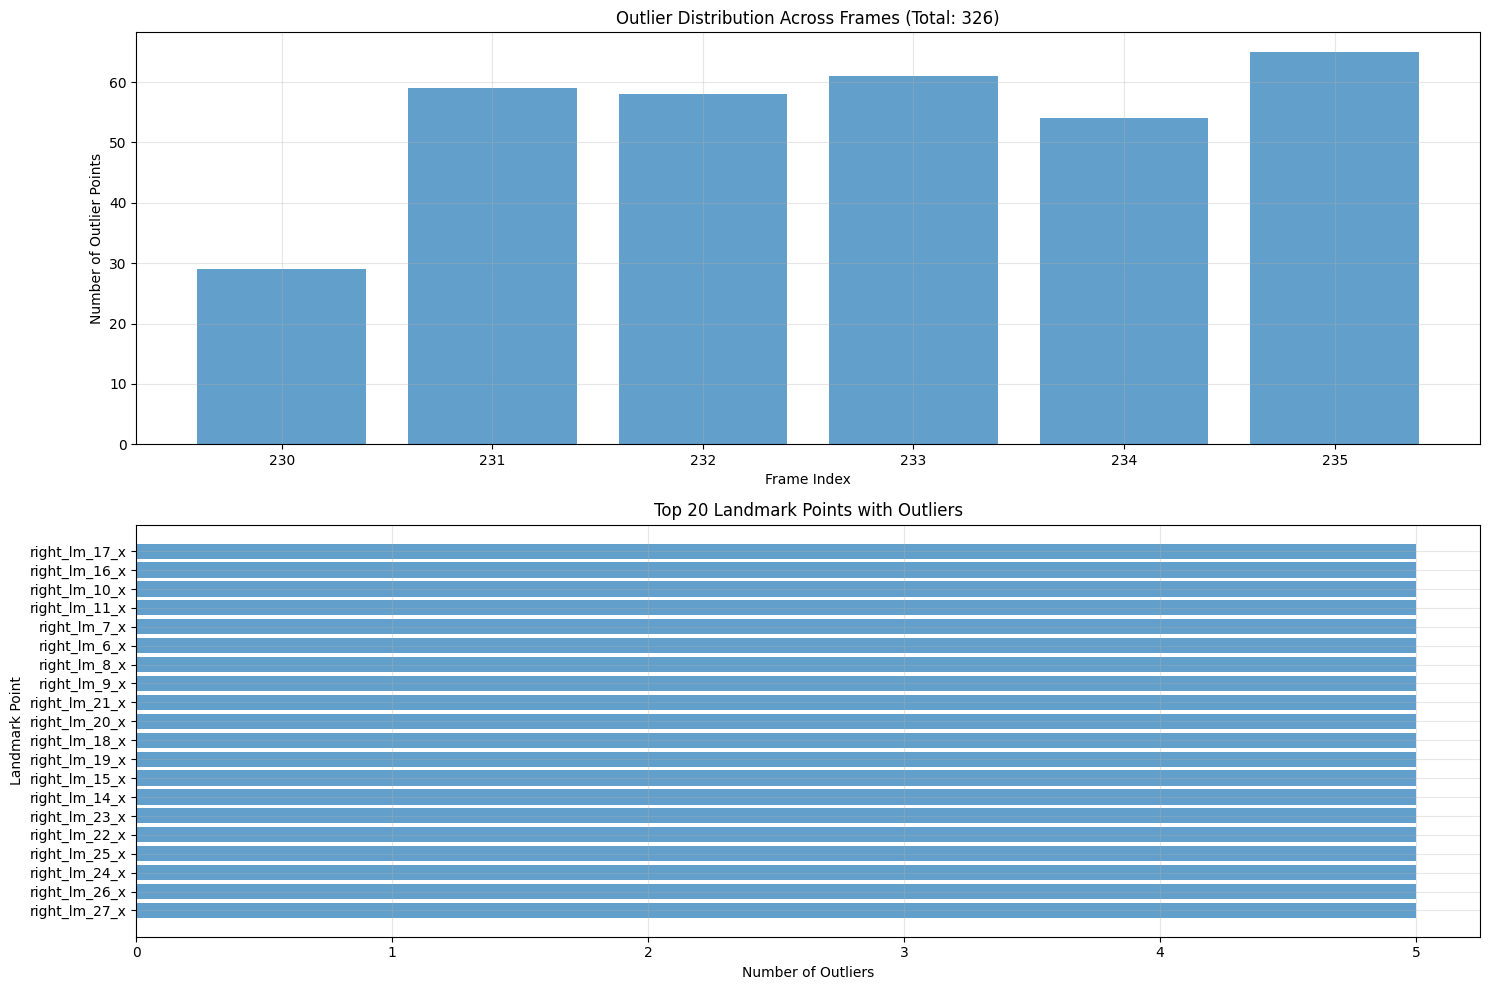

ValueError: The first and last `y` point along axis 0 must be identical (within machine precision) when bc_type='periodic'.

In [45]:
def detect_and_clean_outliers(landmarks_df, threshold=3.0):
    """
    Detect and clean outliers in the landmarks dataframe
    
    Args:
        landmarks_df (pd.DataFrame): The landmarks dataframe to clean
        threshold (float): Number of standard deviations to consider a value an outlier
        
    Returns:
        tuple: (cleaned_df, outlier_info)
    """
    # Create a copy to avoid modifying the original
    cleaned_df = landmarks_df.copy()
    
    # Keep only numerical columns for outlier detection
    numerical_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Remove non-landmark columns from analysis
    exclude_cols = ['Unnamed: 0', 'id']
    landmark_cols = [col for col in numerical_cols if col not in exclude_cols]
    
    # Create container for outlier information
    outlier_info = {
        'total_outliers': 0,
        'outliers_per_column': {},
        'outliers_per_row': {}
    }
    
    # Process each landmark column
    for col in landmark_cols:
        # Calculate mean and standard deviation
        mean_val = cleaned_df[col].mean()
        std_val = cleaned_df[col].std()
        
        # Identify outliers (values outside threshold * std from mean)
        lower_bound = mean_val - threshold * std_val
        upper_bound = mean_val + threshold * std_val
        
        outliers = cleaned_df[(cleaned_df[col] < lower_bound) | 
                             (cleaned_df[col] > upper_bound)].index.tolist()
        
        # Store outlier information for this column
        if outliers:
            outlier_count = len(outliers)
            outlier_info['total_outliers'] += outlier_count
            outlier_info['outliers_per_column'][col] = outlier_count
            
            # Track which rows have outliers
            for idx in outliers:
                if idx not in outlier_info['outliers_per_row']:
                    outlier_info['outliers_per_row'][idx] = []
                outlier_info['outliers_per_row'][idx].append(col)
            
            # Replace outliers with NaN, then interpolate
            cleaned_df.loc[outliers, col] = np.nan
    
    # Interpolate missing values if any
    if cleaned_df.isna().sum().sum() > 0:
        # Use linear interpolation to fill gaps
        cleaned_df = cleaned_df.interpolate(method='linear', axis=0)
        
        # For any remaining NaNs at edges, use forward/backward fill
        cleaned_df = cleaned_df.fillna(method='ffill').fillna(method='bfill')
    
    return cleaned_df, outlier_info

# Function to visualize outlier distribution
def plot_outlier_distribution(outlier_info, landmarks_df):
    """
    Visualize the distribution of outliers across frames and landmark points
    
    Args:
        outlier_info (dict): Dictionary with outlier information
        landmarks_df (pd.DataFrame): Original landmarks dataframe
    """
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Outliers per frame
    plt.subplot(2, 1, 1)
    frame_outliers = {idx: len(cols) for idx, cols in outlier_info['outliers_per_row'].items()}
    if frame_outliers:
        frame_indices = list(frame_outliers.keys())
        counts = list(frame_outliers.values())
        plt.bar(frame_indices, counts, alpha=0.7)
        plt.xlabel('Frame Index')
        plt.ylabel('Number of Outlier Points')
        plt.title(f'Outlier Distribution Across Frames (Total: {outlier_info["total_outliers"]})')
        plt.grid(alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No outliers detected', ha='center', va='center')
    
    # Plot 2: Outliers per landmark point
    plt.subplot(2, 1, 2)
    if outlier_info['outliers_per_column']:
        col_names = list(outlier_info['outliers_per_column'].keys())
        counts = list(outlier_info['outliers_per_column'].values())
        sorted_indices = np.argsort(counts)[::-1]  # Sort by count descending
        
        # Take top 20 columns with most outliers
        top_cols = [col_names[i] for i in sorted_indices[:20]]
        top_counts = [counts[i] for i in sorted_indices[:20]]
        
        plt.barh(top_cols, top_counts, alpha=0.7)
        plt.xlabel('Number of Outliers')
        plt.ylabel('Landmark Point')
        plt.title('Top 20 Landmark Points with Outliers')
        plt.grid(alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No outliers detected', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

# Clean outliers from landmarks_df_cleaned
cleaned_landmarks_df, outlier_info = detect_and_clean_outliers(landmarks_df_cleaned, threshold=3.5)

# Summarize results
print(f"Total outliers detected and cleaned: {outlier_info['total_outliers']}")
print(f"Number of frames with outliers: {len(outlier_info['outliers_per_row'])}")
print(f"Number of landmark points with outliers: {len(outlier_info['outliers_per_column'])}")

# Visualize outlier distribution
plot_outlier_distribution(outlier_info, landmarks_df_cleaned)

# Compare pupil size before and after cleaning
def calculate_pupil_size_distribution(landmarks_df, cleaned_df):
    """Calculate pupil sizes for both original and cleaned data and compare"""
    # Calculate pupil sizes for the original data
    original_sizes = []
    for idx in range(len(landmarks_df)):
        frame = landmarks_df.iloc[[idx]]
        left_area, right_area = calculate_pupil_size_with_interpolation(frame)
        original_sizes.append((left_area, right_area))
    
    # Calculate pupil sizes for the cleaned data
    cleaned_sizes = []
    for idx in range(len(cleaned_df)):
        frame = cleaned_df.iloc[[idx]]
        left_area, right_area = calculate_pupil_size_with_interpolation(frame)
        cleaned_sizes.append((left_area, right_area))
    
    # Convert to DataFrame for easier analysis
    original_df = pd.DataFrame(original_sizes, columns=['left_pupil_area', 'right_pupil_area'])
    cleaned_df = pd.DataFrame(cleaned_sizes, columns=['left_pupil_area', 'right_pupil_area'])
    
    # Plot comparison
    plt.figure(figsize=(15, 6))
    
    # Left eye comparison
    plt.subplot(1, 2, 1)
    plt.plot(original_df['left_pupil_area'], label='Original', alpha=0.7)
    plt.plot(cleaned_df['left_pupil_area'], label='Cleaned', alpha=0.7)
    plt.title('Left Pupil Size Comparison')
    plt.xlabel('Frame Index')
    plt.ylabel('Pupil Area (px²)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Right eye comparison
    plt.subplot(1, 2, 2)
    plt.plot(original_df['right_pupil_area'], label='Original', alpha=0.7)
    plt.plot(cleaned_df['right_pupil_area'], label='Cleaned', alpha=0.7)
    plt.title('Right Pupil Size Comparison')
    plt.xlabel('Frame Index')
    plt.ylabel('Pupil Area (px²)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return original_df, cleaned_df

# Compare pupil sizes
original_sizes, cleaned_sizes = calculate_pupil_size_distribution(landmarks_df_cleaned, cleaned_landmarks_df)

# Print statistics
print("\nPupil Size Statistics:")
print("Original Left Pupil - Mean: {:.2f}, Std: {:.2f}, Min: {:.2f}, Max: {:.2f}".format(
    original_sizes['left_pupil_area'].mean(),
    original_sizes['left_pupil_area'].std(),
    original_sizes['left_pupil_area'].min(),
    original_sizes['left_pupil_area'].max()
))
print("Cleaned Left Pupil - Mean: {:.2f}, Std: {:.2f}, Min: {:.2f}, Max: {:.2f}".format(
    cleaned_sizes['left_pupil_area'].mean(),
    cleaned_sizes['left_pupil_area'].std(),
    cleaned_sizes['left_pupil_area'].min(),
    cleaned_sizes['left_pupil_area'].max()
))

## Pupil Size Extraction
Functions to calculate pupil size and convert to millimeters

In [46]:
def calculate_pupil_size(landmarks_df):
    """
    Calculate pupil size using specified pupil landmarks
    
    Args:
        landmarks_df (pd.DataFrame): Landmarks data with one row
        
    Returns:
        tuple: (left_pupil_area, right_pupil_area)
    """
    def get_pupil_polygon_points(eye: str) -> list[tuple[float, float]]:
        """Get ordered polygon points for pupil outline"""
        # Order matters for correct polygon formation
        landmark_sequence = [7, 25, 9, 22, 10, 23, 24, 7]  # Close the polygon by repeating the first point
        
        points = []
        for lm in landmark_sequence:
            x = landmarks_df[f'{eye}_lm_{lm}_x'].iloc[0]
            y = landmarks_df[f'{eye}_lm_{lm}_y'].iloc[0]
            points.append((x, y))
        
        return points
    
    # Calculate areas for both eyes
    left_points = get_pupil_polygon_points('left')
    right_points = get_pupil_polygon_points('right')
    
    # Create polygons and calculate areas
    left_polygon = Polygon(left_points)
    right_polygon = Polygon(right_points)
    
    return left_polygon.area, right_polygon.area

In [47]:
def calculate_pupil_size_with_interpolation(landmarks_df):
    """
    Calculate pupil size using interpolation for a smoother boundary
    
    Args:
        landmarks_df (pd.DataFrame): Landmarks data with one row
        
    Returns:
        tuple: (left_pupil_area, right_pupil_area)
    """
    def get_pupil_center_and_points(eye: str):
        # Get center (landmark 8)
        center_x = landmarks_df[f'{eye}_lm_8_x'].iloc[0]
        center_y = landmarks_df[f'{eye}_lm_8_y'].iloc[0]
        center = (center_x, center_y)
        
        # Get known boundary points - using all the relevant pupil landmarks
        boundary_points = []
        for lm in [7, 25, 9, 22, 10, 23, 24]:  # Include all pupil landmarks
            x = landmarks_df[f'{eye}_lm_{lm}_x'].iloc[0]
            y = landmarks_df[f'{eye}_lm_{lm}_y'].iloc[0]
            boundary_points.append((x, y))
            
        return center, boundary_points
    
    def interpolate_points(center, boundary_points, num_interpolated=36):
        """
        Interpolate points while ensuring all original boundary points are included
        
        Args:
            center: Tuple of (x, y) coordinates for the pupil center
            boundary_points: List of (x, y) coordinates for pupil boundary
            num_interpolated: Number of total points in the final polygon
            
        Returns:
            List of (x, y) coordinates forming a smooth polygon
        """
        # Convert to polar coordinates relative to center
        angles = []
        distances = []
        points_polar = []
        
        for p in boundary_points:
            dx = p[0] - center[0]
            dy = p[1] - center[1]
            angle = np.arctan2(dy, dx)
            distance = np.sqrt(dx**2 + dy**2)
            # Store the polar coordinates with the original point
            points_polar.append((angle, distance, p))
            
        # Sort by angle
        points_polar.sort(key=lambda pp: pp[0])
        
        # Extract the sorted original points and their angles
        original_angles = [pp[0] for pp in points_polar]
        original_distances = [pp[1] for pp in points_polar]
        original_points = [pp[2] for pp in points_polar]
        
        # Create angles for interpolation that include the original angles
        # First, wrap the angles and distances to handle the circular nature
        wrapped_angles = original_angles.copy()
        wrapped_distances = original_distances.copy()
        
        # If we don't cover the full circle, add the first point at the end with +2π
        if max(wrapped_angles) - min(wrapped_angles) < 1.9 * np.pi:
            wrapped_angles.append(wrapped_angles[0] + 2 * np.pi)
            wrapped_distances.append(wrapped_distances[0])
        
        # Create a cubic spline interpolation that will pass through the original points
        from scipy.interpolate import CubicSpline
        cs = CubicSpline(wrapped_angles, wrapped_distances, bc_type='periodic')
        
        # Generate interpolated angles, ensuring we include the original angles
        interp_angles = np.linspace(min(wrapped_angles), min(wrapped_angles) + 2*np.pi, num_interpolated, endpoint=False)
        
        # Get distances from spline
        interp_distances = cs(interp_angles)
        
        # Convert back to cartesian coordinates
        interp_points = []
        # Correcting the y-coordinate calculation during Cartesian conversion
        for angle, dist in zip(interp_angles, interp_distances):
            norm_angle = ((angle + np.pi) % (2 * np.pi)) - np.pi
            x = center[0] + dist * np.cos(norm_angle)
            y = center[1] + dist * np.sin(norm_angle)  # Fixed to use center[1] for y-coordinate
            interp_points.append((x, y))
        
        return interp_points
    
    # Process left eye
    left_center, left_boundary_points = get_pupil_center_and_points('left')
    left_interp_points = interpolate_points(left_center, left_boundary_points, num_interpolated=36)
    left_polygon = Polygon(left_interp_points)
    
    # Process right eye
    right_center, right_boundary_points = get_pupil_center_and_points('right')
    right_interp_points = interpolate_points(right_center, right_boundary_points, num_interpolated=36)
    right_polygon = Polygon(right_interp_points)
    
    return left_polygon.area, right_polygon.area

In [48]:
# Compare regular and interpolated methods
first_frame = landmarks_df_cleaned.iloc[[0]]
regular_left, regular_right = calculate_pupil_size(first_frame)
interp_left, interp_right = calculate_pupil_size_with_interpolation(first_frame)

print(f'Regular method - Left: {regular_left:.2f}, Right: {regular_right:.2f} square pixels')
print(f'Interpolated method - Left: {interp_left:.2f}, Right: {interp_right:.2f} square pixels')

Regular method - Left: 730.02, Right: 890.02 square pixels
Interpolated method - Left: 1022.57, Right: 1217.19 square pixels


In [49]:
# Calculate pupil size for first frame
first_frame = landmarks_df_cleaned.iloc[[0]]
left_area, right_area = calculate_pupil_size(first_frame)

print(f'Left pupil area: {left_area:.2f} square pixels')
print(f'Right pupil area: {right_area:.2f} square pixels')

Left pupil area: 730.02 square pixels
Right pupil area: 890.02 square pixels


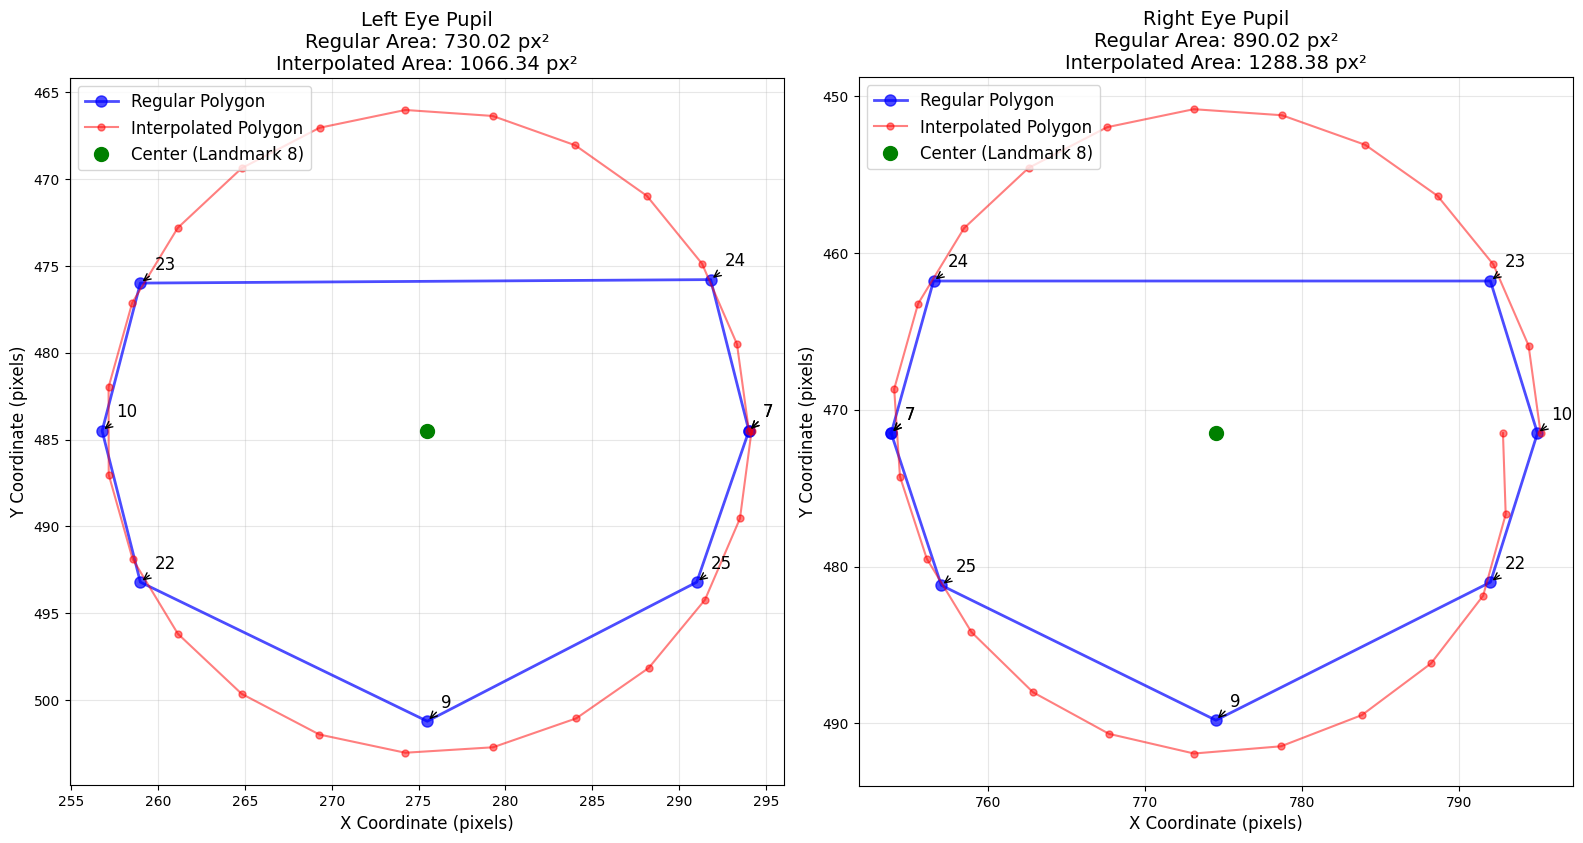

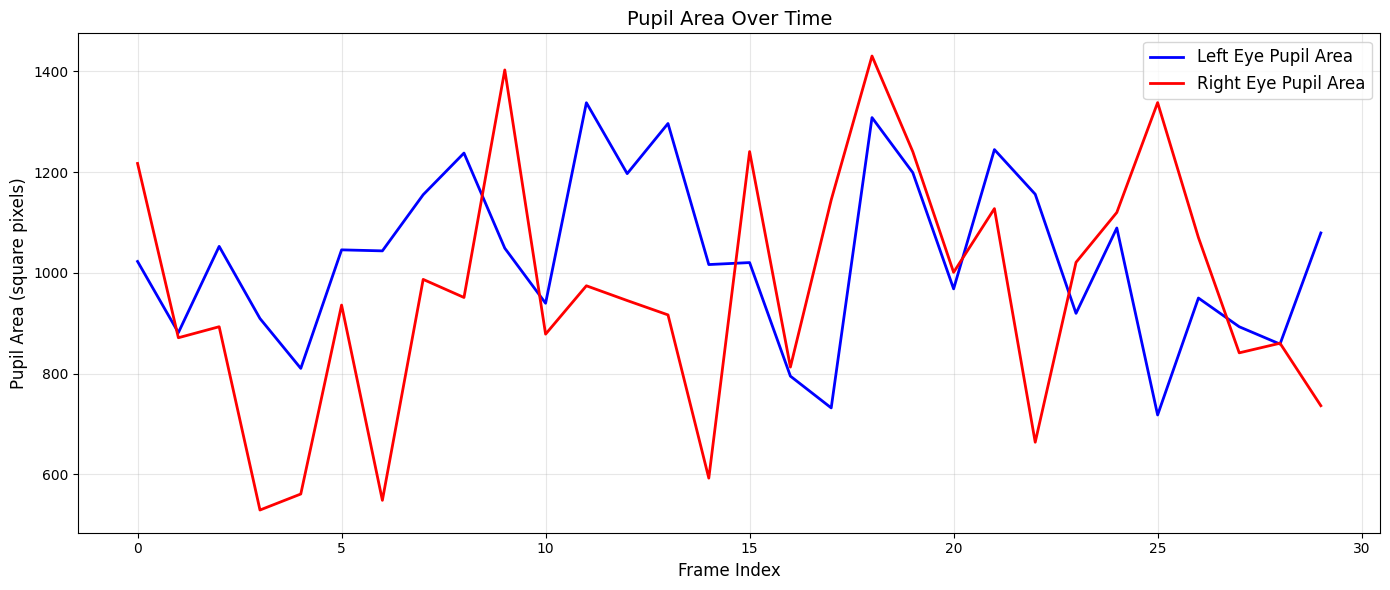

In [50]:
def visualize_pupil_polygons(landmarks_df, frame_idx=0):
    """
    Visualize pupil landmarks and polygons for both eyes
    
    Args:
        landmarks_df (pd.DataFrame): Landmarks data
        frame_idx (int): Index of the frame to visualize
    """
    # Get single frame data
    frame = landmarks_df.iloc[[frame_idx]]
    
    # Create figure with subplots for left and right eyes
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Eye names for iteration
    eyes = ['left', 'right']
    
    # Process each eye
    for i, eye in enumerate(eyes):
        ax = axes[i]
        
        # Get center (landmark 8)
        center_x = frame[f'{eye}_lm_8_x'].iloc[0]
        center_y = frame[f'{eye}_lm_8_y'].iloc[0]
        
        # Get regular polygon points
        landmark_sequence = [7, 25, 9, 22, 10, 23, 24, 7]
        regular_points = []
        for lm in landmark_sequence:
            x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
            y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
            regular_points.append((x, y))
        
        # Get boundary points for interpolation
        boundary_points = []
        for lm in [7, 25, 9, 22, 10, 23, 24, 7]:
            x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
            y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
            boundary_points.append((x, y))
        
        # Get interpolated points
        interp_points = []
        # Reuse interpolation code from the existing function
        angles = []
        distances = []
        for p in boundary_points:
            dx = p[0] - center_x
            dy = p[1] - center_y
            angle = np.arctan2(dy, dx)
            distance = np.sqrt(dx**2 + dy**2)
            angles.append(angle)
            distances.append(distance)
            
        angles_sorted = np.sort(angles)
        angles_interp = np.linspace(0, 2*np.pi, 24)
        distances_interp = np.interp(angles_interp, angles_sorted, distances)
        
        for angle, dist in zip(angles_interp, distances_interp):
            x = center_x + dist * np.cos(angle)
            y = center_y + dist * np.sin(angle)
            interp_points.append((x, y))
        
        # Create polygons 
        regular_polygon = Polygon(regular_points)
        interp_polygon = Polygon(interp_points)
        
        # Calculate areas
        regular_area = regular_polygon.area
        interp_area = interp_polygon.area
        
        # Plot regular polygon points
        regular_xs, regular_ys = zip(*regular_points)
        ax.plot(regular_xs, regular_ys, 'bo-', alpha=0.7, markersize=8, linewidth=2, label='Regular Polygon')
        
        # Plot interpolated polygon
        interp_xs, interp_ys = zip(*interp_points)
        ax.plot(interp_xs, interp_ys, 'ro-', alpha=0.5, markersize=5, linewidth=1.5, label='Interpolated Polygon')
        
        # Plot center point
        ax.plot(center_x, center_y, 'go', markersize=10, label='Center (Landmark 8)')
        
        # Plot boundary landmarks with their numbers
        for lm_idx, lm in enumerate([7, 25, 9, 22, 10, 23, 24, 7]):
            x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
            y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
            ax.annotate(str(lm), (x, y), fontsize=12, 
                        xytext=(10, 10), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='black'))
        
        # Set labels and title
        ax.set_title(f'{eye.capitalize()} Eye Pupil\nRegular Area: {regular_area:.2f} px²\nInterpolated Area: {interp_area:.2f} px²', fontsize=14)
        ax.set_xlabel('X Coordinate (pixels)', fontsize=12)
        ax.set_ylabel('Y Coordinate (pixels)', fontsize=12)
        
        # Add legend
        ax.legend(loc='upper left', fontsize=12)
        
        # Invert y-axis as images typically have origin at top left
        ax.invert_yaxis()
        
        # Equal aspect ratio to avoid distortion
        ax.set_aspect('equal')
        
        # Add grid
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also create a sequence of plots showing the progression of pupil size over time
    if len(landmarks_df) > 5:
        # Create figure for pupil size over time
        plt.figure(figsize=(14, 6))
        
        # Calculate pupil sizes for all frames
        left_areas = []
        right_areas = []
        timestamps = []
        
        for idx in range(min(len(landmarks_df), 30)):  # Limit to first 30 frames for speed
            frame = landmarks_df.iloc[[idx]]
            left_area, right_area = calculate_pupil_size_with_interpolation(frame)
            left_areas.append(left_area)
            right_areas.append(right_area)
            timestamps.append(idx)
        
        # Plot pupil size over time
        plt.plot(timestamps, left_areas, 'b-', linewidth=2, label='Left Eye Pupil Area')
        plt.plot(timestamps, right_areas, 'r-', linewidth=2, label='Right Eye Pupil Area')
        
        plt.title('Pupil Area Over Time', fontsize=14)
        plt.xlabel('Frame Index', fontsize=12)
        plt.ylabel('Pupil Area (square pixels)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Visualize the pupil polygons for the first frame
visualize_pupil_polygons(landmarks_df_cleaned, frame_idx=0)

In [ ]:


frame = landmarks_df_cleaned[[0]]

# eye = 'right'
# # get center
# center_x = frame[f'{eye}_lm_8_x'].iloc[0]
# center_y = frame[f'{eye}_lm_8_y'].iloc[0]
# get regular polygon points

# get boundary points for interpolation

# get interpolated points




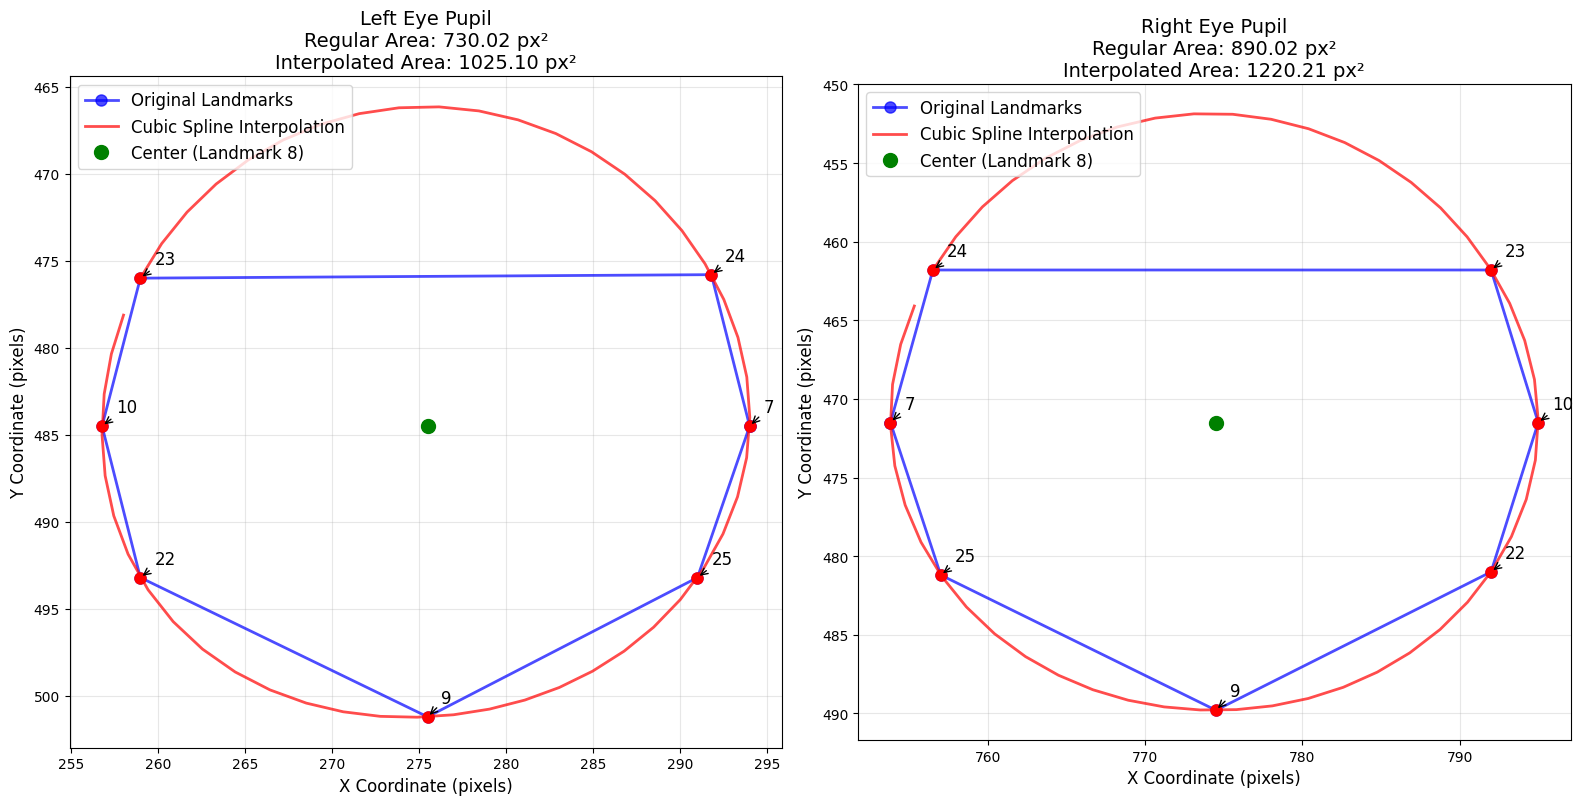

In [56]:
def visualize_pupil_polygons_with_interpolation(landmarks_df, frame_idx=0):
    """
    Visualize pupil landmarks and interpolated polygon
    
    Args:
        landmarks_df (pd.DataFrame): Landmarks data
        file_index (int): File index to visualize
        frame_idx (int): Index of the frame to visualize
    """
    # Get single frame data
    frame = landmarks_df.iloc[[frame_idx]]
    
    # Create figure with subplots for left and right eyes
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Eye names for iteration
    eyes = ['left', 'right']
    
    # Process each eye
    for i, eye in enumerate(eyes):
        ax = axes[i]
        
        # Get center (landmark 8)
        center_x = frame[f'{eye}_lm_8_x'].iloc[0]
        center_y = frame[f'{eye}_lm_8_y'].iloc[0]
        
        # Get regular polygon points
        landmark_sequence = [7, 25, 9, 22, 10, 23, 24, 7]  # Close the polygon
        regular_points = []
        for lm in landmark_sequence:
            x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
            y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
            regular_points.append((x, y))
        
        # Get interpolated polygon points
        boundary_points = []
        for lm in [7, 25, 9, 22, 10, 23, 24]:  # Without closing point
            x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
            y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
            boundary_points.append((x, y))
        
        # Use the same interpolation function as in calculate_pupil_size_with_interpolation
        from scipy.interpolate import CubicSpline
        center = (center_x, center_y)
        
        # Convert to polar coordinates
        points_polar = []
        for p in boundary_points:
            dx = p[0] - center[0]
            dy = p[1] - center[1]
            angle = np.arctan2(dy, dx)
            distance = np.sqrt(dx**2 + dy**2)
            points_polar.append((angle, distance, p))
        
        # Sort by angle
        points_polar.sort(key=lambda pp: pp[0])
        
        # Extract sorted data
        original_angles = [pp[0] for pp in points_polar]
        original_distances = [pp[1] for pp in points_polar]
        original_points = [pp[2] for pp in points_polar]
        
        # Wrap around for circular interpolation
        wrapped_angles = original_angles.copy()
        wrapped_distances = original_distances.copy()
        if max(wrapped_angles) - min(wrapped_angles) < 1.9 * np.pi:
            wrapped_angles.append(wrapped_angles[0] + 2 * np.pi)
            wrapped_distances.append(wrapped_distances[0])
        
        # Create cubic spline
        cs = CubicSpline(wrapped_angles, wrapped_distances, bc_type='periodic')
        
        # Generate many interpolated points
        num_interpolated = 50
        interp_angles = np.linspace(min(wrapped_angles), min(wrapped_angles) + 2*np.pi, num_interpolated, endpoint=False)
        interp_distances = cs(interp_angles)
        
        # Convert back to cartesian
        interp_points = []
        for angle, dist in zip(interp_angles, interp_distances):
            norm_angle = ((angle + np.pi) % (2 * np.pi)) - np.pi
            x = center[0] + dist * np.cos(norm_angle)
            y = center[1] + dist * np.sin(norm_angle)  # Fixed to use center[1] for y-coordinate
            interp_points.append((x, y))
        
        # Create polygons
        regular_polygon = Polygon(regular_points)
        interp_polygon = Polygon(interp_points)
        
        # Calculate areas
        regular_area = regular_polygon.area
        interp_area = interp_polygon.area
        
        # Plot regular polygon points
        regular_xs, regular_ys = zip(*regular_points)
        ax.plot(regular_xs, regular_ys, 'bo-', alpha=0.7, markersize=8, linewidth=2, label='Original Landmarks')
        
        # Plot interpolated polygon
        interp_xs, interp_ys = zip(*interp_points)
        ax.plot(interp_xs, interp_ys, 'r-', alpha=0.7, linewidth=2, label='Cubic Spline Interpolation')
        
        # Plot center point
        ax.plot(center_x, center_y, 'go', markersize=10, label='Center (Landmark 8)')
        
        # Highlight the original points on the spline
        boundary_xs, boundary_ys = zip(*boundary_points)
        ax.plot(boundary_xs, boundary_ys, 'ro', markersize=8)
        
        # Plot boundary landmarks with their numbers
        landmark_ids = [7, 25, 9, 22, 10, 23, 24]
        for lm_idx, lm in enumerate(landmark_ids):
            x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
            y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
            ax.annotate(str(lm), (x, y), fontsize=12, 
                        xytext=(10, 10), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='black'))
        
        # Set labels and title
        ax.set_title(f'{eye.capitalize()} Eye Pupil\nRegular Area: {regular_area:.2f} px²\nInterpolated Area: {interp_area:.2f} px²', fontsize=14)
        ax.set_xlabel('X Coordinate (pixels)', fontsize=12)
        ax.set_ylabel('Y Coordinate (pixels)', fontsize=12)
        
        # Add legend
        ax.legend(loc='upper left', fontsize=12)
        
        # Invert y-axis as images typically have origin at top left
        ax.invert_yaxis()
        
        # Equal aspect ratio to avoid distortion
        ax.set_aspect('equal')
        
        # Add grid
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_pupil_polygons_with_interpolation(landmarks_df_cleaned, frame_idx=0)

In [ ]:
# Test the improved interpolation visualization
for i, df in enumerate(landmarks_df):
    logger.info(f"Checking for outliers in file: {i}")
    visualize_pupil_polygons_with_interpolation(landmarks_df, file_index=0, frame_idx=0)

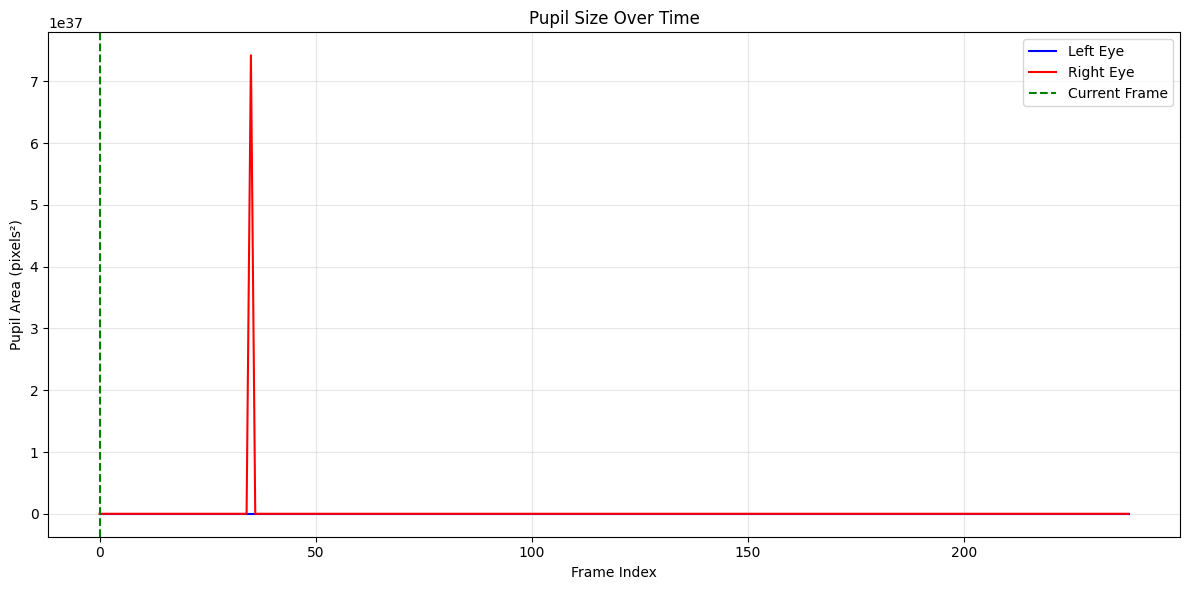

IntSlider(value=0, continuous_update=False, description='Frame:', layout=Layout(width='80%'), max=238)

<Figure size 640x480 with 0 Axes>

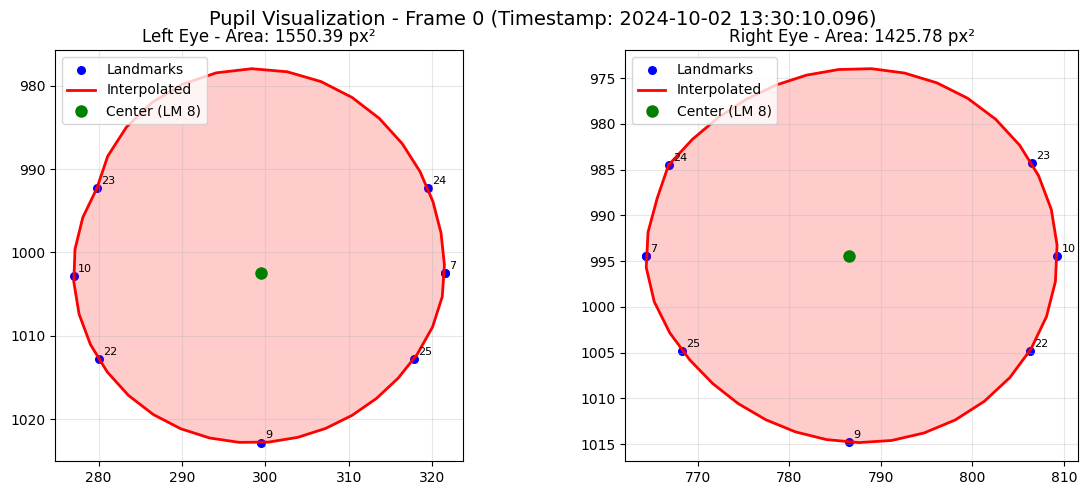

<Figure size 640x480 with 0 Axes>

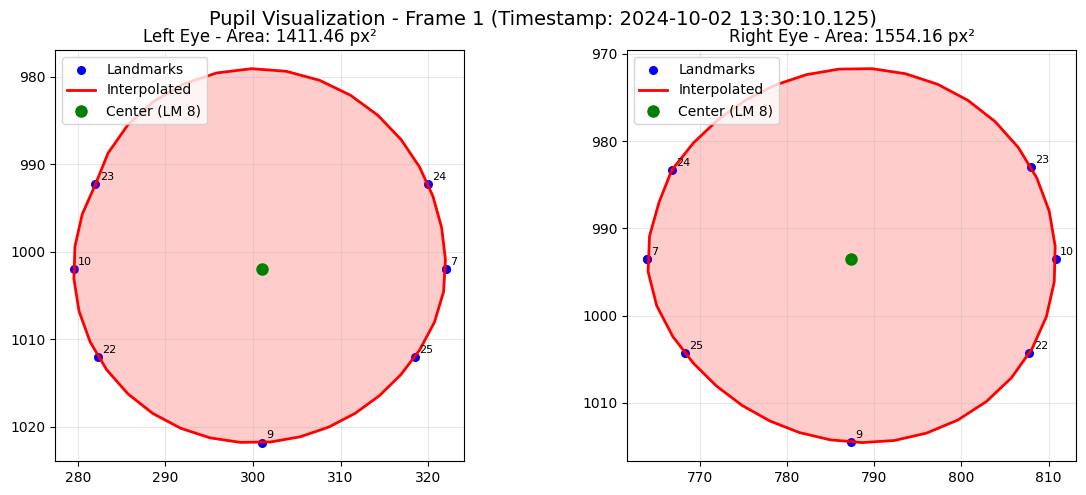

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

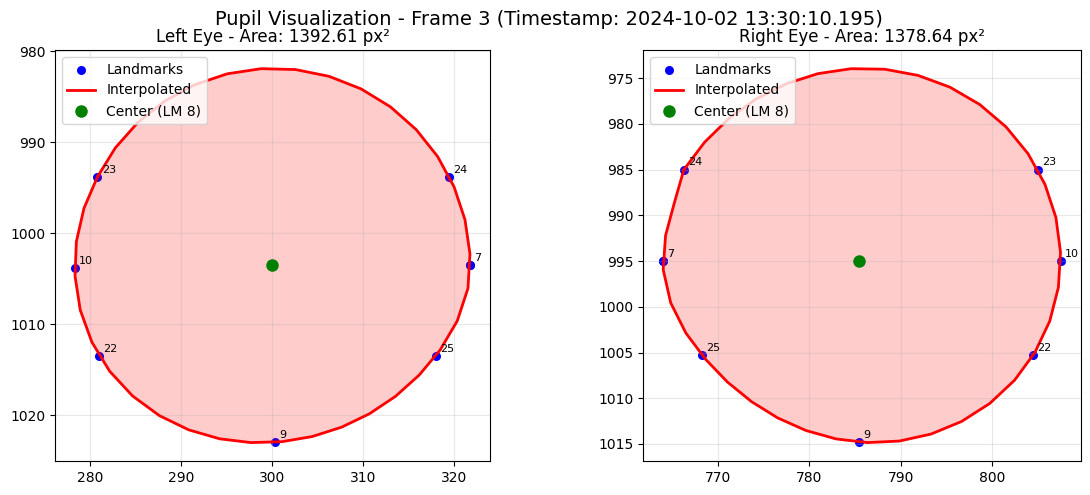

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

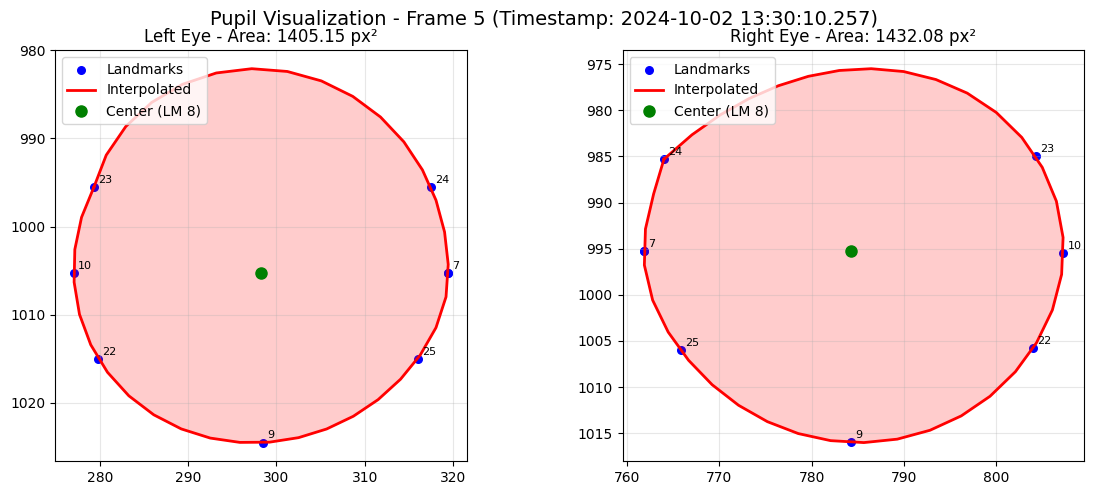

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

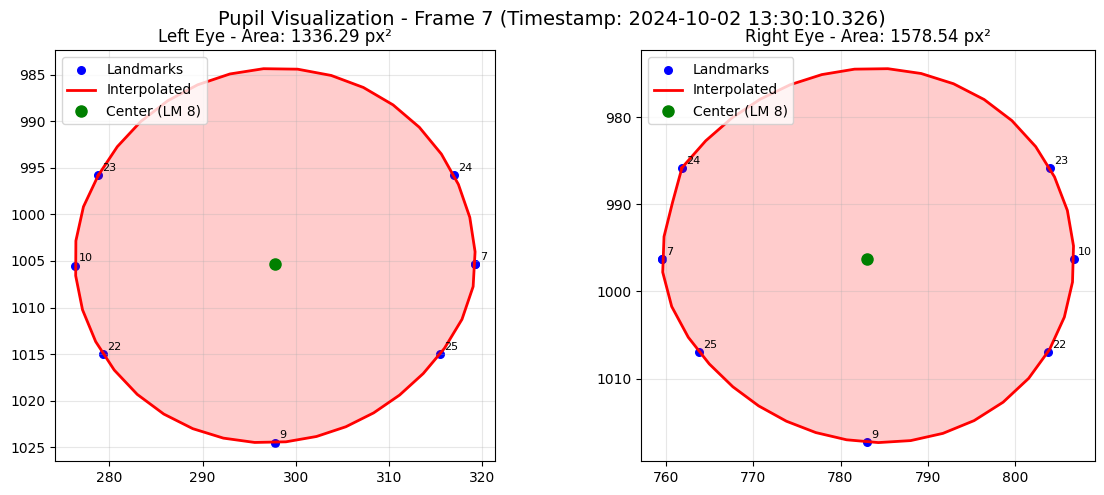

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

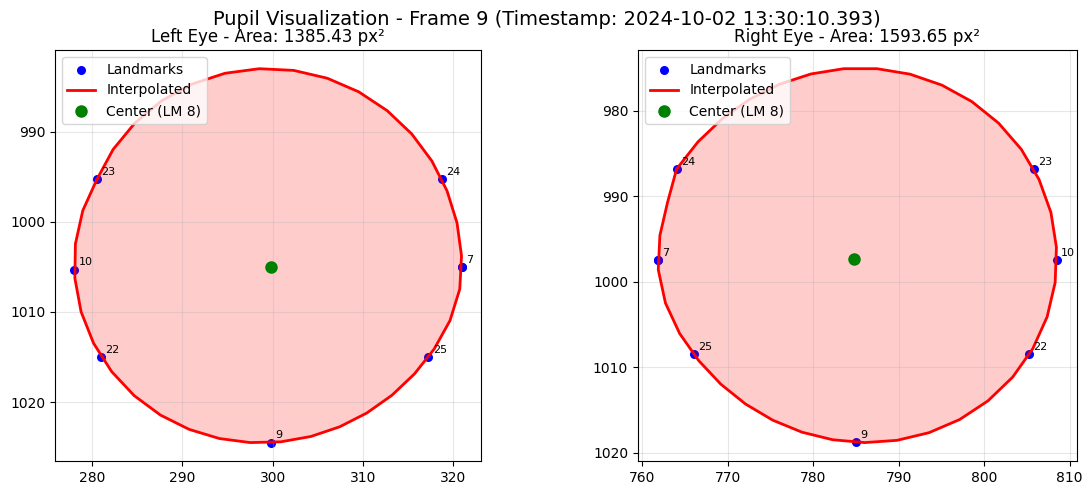

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

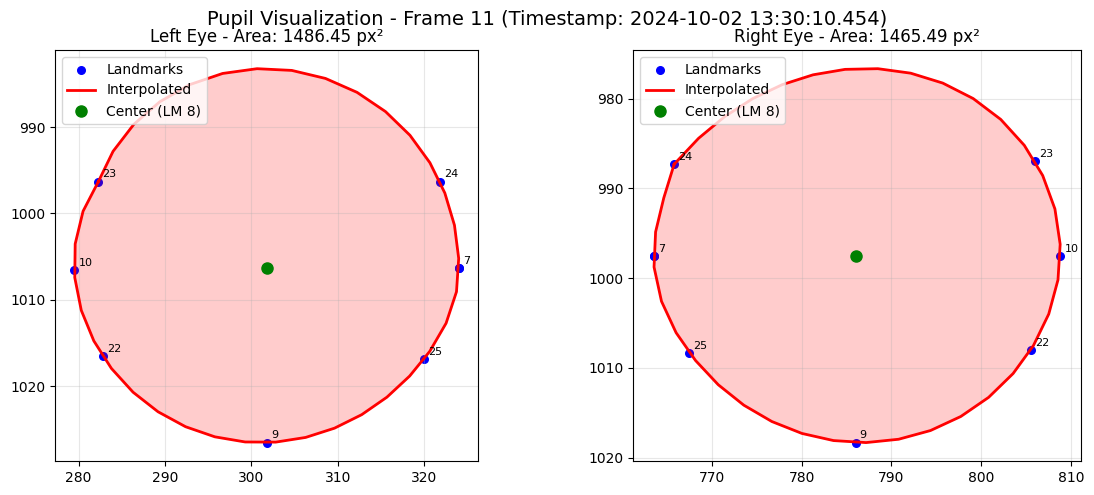

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

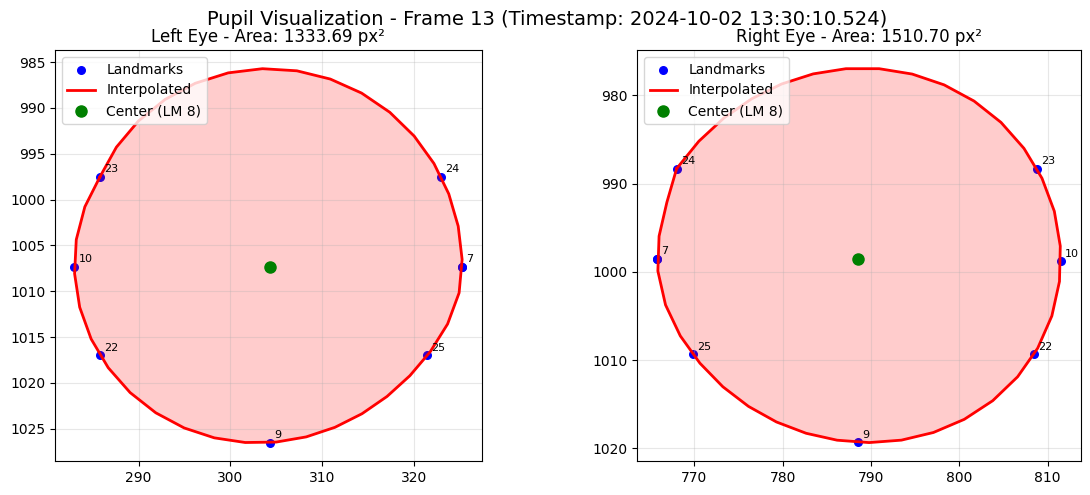

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

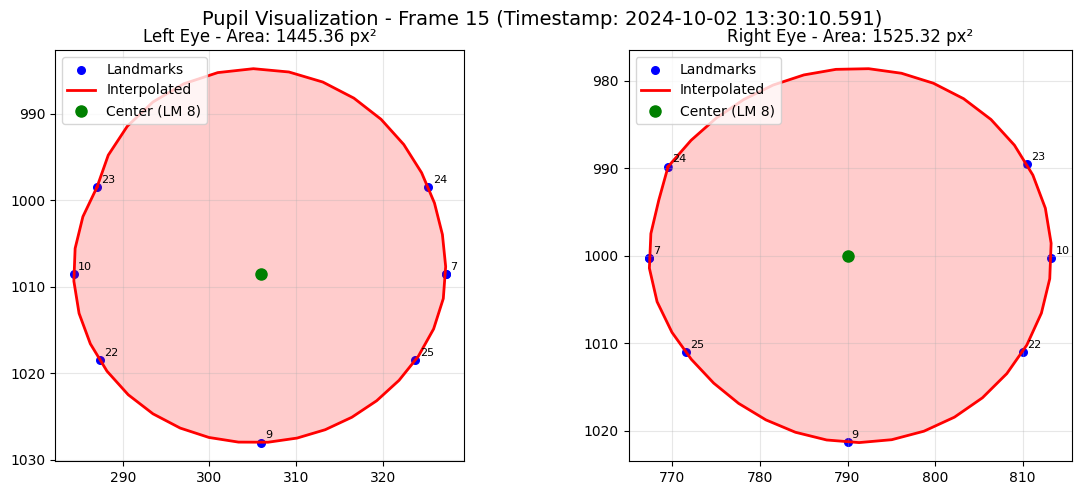

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

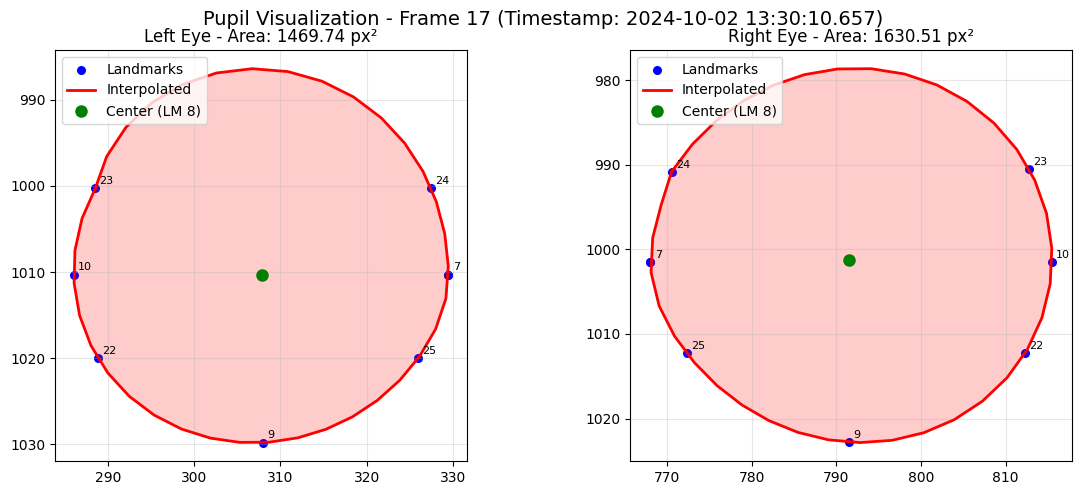

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

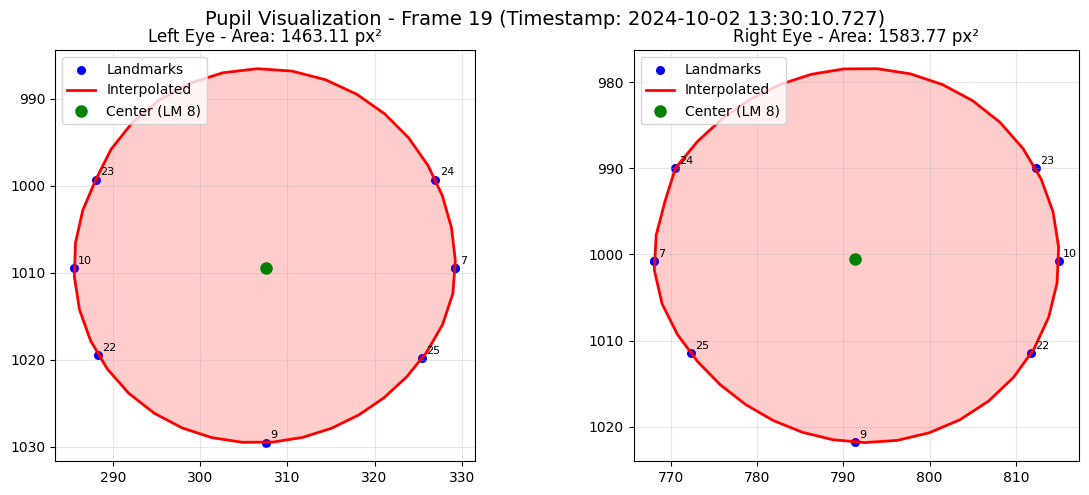

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

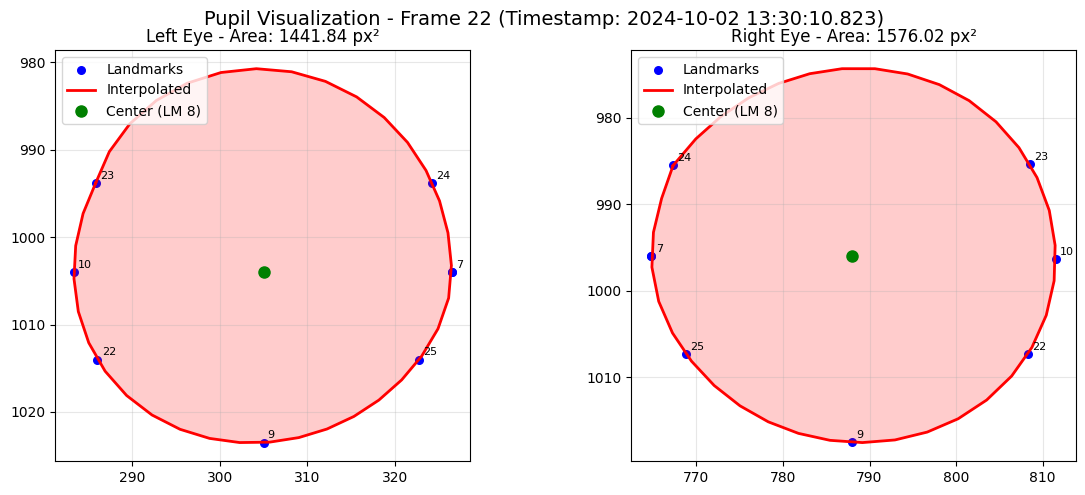

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

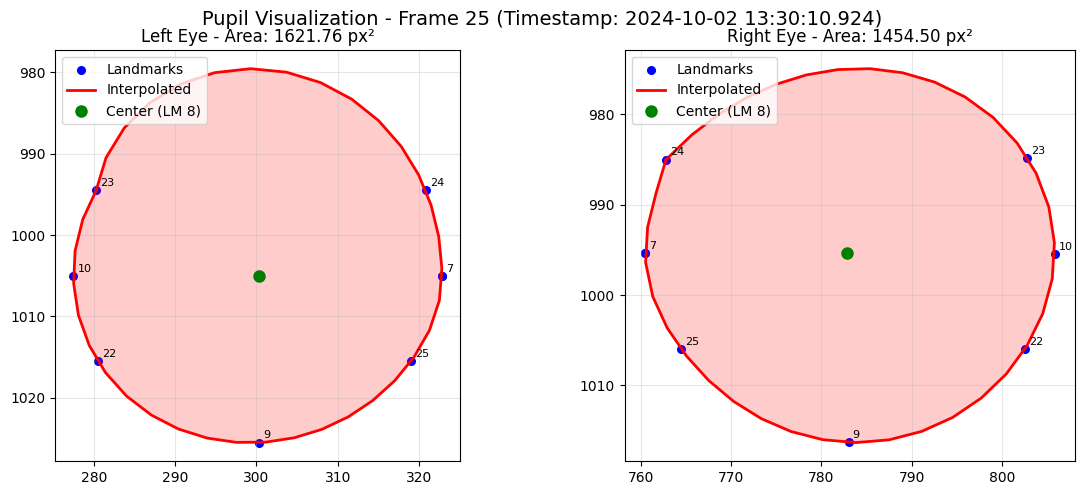

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

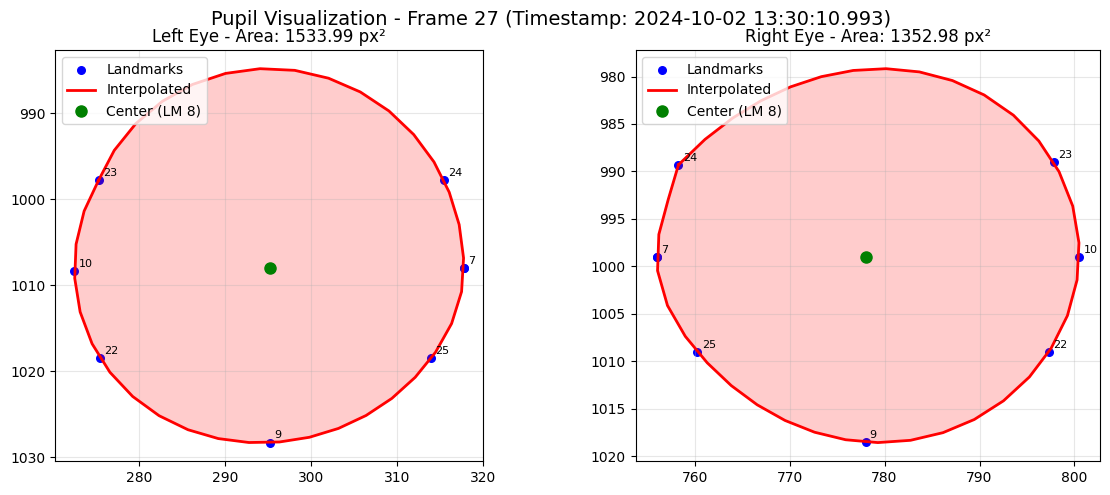

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

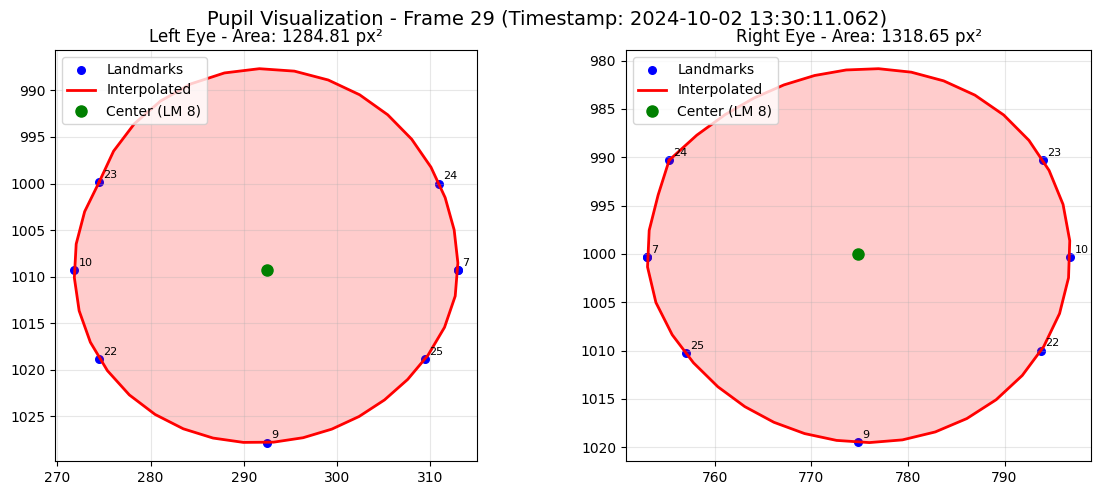

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

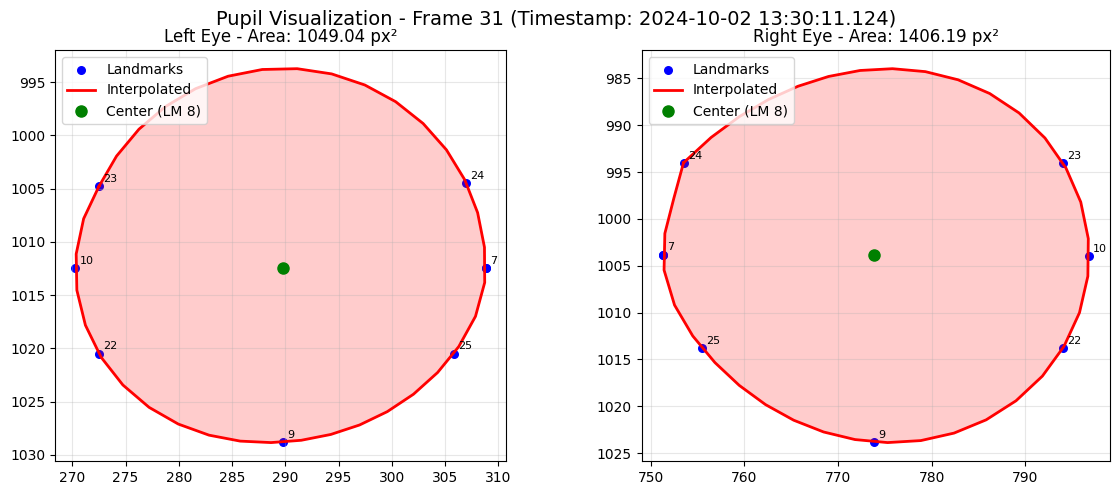

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

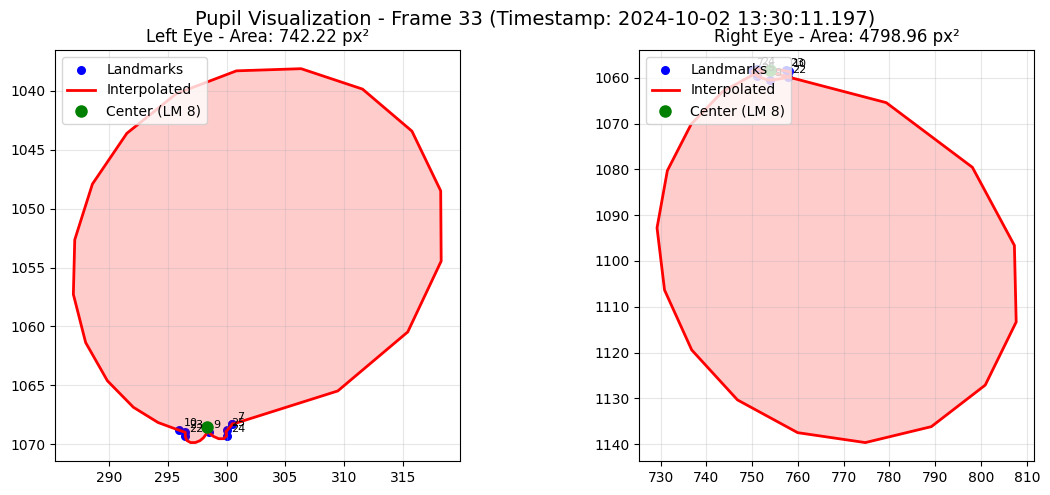

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

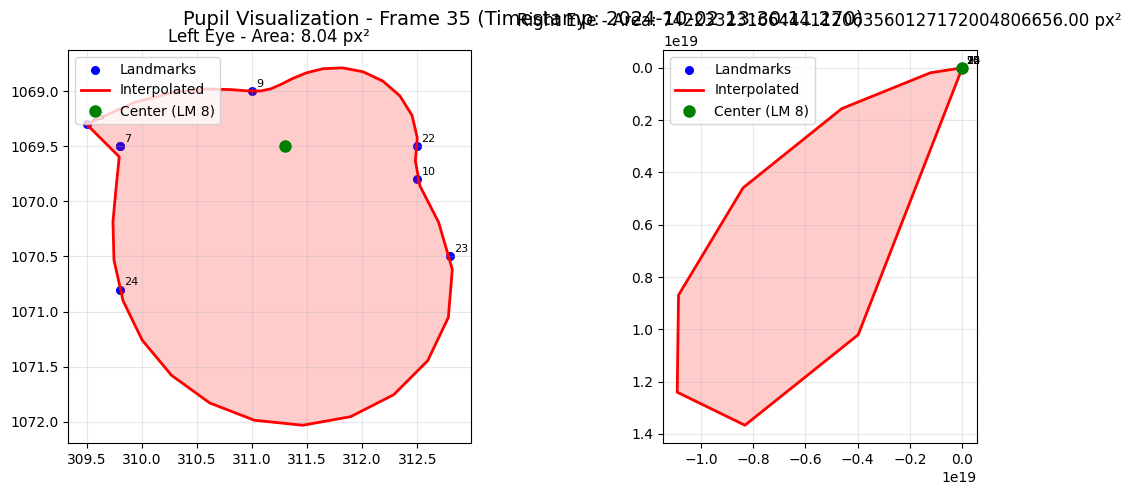

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

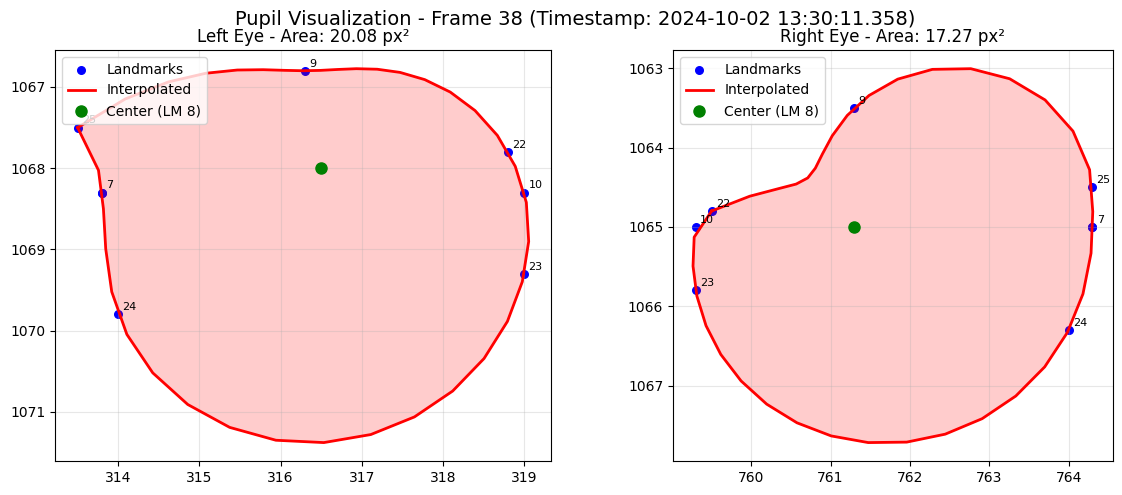

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

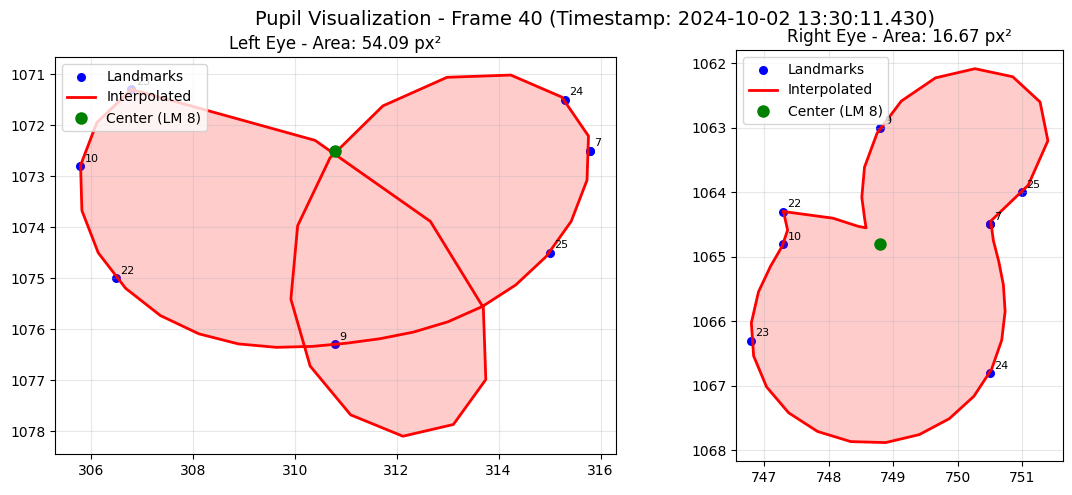

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

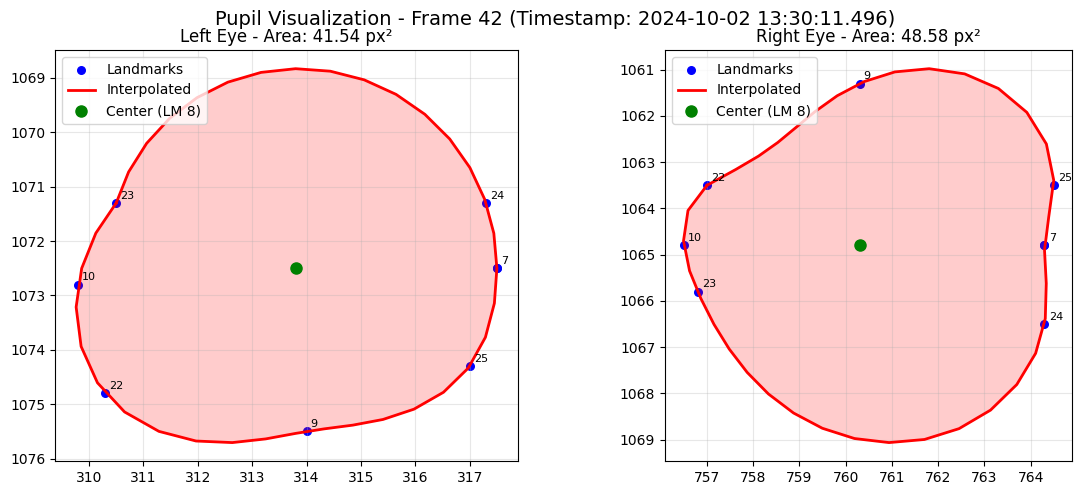

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

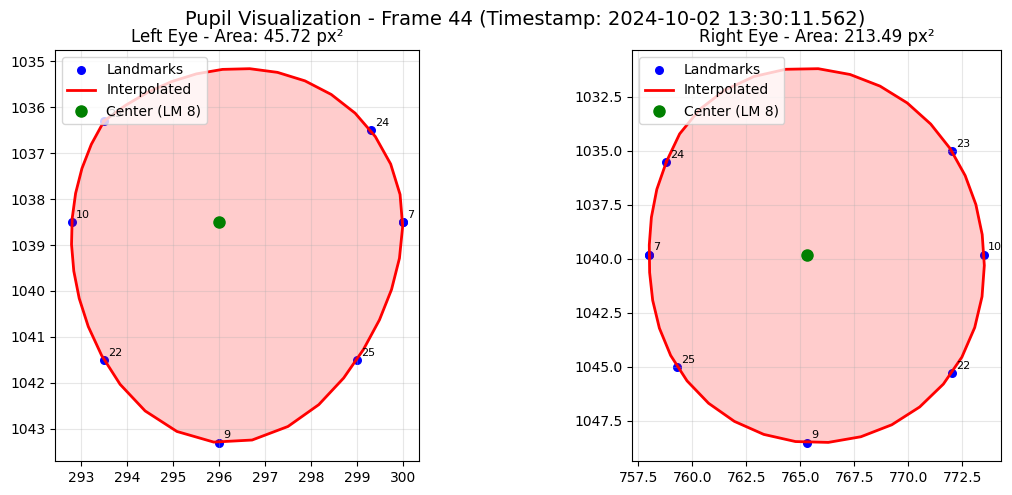

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

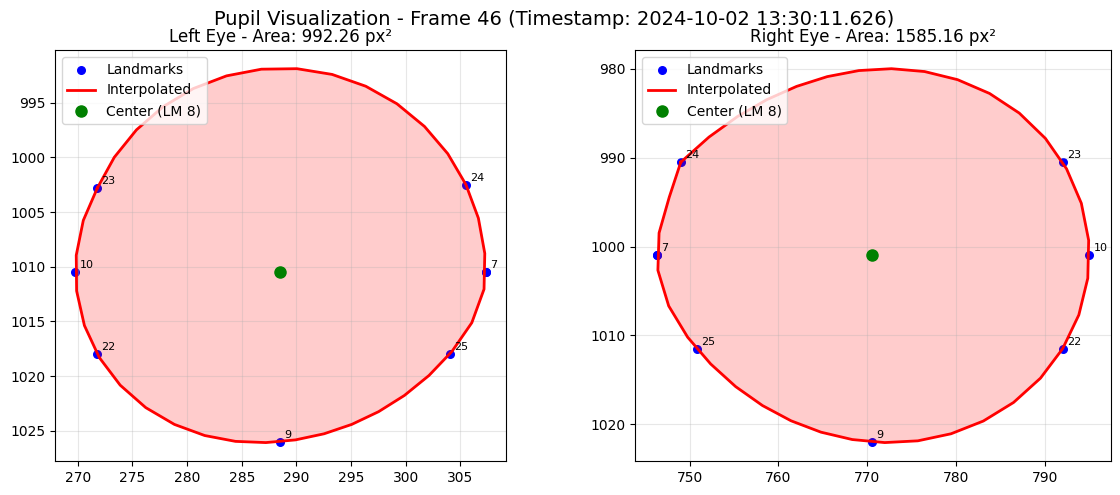

<Figure size 640x480 with 0 Axes>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.interpolate import CubicSpline
from shapely.geometry import Polygon
import matplotlib.patches as patches
from IPython.display import display, clear_output
import ipywidgets as widgets

# Load the data
data_path = '/home/lrn/Repos/analyze-eye-tracking-data/data/4cac0bd4-a541-48db-a20f-13daf9d5bf5d/4cac0bd4-a541-48db-a20f-13daf9d5bf5d_plr_landmarks.csv'
landmarks_df = pd.read_csv(data_path)

# Clean data - keep only valid frames
landmarks_df = landmarks_df[landmarks_df['retcode'] == 'OK'].reset_index(drop=True)

def get_pupil_boundary_points(frame, eye):
    """Extract pupil boundary points for a specific eye and frame"""
    boundary_points = []
    for lm in [7, 25, 9, 22, 10, 23, 24, 7]:  # Pupil landmarks (closing the loop with 7 again)
        x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
        y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
        boundary_points.append((x, y))
    return boundary_points

def get_pupil_center(frame, eye):
    """Get the center point (landmark 8) of the pupil"""
    center_x = frame[f'{eye}_lm_8_x'].iloc[0]
    center_y = frame[f'{eye}_lm_8_y'].iloc[0]
    return center_x, center_y

def interpolate_pupil(center, boundary_points, num_points=36):
    """Create a smooth interpolated pupil boundary using cubic spline"""
    # Convert to polar coordinates relative to center
    points_polar = []
    for p in boundary_points:
        dx = p[0] - center[0]
        dy = p[1] - center[1]
        angle = np.arctan2(dy, dx)
        distance = np.sqrt(dx**2 + dy**2)
        points_polar.append((angle, distance, p))
    
    # Sort by angle
    points_polar.sort(key=lambda pp: pp[0])
    
    # Extract sorted data
    angles = [pp[0] for pp in points_polar]
    distances = [pp[1] for pp in points_polar]
    
    # Handle edge case to ensure proper wrapping
    wrapped_angles = angles.copy()
    wrapped_distances = distances.copy()
    
    # If we don't have full circle coverage, wrap around
    if max(wrapped_angles) - min(wrapped_angles) < 1.9 * np.pi:
        wrapped_angles.append(wrapped_angles[0] + 2 * np.pi)
        wrapped_distances.append(wrapped_distances[0])
    
    # CRITICAL FIX: Ensure strictly increasing sequence by adding a tiny offset to duplicate angles
    eps = 1e-10  # Small epsilon value
    for i in range(1, len(wrapped_angles)):
        if wrapped_angles[i] <= wrapped_angles[i-1]:
            wrapped_angles[i] = wrapped_angles[i-1] + eps
    
    # Create cubic spline with periodic boundary condition
    cs = CubicSpline(wrapped_angles, wrapped_distances, bc_type='not-a-knot')
    
    # Generate smooth interpolated points
    interp_angles = np.linspace(min(wrapped_angles), min(wrapped_angles) + 2*np.pi, num_points, endpoint=False)
    interp_distances = cs(interp_angles)
    
    # Convert back to cartesian coordinates
    interp_points = []
    for angle, dist in zip(interp_angles, interp_distances):
        norm_angle = angle % (2 * np.pi)
        x = center[0] + dist * np.cos(norm_angle)
        y = center[1] + dist * np.sin(norm_angle)
        interp_points.append((x, y))
    
    return interp_points

def calculate_pupil_area(points):
    """Calculate the area of the pupil using Shapely Polygon"""
    polygon = Polygon(points)
    return polygon.area

# Pre-calculate pupil sizes and interpolated polygons for all frames
total_frames = len(landmarks_df)
frames = []
pupil_areas = {'left': [], 'right': []}
interpolated_polygons = {'left': [], 'right': []}

for i in range(total_frames):
    frame = landmarks_df.iloc[[i]]
    frames.append(frame)
    
    for eye in ['left', 'right']:
        # Get center and boundary points
        center = get_pupil_center(frame, eye)
        boundary_points = get_pupil_boundary_points(frame, eye)
        
        # Get interpolated polygon
        interp_polygon = interpolate_pupil((center[0], center[1]), boundary_points)
        interpolated_polygons[eye].append(interp_polygon)
        
        # Calculate and store pupil area
        area = calculate_pupil_area(interp_polygon)
        pupil_areas[eye].append(area)

# Create the interactive widget for frame selection
def update_plot(frame_idx):
    """Update the eye plots for the given frame index"""
    frame_idx = int(frame_idx)
    
    # Clear previous plot
    plt.clf()
    
    # Set up the figure with two subplots (left and right eyes)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Add title with frame information
    fig.suptitle(f"Pupil Visualization - Frame {frame_idx} (Timestamp: {landmarks_df.iloc[frame_idx]['timestamp']})", fontsize=14)
    
    # Plot both eyes
    for i, eye in enumerate(['left', 'right']):
        ax = axes[i]
        
        # Get data for this frame
        current_frame = frames[frame_idx]
        center = get_pupil_center(current_frame, eye)
        boundary_points = get_pupil_boundary_points(current_frame, eye)
        interp_polygon = interpolated_polygons[eye][frame_idx]
        area = pupil_areas[eye][frame_idx]
        
        # Extract x, y coordinates
        boundary_x, boundary_y = zip(*boundary_points)
        interp_x, interp_y = zip(*interp_polygon)
        
        # Plot the original boundary points
        ax.scatter(boundary_x, boundary_y, color='blue', s=30, label='Landmarks')
        
        # Plot the interpolated polygon
        ax.fill(interp_x, interp_y, alpha=0.2, color='red')
        ax.plot(interp_x + (interp_x[0],), interp_y + (interp_y[0],), 'r-', linewidth=2, label='Interpolated')
        
        # Plot the center point
        ax.plot(center[0], center[1], 'go', markersize=8, label='Center (LM 8)')
        
        # Annotate landmark numbers
        landmark_indices = [7, 25, 9, 22, 10, 23, 24]
        for j, lm in enumerate(landmark_indices):
            x = current_frame[f'{eye}_lm_{lm}_x'].iloc[0]
            y = current_frame[f'{eye}_lm_{lm}_y'].iloc[0]
            ax.annotate(str(lm), (x, y), fontsize=8, xytext=(3, 3), textcoords='offset points')
        
        # Set title with area information
        ax.set_title(f"{eye.capitalize()} Eye - Area: {area:.2f} px²")
        
        # Set axis properties
        ax.set_aspect('equal')
        ax.invert_yaxis()  # Invert y-axis to match image coordinates
        ax.grid(alpha=0.3)
        
        # Add legend
        ax.legend(loc='upper left')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Create a second plot for pupil size over time
def plot_pupil_size_over_time():
    """Create a static plot showing pupil size for both eyes over all frames"""
    plt.figure(figsize=(12, 6))
    
    # Plot the area for both eyes
    frame_indices = list(range(total_frames))
    plt.plot(frame_indices, pupil_areas['left'], 'b-', label='Left Eye')
    plt.plot(frame_indices, pupil_areas['right'], 'r-', label='Right Eye')
    
    # Mark the current frame with vertical line (will be updated interactively)
    marker_line = plt.axvline(x=0, color='green', linestyle='--', label='Current Frame')
    
    # Add labels and title
    plt.xlabel('Frame Index')
    plt.ylabel('Pupil Area (pixels²)')
    plt.title('Pupil Size Over Time')
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Return the marker line for updating
    return marker_line

# This should be a separate function that handles preprocessing
def preprocess_landmarks_data(landmarks_file_path):
    """
    Load, clean, and preprocess landmarks data
    
    Args:
        landmarks_file_path (str): Path to landmarks CSV file
        
    Returns:
        tuple: (landmarks_df, pupil_areas, interpolated_polygons)
    """
    # Load the data
    landmarks_df = pd.read_csv(landmarks_file_path)
    
    # Clean data - keep only valid frames
    landmarks_df = landmarks_df[landmarks_df['retcode'] == 'OK'].reset_index(drop=True)
    
    # Pre-calculate pupil sizes and interpolated polygons
    total_frames = len(landmarks_df)
    frames = []
    pupil_areas = {'left': [], 'right': []}
    interpolated_polygons = {'left': [], 'right': []}
    
    for i in range(total_frames):
        frame = landmarks_df.iloc[[i]]
        frames.append(frame)
        
        for eye in ['left', 'right']:
            # Get center and boundary points
            center = get_pupil_center(frame, eye)
            boundary_points = get_pupil_boundary_points(frame, eye)
            
            # Get interpolated polygon
            interp_polygon = interpolate_pupil((center[0], center[1]), boundary_points)
            interpolated_polygons[eye].append(interp_polygon)
            
            # Calculate and store pupil area
            area = calculate_pupil_area(interp_polygon)
            pupil_areas[eye].append(area)
            
    return landmarks_df, frames, pupil_areas, interpolated_polygons


# This function focuses only on interactive visualization
def create_interactive_visualization(landmarks_df, frames, pupil_areas, interpolated_polygons):
    """
    Create interactive visualization for pupil data
    
    Args:
        landmarks_df (pd.DataFrame): Processed landmarks data
        frames (list): List of frames
        pupil_areas (dict): Dictionary with pupil area data
        interpolated_polygons (dict): Dictionary with interpolated polygons
    """
    total_frames = len(landmarks_df)
    
    # Create the figure for pupil size over time
    plt.figure(figsize=(12, 6))
    frame_indices = list(range(total_frames))
    plt.plot(frame_indices, pupil_areas['left'], 'b-', label='Left Eye')
    plt.plot(frame_indices, pupil_areas['right'], 'r-', label='Right Eye')
    
    # Create a vertical line marker
    marker_line = plt.axvline(x=0, color='green', linestyle='--', label='Current Frame')
    
    plt.xlabel('Frame Index')
    plt.ylabel('Pupil Area (pixels²)')
    plt.title('Pupil Size Over Time')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Create the interactive slider
    def on_frame_change(change):
        new_frame = change['new']
        # Update pupil visualization
        update_plot(new_frame)
        # Update marker position
        marker_line.set_xdata([new_frame, new_frame])
        plt.draw()
    
    # Create the slider widget
    frame_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=total_frames-1,
        step=1,
        description='Frame:',
        continuous_update=False,
        layout=widgets.Layout(width='80%')
    )
    
    # Display controls and initial plot
    display(frame_slider)
    update_plot(0)
    
    # Register callback for slider changes
    frame_slider.observe(on_frame_change, names='value')
    
    # Add buttons for play/pause functionality
    play_button = widgets.Play(
        value=0,
        min=0,
        max=total_frames-1,
        step=1,
        interval=200,  # ms between frames
        description="Play",
        disabled=False
    )
    
    # Link play button to slider
    widgets.jslink((play_button, 'value'), (frame_slider, 'value'))
    
    display(widgets.HBox([play_button, frame_slider]))
    
# First process the data (done once)
landmarks_df, frames, pupil_areas, interpolated_polygons = preprocess_landmarks_data(data_path)

# Then create the visualization (using pre-processed data)
create_interactive_visualization(landmarks_df, frames, pupil_areas, interpolated_polygons)

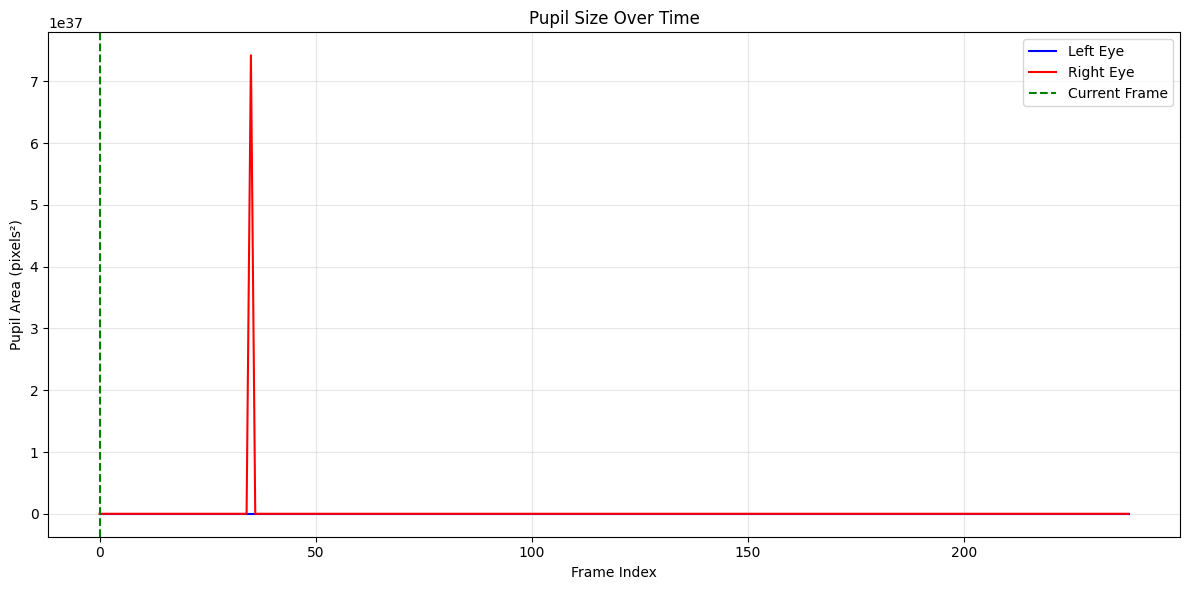

IntSlider(value=0, continuous_update=False, description='Frame:', layout=Layout(width='80%'), max=238)

<Figure size 640x480 with 0 Axes>

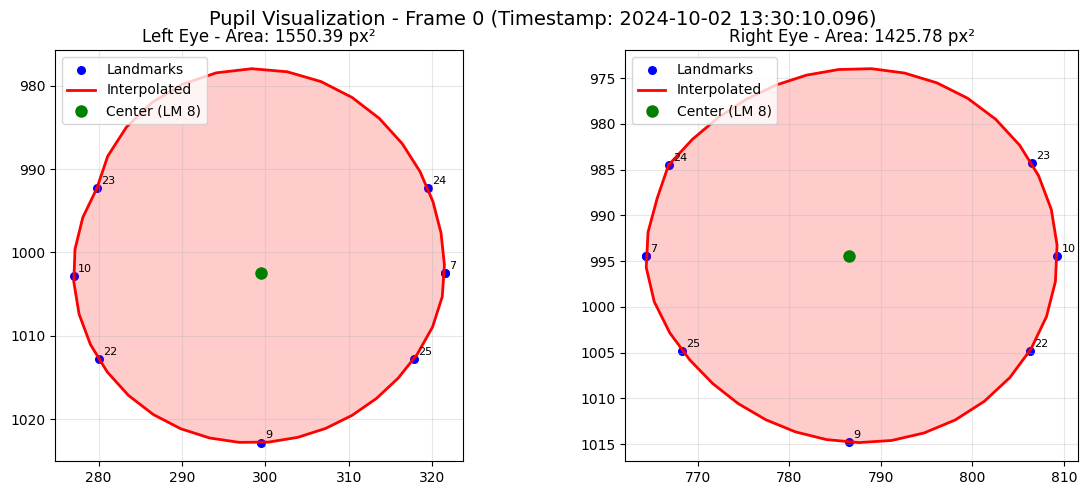

<Figure size 640x480 with 0 Axes>

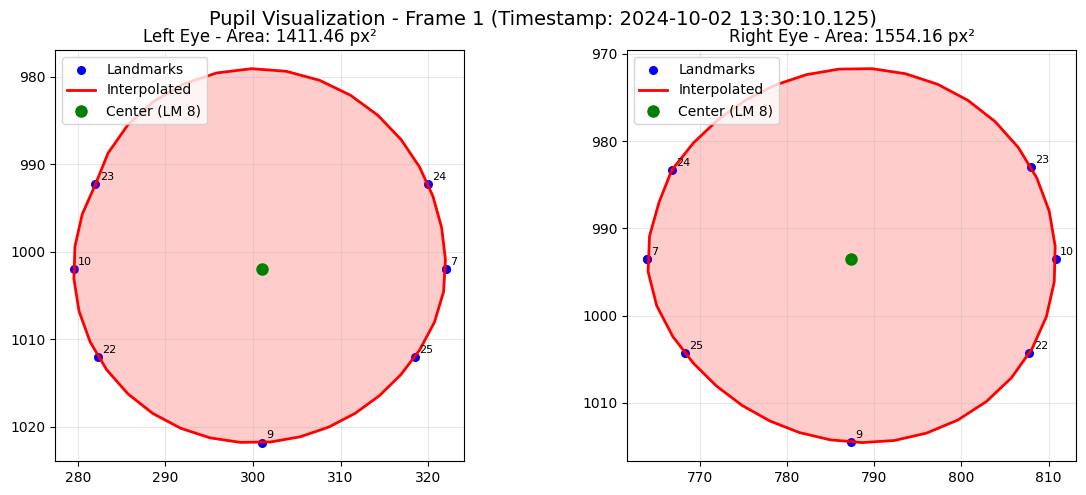

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

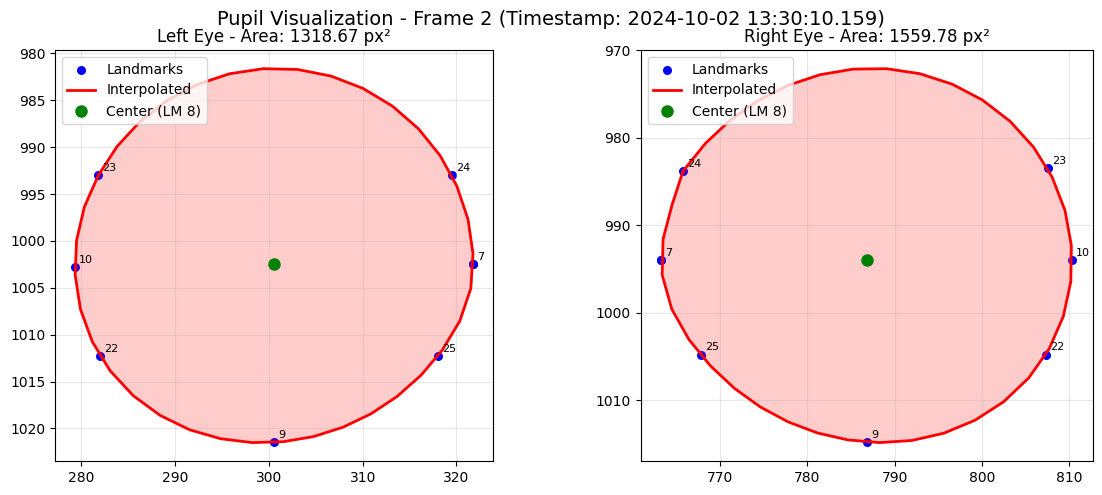

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

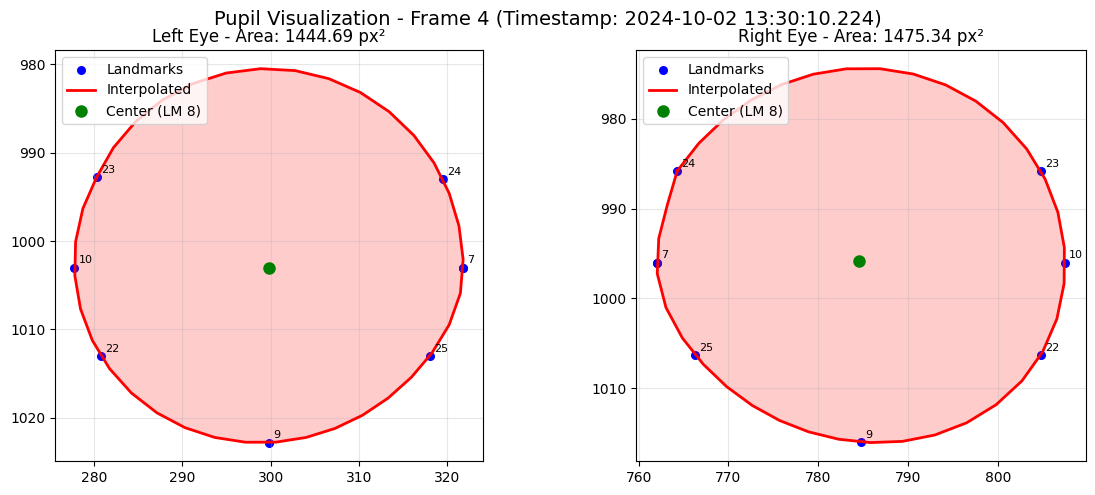

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

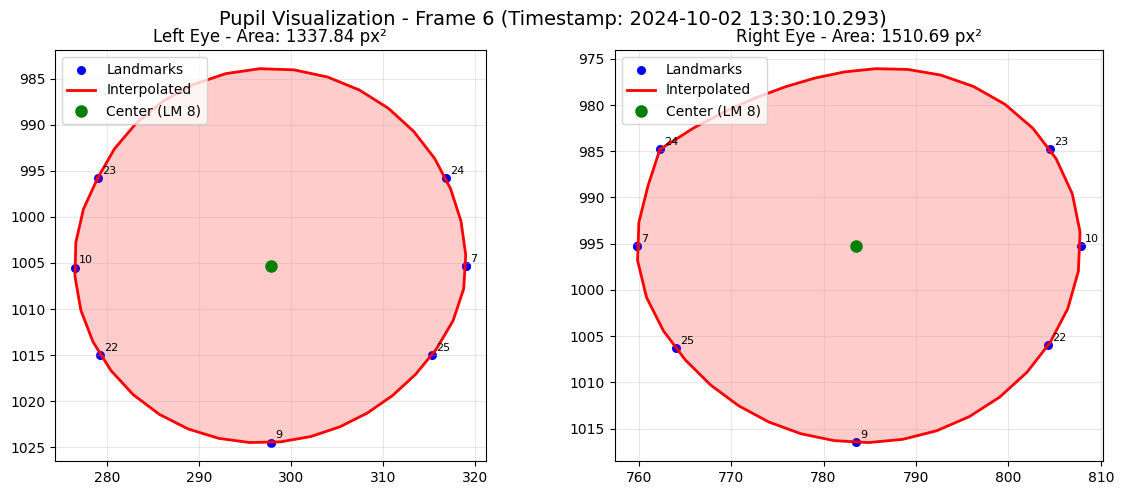

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

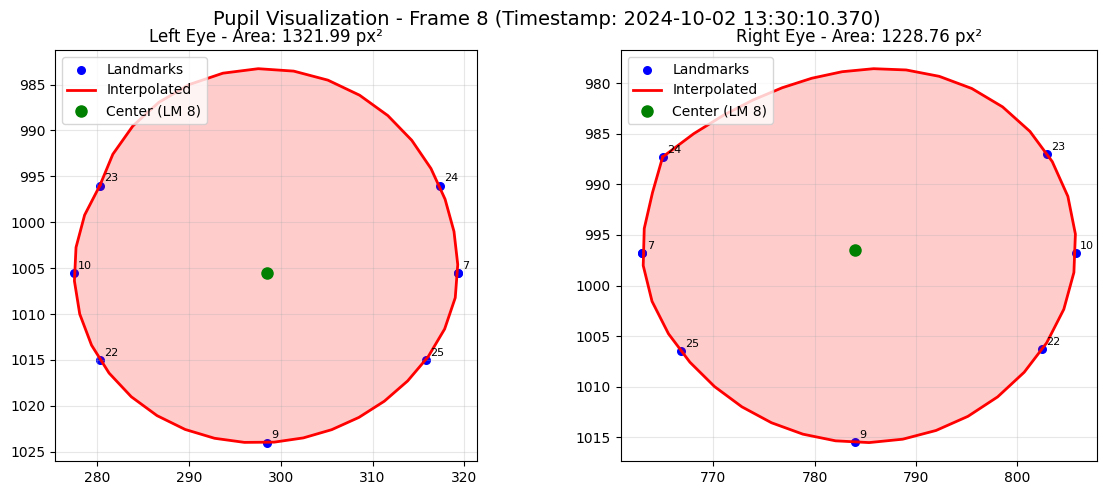

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

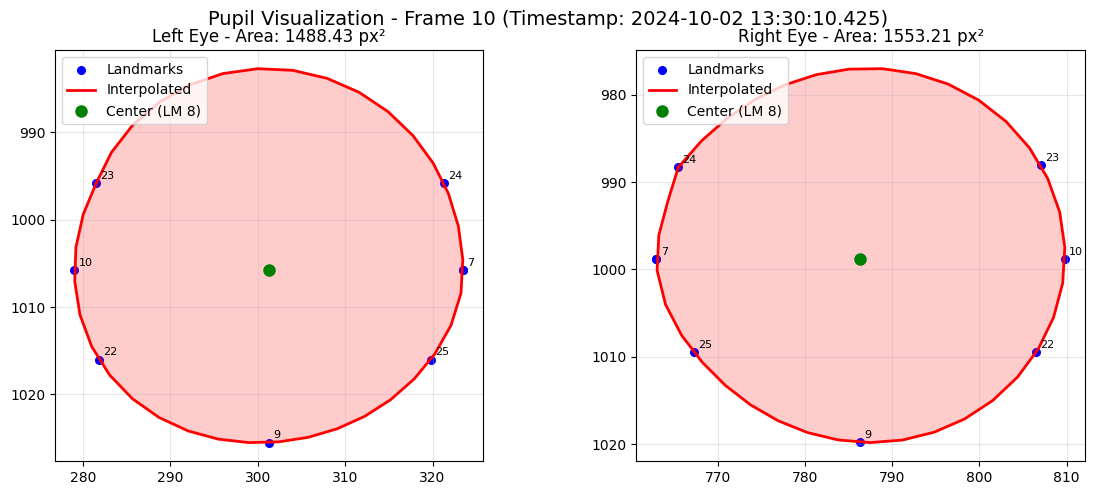

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

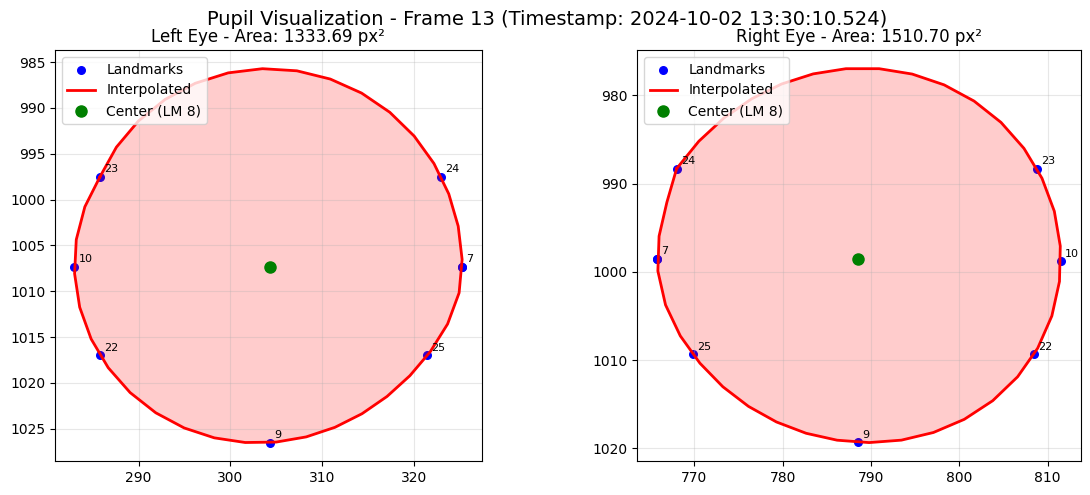

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

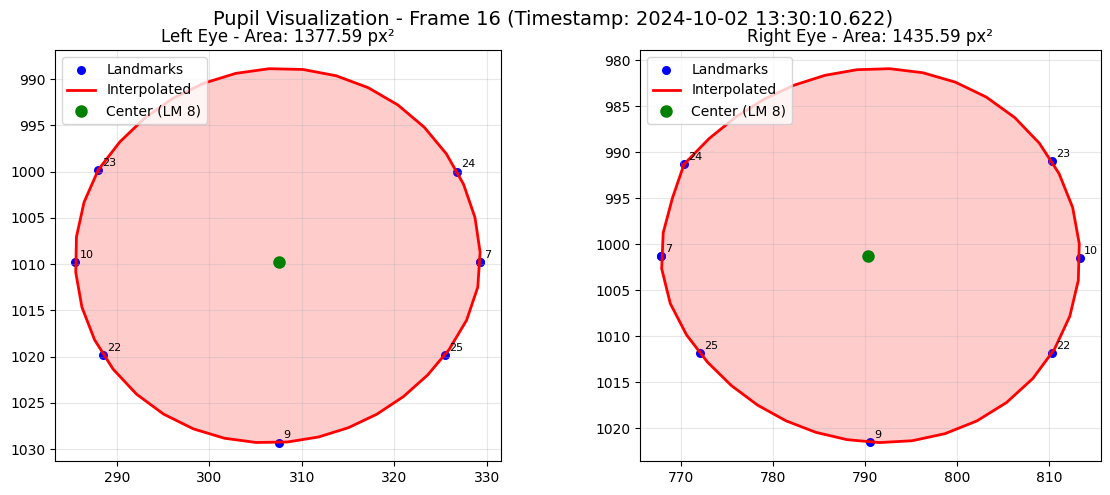

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

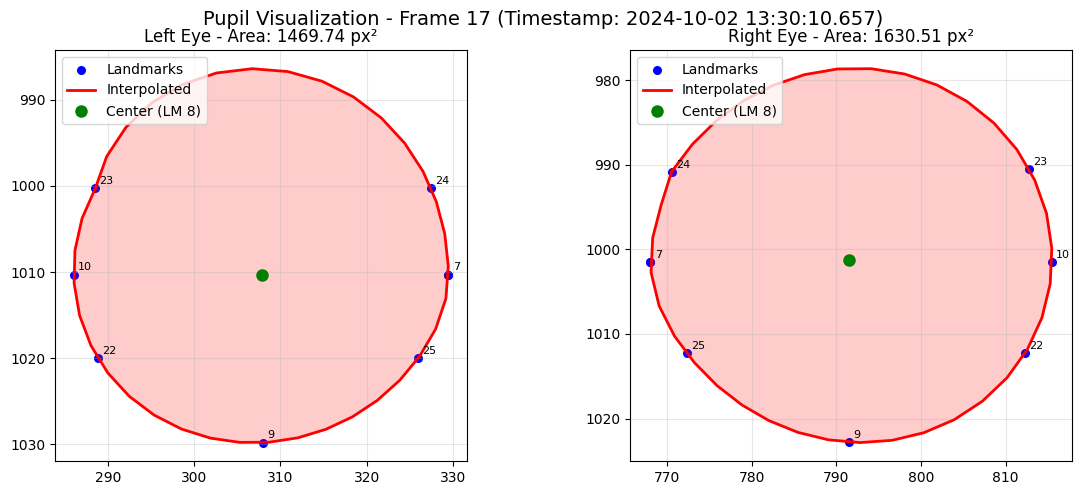

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

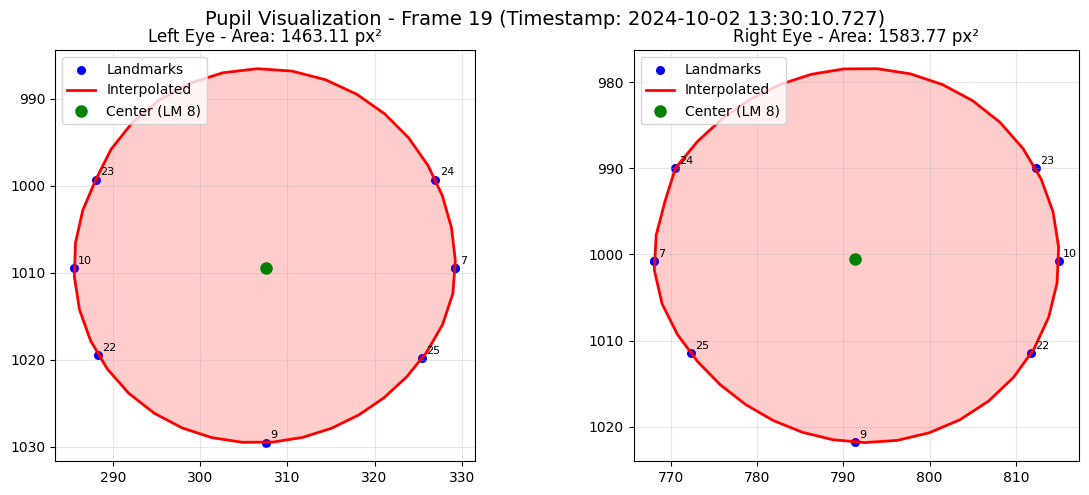

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

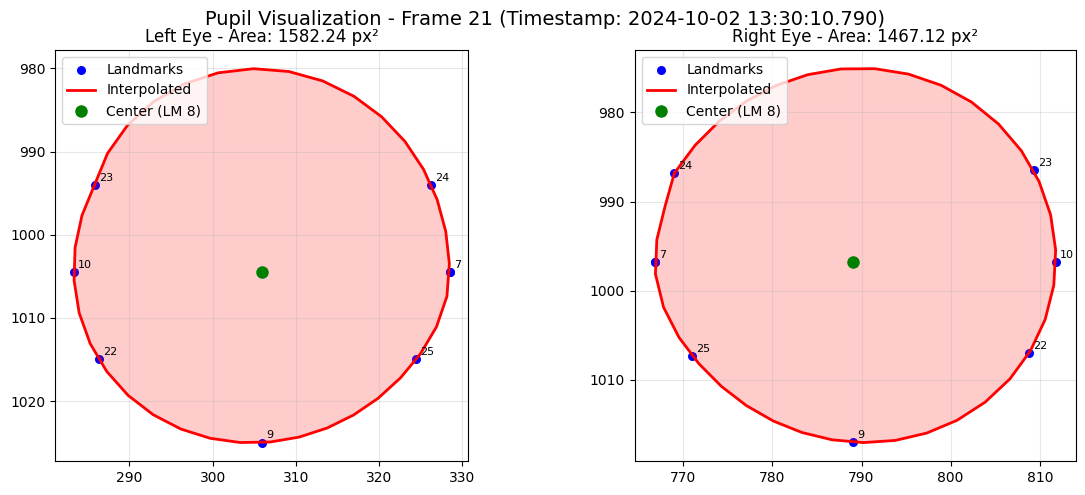

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

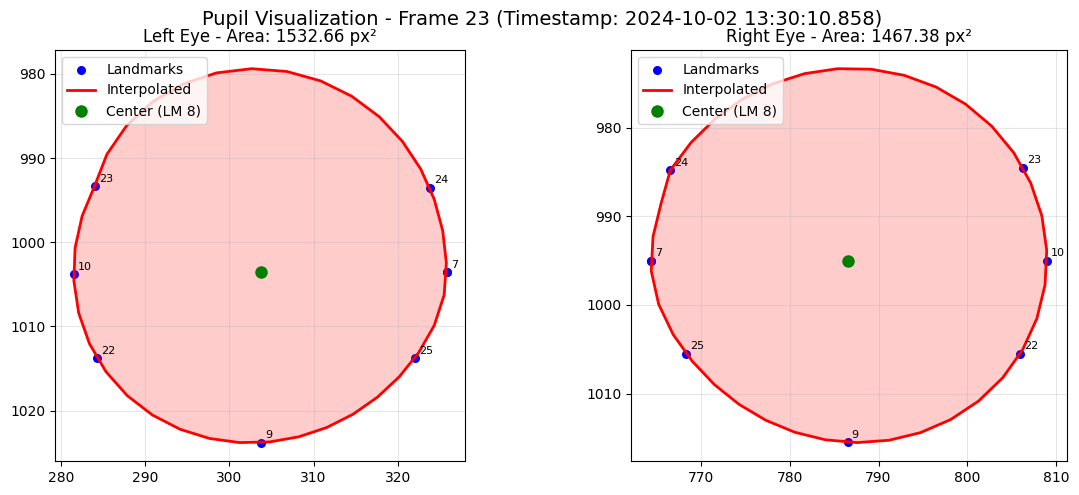

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

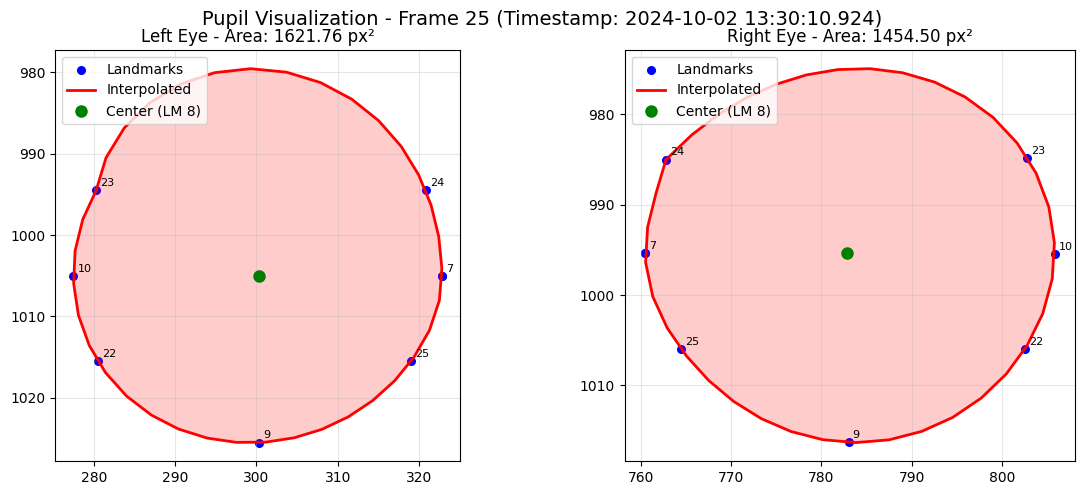

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

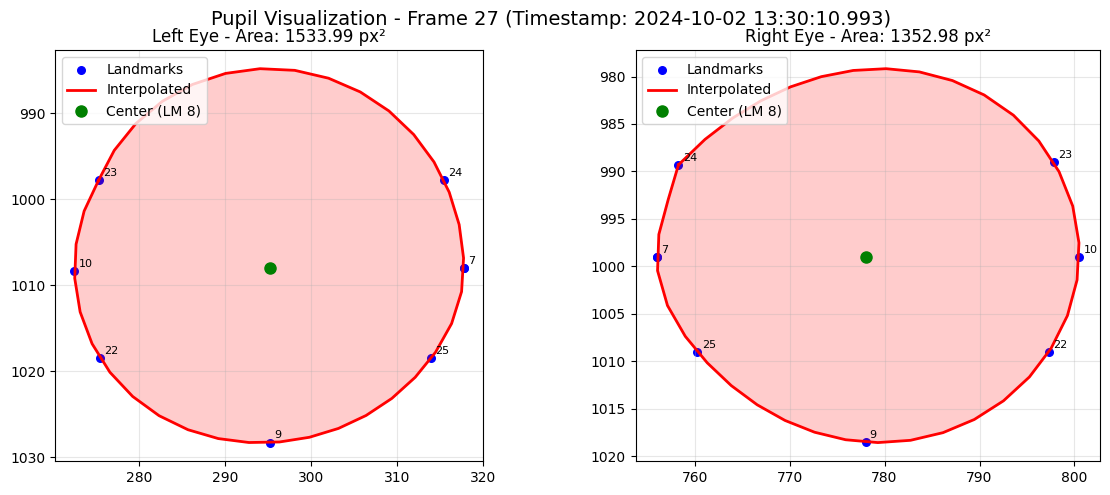

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

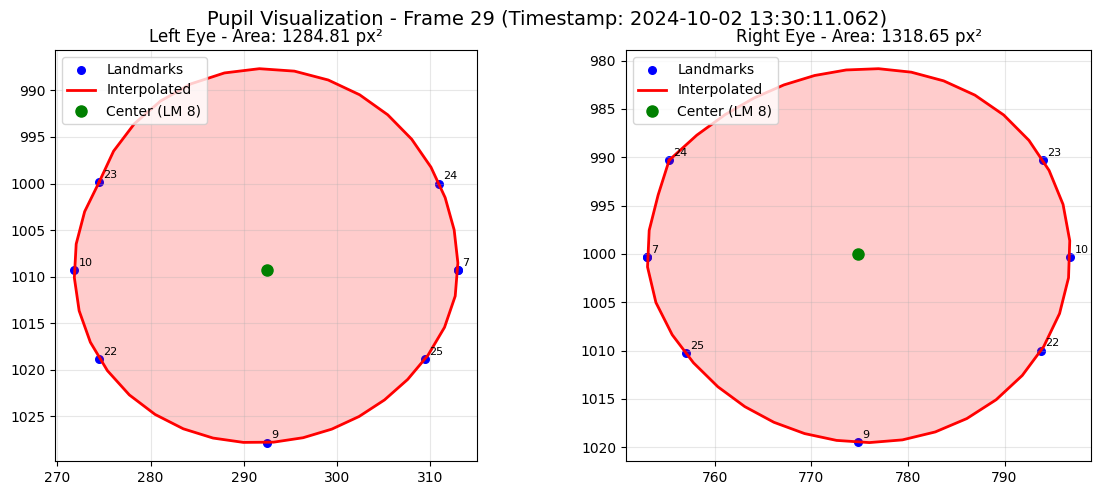

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

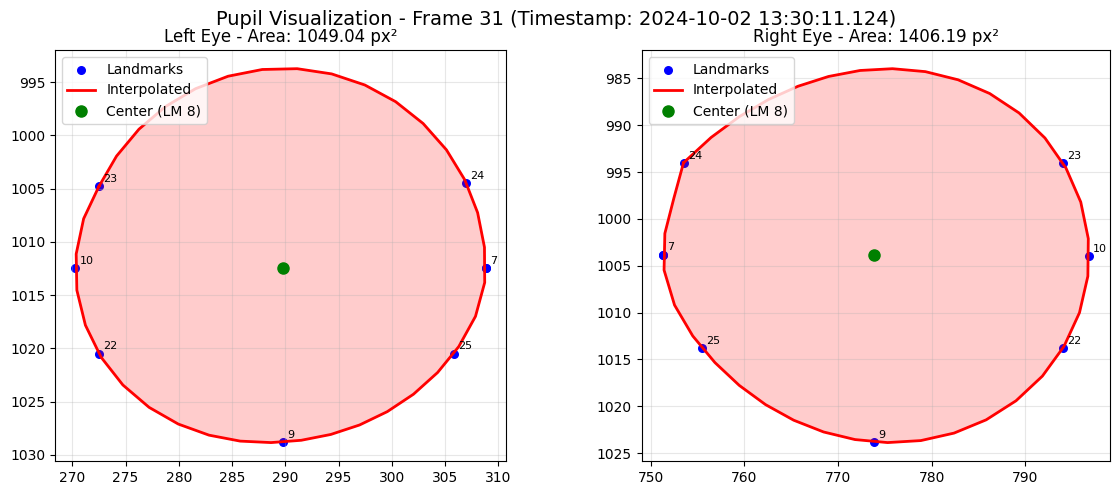

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

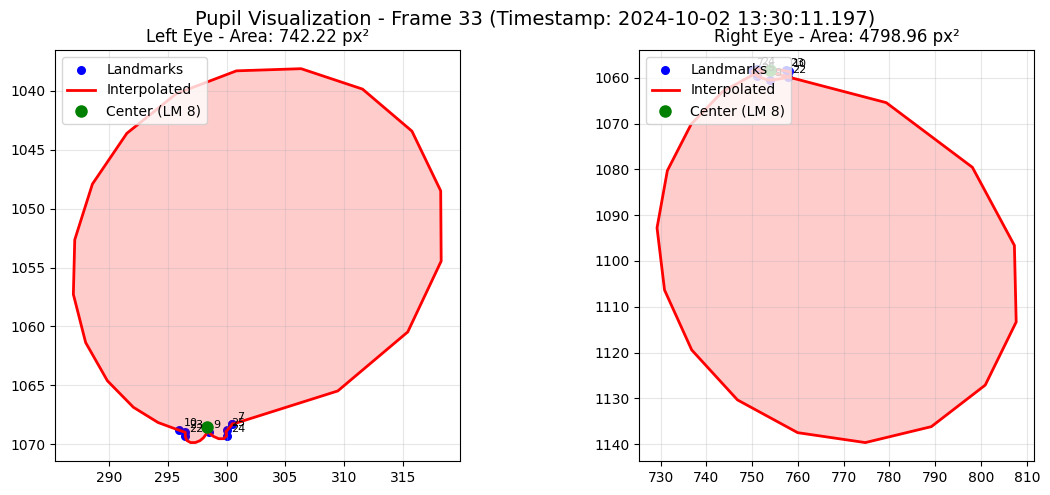

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

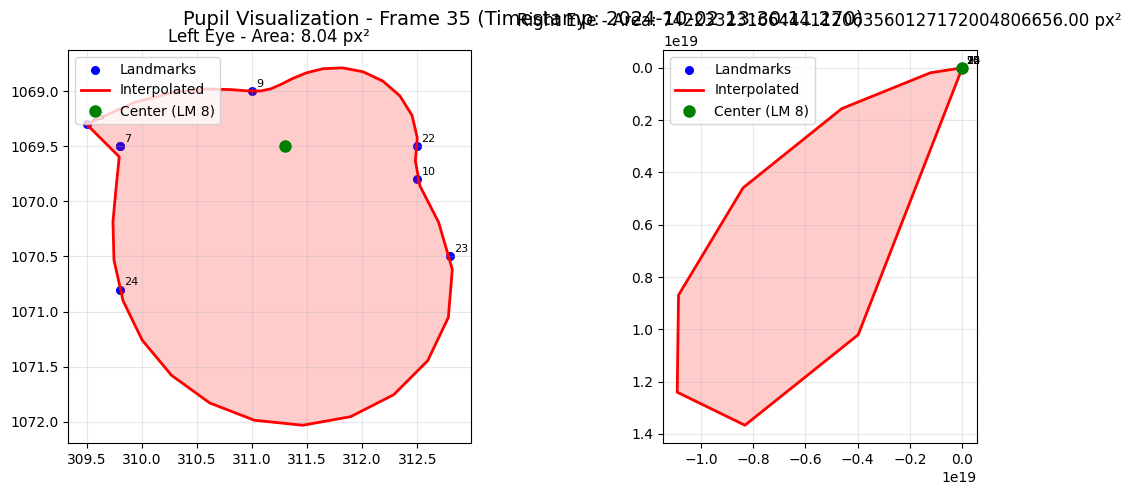

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

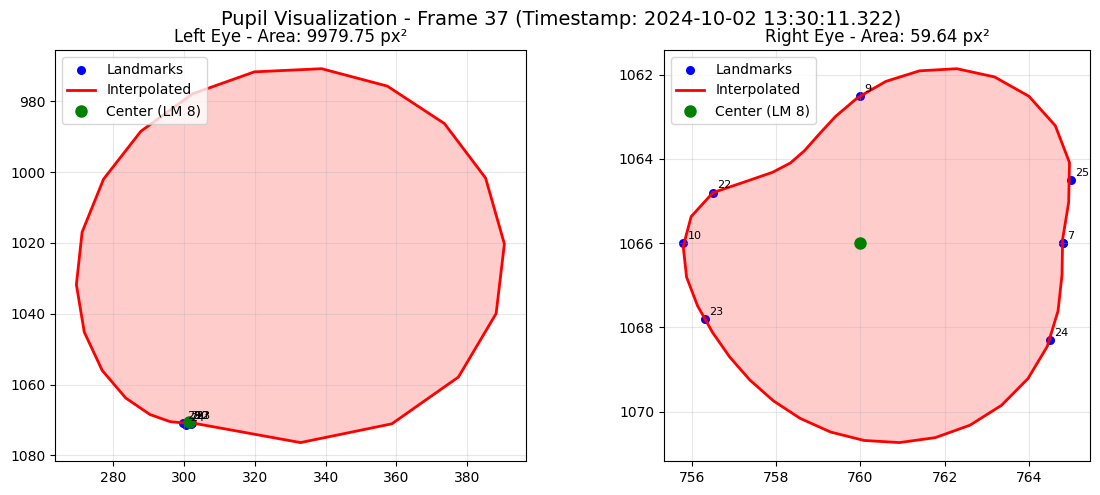

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

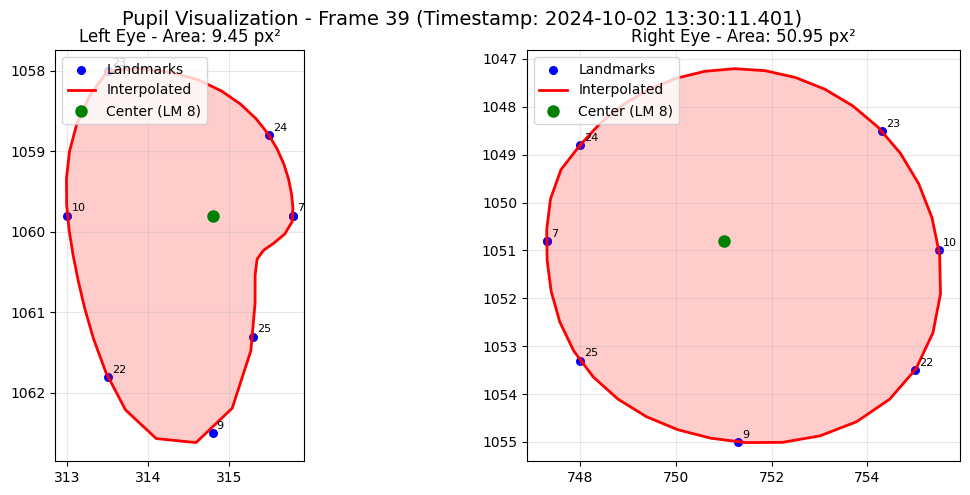

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

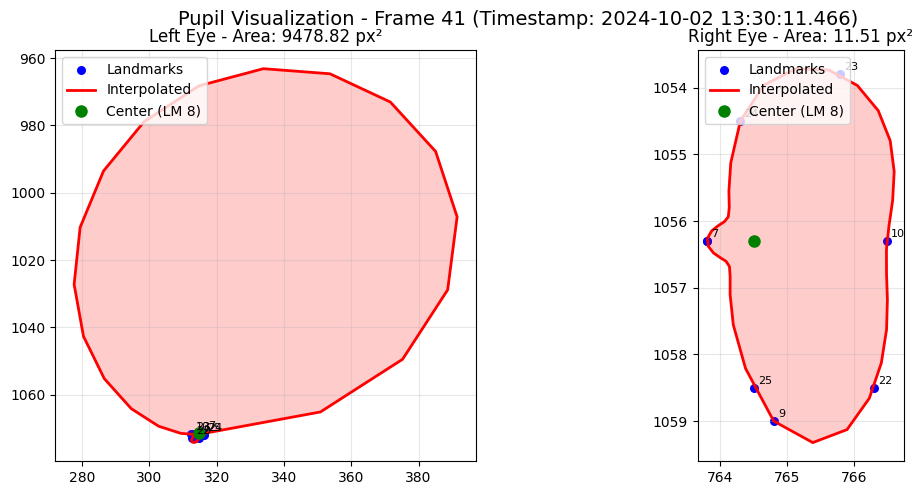

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

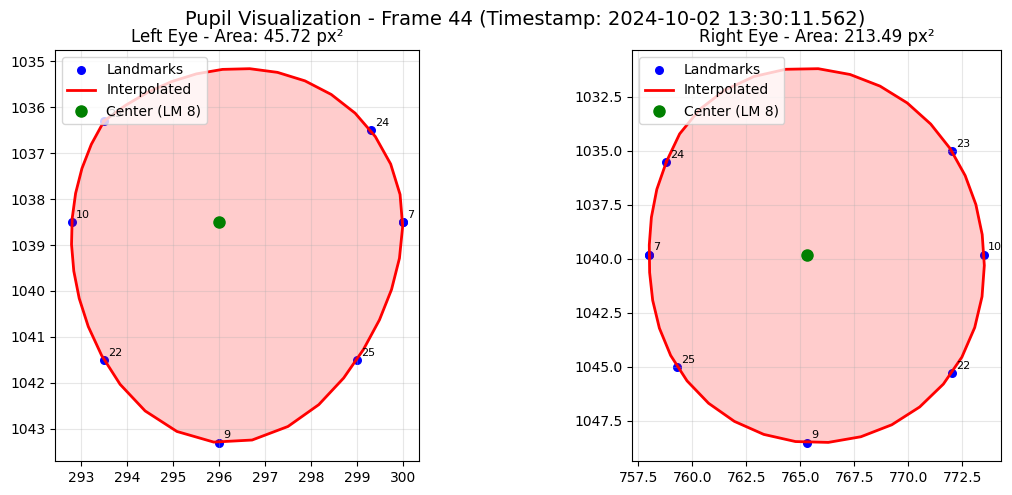

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

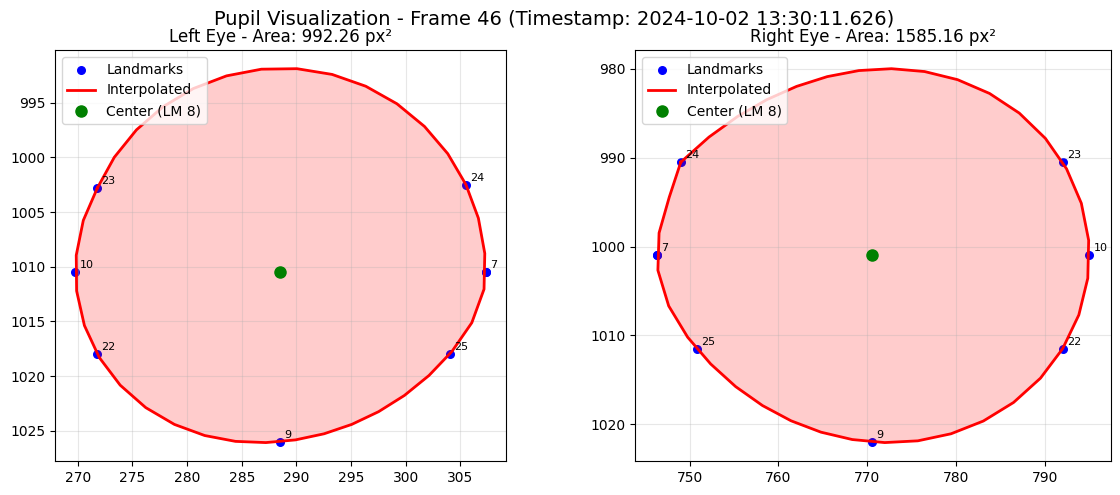

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

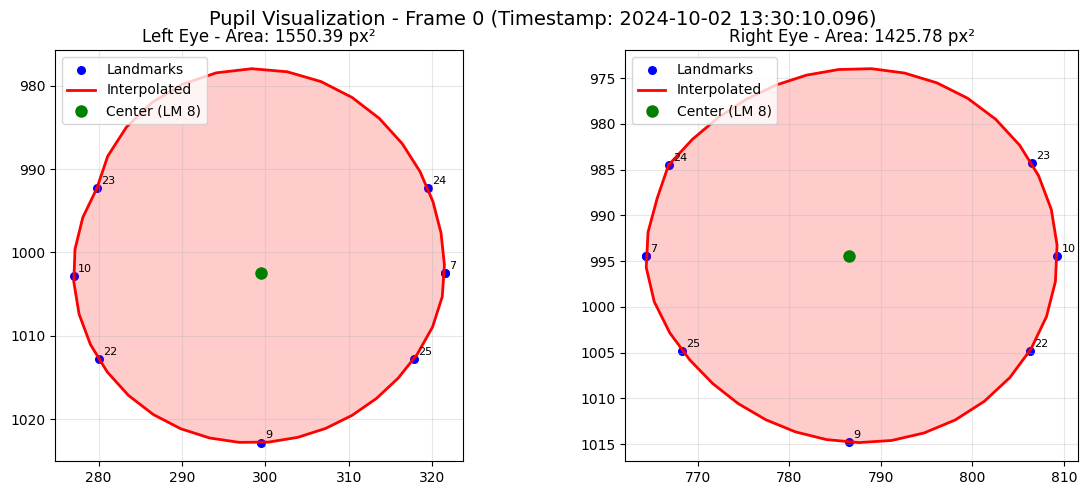

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.interpolate import CubicSpline
from shapely.geometry import Polygon
import matplotlib.patches as patches
from IPython.display import display, clear_output
import ipywidgets as widgets

# Load the data
data_path = '/home/lrn/Repos/analyze-eye-tracking-data/data/4cac0bd4-a541-48db-a20f-13daf9d5bf5d/4cac0bd4-a541-48db-a20f-13daf9d5bf5d_plr_landmarks.csv'
landmarks_df = pd.read_csv(data_path)

# Clean data - keep only valid frames
landmarks_df = landmarks_df[landmarks_df['retcode'] == 'OK'].reset_index(drop=True)

def get_pupil_boundary_points(frame, eye):
    """Extract pupil boundary points for a specific eye and frame"""
    boundary_points = []
    for lm in [7, 25, 9, 22, 10, 23, 24, 7]:  # Pupil landmarks (closing the loop with 7 again)
        x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
        y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
        boundary_points.append((x, y))
    return boundary_points

def get_pupil_center(frame, eye):
    """Get the center point (landmark 8) of the pupil"""
    center_x = frame[f'{eye}_lm_8_x'].iloc[0]
    center_y = frame[f'{eye}_lm_8_y'].iloc[0]
    return center_x, center_y

def interpolate_pupil(center, boundary_points, num_points=36):
    """Create a smooth interpolated pupil boundary using cubic spline"""
    # Convert to polar coordinates relative to center
    points_polar = []
    for p in boundary_points:
        dx = p[0] - center[0]
        dy = p[1] - center[1]
        angle = np.arctan2(dy, dx)
        distance = np.sqrt(dx**2 + dy**2)
        points_polar.append((angle, distance, p))
    
    # Sort by angle
    points_polar.sort(key=lambda pp: pp[0])
    
    # Extract sorted data
    angles = [pp[0] for pp in points_polar]
    distances = [pp[1] for pp in points_polar]
    
    # Handle edge case to ensure proper wrapping
    wrapped_angles = angles.copy()
    wrapped_distances = distances.copy()
    
    # If we don't have full circle coverage, wrap around
    if max(wrapped_angles) - min(wrapped_angles) < 1.9 * np.pi:
        wrapped_angles.append(wrapped_angles[0] + 2 * np.pi)
        wrapped_distances.append(wrapped_distances[0])
    
    # CRITICAL FIX: Ensure strictly increasing sequence by adding a tiny offset to duplicate angles
    eps = 1e-10  # Small epsilon value
    for i in range(1, len(wrapped_angles)):
        if wrapped_angles[i] <= wrapped_angles[i-1]:
            wrapped_angles[i] = wrapped_angles[i-1] + eps
    
    # Create cubic spline with periodic boundary condition
    cs = CubicSpline(wrapped_angles, wrapped_distances, bc_type='not-a-knot')
    
    # Generate smooth interpolated points
    interp_angles = np.linspace(min(wrapped_angles), min(wrapped_angles) + 2*np.pi, num_points, endpoint=False)
    interp_distances = cs(interp_angles)
    
    # Convert back to cartesian coordinates
    interp_points = []
    for angle, dist in zip(interp_angles, interp_distances):
        norm_angle = angle % (2 * np.pi)
        x = center[0] + dist * np.cos(norm_angle)
        y = center[1] + dist * np.sin(norm_angle)
        interp_points.append((x, y))
    
    return interp_points

def calculate_pupil_area(points):
    """Calculate the area of the pupil using Shapely Polygon"""
    polygon = Polygon(points)
    return polygon.area





# Pre-calculate pupil sizes and interpolated polygons for all frames
total_frames = len(landmarks_df)
frames = []
pupil_areas = {'left': [], 'right': []}
interpolated_polygons = {'left': [], 'right': []}

for i in range(total_frames):
    frame = landmarks_df.iloc[[i]]
    frames.append(frame)
    
    for eye in ['left', 'right']:
        # Get center and boundary points
        center = get_pupil_center(frame, eye)
        boundary_points = get_pupil_boundary_points(frame, eye)
        
        # Get interpolated polygon
        interp_polygon = interpolate_pupil((center[0], center[1]), boundary_points)
        interpolated_polygons[eye].append(interp_polygon)
        
        # Calculate and store pupil area
        area = calculate_pupil_area(interp_polygon)
        pupil_areas[eye].append(area)

# Create the interactive widget for frame selection
def update_plot(frame_idx):
    """Update the eye plots for the given frame index"""
    frame_idx = int(frame_idx)
    
    # Clear previous plot
    plt.clf()
    
    # Set up the figure with two subplots (left and right eyes)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Add title with frame information
    fig.suptitle(f"Pupil Visualization - Frame {frame_idx} (Timestamp: {landmarks_df.iloc[frame_idx]['timestamp']})", fontsize=14)
    
    # Plot both eyes
    for i, eye in enumerate(['left', 'right']):
        ax = axes[i]
        
        # Get data for this frame
        current_frame = frames[frame_idx]
        center = get_pupil_center(current_frame, eye)
        boundary_points = get_pupil_boundary_points(current_frame, eye)
        interp_polygon = interpolated_polygons[eye][frame_idx]
        area = pupil_areas[eye][frame_idx]
        
        # Extract x, y coordinates
        boundary_x, boundary_y = zip(*boundary_points)
        interp_x, interp_y = zip(*interp_polygon)
        
        # Plot the original boundary points
        ax.scatter(boundary_x, boundary_y, color='blue', s=30, label='Landmarks')
        
        # Plot the interpolated polygon
        ax.fill(interp_x, interp_y, alpha=0.2, color='red')
        ax.plot(interp_x + (interp_x[0],), interp_y + (interp_y[0],), 'r-', linewidth=2, label='Interpolated')
        
        # Plot the center point
        ax.plot(center[0], center[1], 'go', markersize=8, label='Center (LM 8)')
        
        # Annotate landmark numbers
        landmark_indices = [7, 25, 9, 22, 10, 23, 24]
        for j, lm in enumerate(landmark_indices):
            x = current_frame[f'{eye}_lm_{lm}_x'].iloc[0]
            y = current_frame[f'{eye}_lm_{lm}_y'].iloc[0]
            ax.annotate(str(lm), (x, y), fontsize=8, xytext=(3, 3), textcoords='offset points')
        
        # Set title with area information
        ax.set_title(f"{eye.capitalize()} Eye - Area: {area:.2f} px²")
        
        # Set axis properties
        ax.set_aspect('equal')
        ax.invert_yaxis()  # Invert y-axis to match image coordinates
        ax.grid(alpha=0.3)
        
        # Add legend
        ax.legend(loc='upper left')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Create a second plot for pupil size over time
def plot_pupil_size_over_time():
    """Create a static plot showing pupil size for both eyes over all frames"""
    plt.figure(figsize=(12, 6))
    
    # Plot the area for both eyes
    frame_indices = list(range(total_frames))
    plt.plot(frame_indices, pupil_areas['left'], 'b-', label='Left Eye')
    plt.plot(frame_indices, pupil_areas['right'], 'r-', label='Right Eye')
    
    # Mark the current frame with vertical line (will be updated interactively)
    marker_line = plt.axvline(x=0, color='green', linestyle='--', label='Current Frame')
    
    # Add labels and title
    plt.xlabel('Frame Index')
    plt.ylabel('Pupil Area (pixels²)')
    plt.title('Pupil Size Over Time')
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Return the marker line for updating
    return marker_line

# This should be a separate function that handles preprocessing
def preprocess_landmarks_data(landmarks_file_path):
    """
    Load, clean, and preprocess landmarks data
    
    Args:
        landmarks_file_path (str): Path to landmarks CSV file
        
    Returns:
        tuple: (landmarks_df, pupil_areas, interpolated_polygons)
    """
    # Load the data
    landmarks_df = pd.read_csv(landmarks_file_path)
    
    # Clean data - keep only valid frames
    landmarks_df = landmarks_df[landmarks_df['retcode'] == 'OK'].reset_index(drop=True)
    
    # Pre-calculate pupil sizes and interpolated polygons
    total_frames = len(landmarks_df)
    frames = []
    pupil_areas = {'left': [], 'right': []}
    interpolated_polygons = {'left': [], 'right': []}
    
    for i in range(total_frames):
        frame = landmarks_df.iloc[[i]]
        frames.append(frame)
        
        for eye in ['left', 'right']:
            # Get center and boundary points
            center = get_pupil_center(frame, eye)
            boundary_points = get_pupil_boundary_points(frame, eye)
            
            # Get interpolated polygon
            interp_polygon = interpolate_pupil((center[0], center[1]), boundary_points)
            interpolated_polygons[eye].append(interp_polygon)
            
            # Calculate and store pupil area
            area = calculate_pupil_area(interp_polygon)
            pupil_areas[eye].append(area)
            
    return landmarks_df, frames, pupil_areas, interpolated_polygons


# This function focuses only on interactive visualization
def create_interactive_visualization(landmarks_df, frames, pupil_areas, interpolated_polygons):
    """
    Create interactive visualization for pupil data
    
    Args:
        landmarks_df (pd.DataFrame): Processed landmarks data
        frames (list): List of frames
        pupil_areas (dict): Dictionary with pupil area data
        interpolated_polygons (dict): Dictionary with interpolated polygons
    """
    total_frames = len(landmarks_df)
    
    # Create the figure for pupil size over time
    plt.figure(figsize=(12, 6))
    frame_indices = list(range(total_frames))
    plt.plot(frame_indices, pupil_areas['left'], 'b-', label='Left Eye')
    plt.plot(frame_indices, pupil_areas['right'], 'r-', label='Right Eye')
    
    # Create a vertical line marker
    marker_line = plt.axvline(x=0, color='green', linestyle='--', label='Current Frame')
    
    plt.xlabel('Frame Index')
    plt.ylabel('Pupil Area (pixels²)')
    plt.title('Pupil Size Over Time')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Create the interactive slider
    def on_frame_change(change):
        new_frame = change['new']
        # Update pupil visualization
        update_plot(new_frame)
        # Update marker position
        marker_line.set_xdata([new_frame, new_frame])
        plt.draw()
    
    # Create the slider widget
    frame_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=total_frames-1,
        step=1,
        description='Frame:',
        continuous_update=False,
        layout=widgets.Layout(width='80%')
    )
    
    # Display controls and initial plot
    display(frame_slider)
    update_plot(0)
    
    # Register callback for slider changes
    frame_slider.observe(on_frame_change, names='value')
    
    # Add buttons for play/pause functionality
    play_button = widgets.Play(
        value=0,
        min=0,
        max=total_frames-1,
        step=1,
        interval=200,  # ms between frames
        description="Play",
        disabled=False
    )
    
    # Link play button to slider
    widgets.jslink((play_button, 'value'), (frame_slider, 'value'))
    
    display(widgets.HBox([play_button, frame_slider]))
    
# First process the data (done once)
landmarks_df, frames, pupil_areas, interpolated_polygons = preprocess_landmarks_data(data_path)

# Then create the visualization (using pre-processed data)
create_interactive_visualization(landmarks_df, frames, pupil_areas, interpolated_polygons)

In [77]:
def process_landmarks(landmarks_file, use_interpolation=True, num_frames=None):
    """
    Main function to process landmarks file and calculate pupil sizes
    
    Args:
        landmarks_file (str): Path to landmarks CSV file
        use_interpolation (bool): Whether to use spline interpolation for pupil boundary
        num_frames (int, optional): Number of frames to process (None for all)
        
    Returns:
        tuple: (results_df, all_interpolated_polygons)
    """
    # Load and clean data
    landmarks_df = pd.read_csv(landmarks_file)
    landmarks_df = landmarks_df[landmarks_df['retcode'] == 'OK'].reset_index(drop=True)
    
    print(f"Processing {len(landmarks_df) if num_frames is None else min(num_frames, len(landmarks_df))} frames")
    
    # Calculate pupil sizes for all frames
    results_df, all_interpolated_polygons = calculate_pupil_sizes_for_all_frames(
        landmarks_df, use_interpolation=use_interpolation, num_frames=num_frames)
    
    # Add average size to results DataFrame
    for eye in ['left', 'right']:
        results_df[f'{eye}_pupil_area_avg'] = results_df[f'{eye}_pupil_area'].rolling(
            window=5, min_periods=1).mean()
    
    return results_df, all_interpolated_polygons

def calculate_pupil_sizes_for_all_frames(landmarks_df, use_interpolation=True, num_frames=None):
    """
    Calculate pupil sizes for all frames in the dataset
    
    Args:
        landmarks_df (pd.DataFrame): Landmarks data
        use_interpolation (bool): Whether to use spline interpolation
        num_frames (int, optional): Number of frames to process
        
    Returns:
        tuple: (results DataFrame, dictionary with all interpolated polygons)
    """
    results = []
    all_interpolated_polygons = {'left': [], 'right': []}
    
    # Process only the requested number of frames if specified
    if num_frames is not None:
        landmarks_df = landmarks_df.iloc[:num_frames]
        
    # Process each frame
    for idx, row in landmarks_df.iterrows():
        frame_data = landmarks_df.iloc[[idx]]  # Get as dataframe row
        
        # Calculate left eye
        left_center, left_boundary_points = get_pupil_center_and_points('left', frame_data)
        left_interp_points = interpolate_points(left_center, left_boundary_points)
        left_polygon = Polygon(left_interp_points)
        left_area = left_polygon.area
        
        # Store interpolated polygon
        all_interpolated_polygons['left'].append(left_interp_points)
        
        # Calculate right eye
        right_center, right_boundary_points = get_pupil_center_and_points('right', frame_data)
        right_interp_points = interpolate_points(right_center, right_boundary_points)
        right_polygon = Polygon(right_interp_points)
        right_area = right_polygon.area
        
        # Store interpolated polygon
        all_interpolated_polygons['right'].append(right_interp_points)
        
        # Store results for this frame
        results.append({
            'frame_idx': idx,
            'timestamp': frame_data['timestamp'].iloc[0] if 'timestamp' in frame_data else idx,
            'left_pupil_area': left_area,
            'right_pupil_area': right_area
        })
    
    return pd.DataFrame(results), all_interpolated_polygons

def get_pupil_center_and_points(eye, frame):
    """
    Extract pupil center and boundary points for an eye
    
    Args:
        eye (str): 'left' or 'right'
        frame (pd.DataFrame): Single frame data
        
    Returns:
        tuple: (center, boundary_points)
    """
    # Get center (landmark 8)
    center_x = frame[f'{eye}_lm_8_x'].iloc[0]
    center_y = frame[f'{eye}_lm_8_y'].iloc[0]
    center = (center_x, center_y)
    
    # Get boundary points - using pupil landmarks
    boundary_points = []
    for lm in [7, 25, 9, 22, 10, 23, 24, 7]:  # Pupil landmarks
        x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
        y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
        boundary_points.append((x, y))
    
    return center, boundary_points

def interpolate_points(center, boundary_points, num_interpolated=36):
    """
    Create smooth interpolated points around pupil using cubic spline
    
    Args:
        center (tuple): (x, y) coordinates of pupil center
        boundary_points (list): List of (x, y) coordinates of boundary points
        num_interpolated (int): Number of points in interpolated polygon
        
    Returns:
        list: Interpolated points forming a smooth polygon
    """
    from scipy.interpolate import CubicSpline
    
    # Convert to polar coordinates
    points_polar = []
    for p in boundary_points:
        dx = p[0] - center[0]
        dy = p[1] - center[1]
        angle = np.arctan2(dy, dx)
        distance = np.sqrt(dx**2 + dy**2)
        points_polar.append((angle, distance, p))
    
    # Sort by angle
    points_polar.sort(key=lambda pp: pp[0])
    
    # Extract sorted data
    original_angles = [pp[0] for pp in points_polar]
    original_distances = [pp[1] for pp in points_polar]
    
        # Check for duplicate angles or angles that are too close
    # Add a small epsilon to each angle to ensure strict increasing order
    eps = 1e-10
    for i in range(1, len(original_angles)):
        if original_angles[i] <= original_angles[i-1]:
            original_angles[i] = original_angles[i-1] + eps
    
    
    # Wrap around for circular interpolation
    wrapped_angles = original_angles.copy()
    wrapped_distances = original_distances.copy()
    
    print(f"1 {wrapped_angles=}")
    if max(wrapped_angles) - min(wrapped_angles) < 1.9 * np.pi:
        wrapped_angles.append(wrapped_angles[0] + 2 * np.pi)
        wrapped_distances.append(wrapped_distances[0])

        # Check if the sequence is strictly increasing
    for i in range(1, len(wrapped_angles)):
        if wrapped_angles[i] <= wrapped_angles[i-1]:
            wrapped_angles[i] = wrapped_angles[i-1] + eps
    
    print(f"2 {wrapped_angles=}")
    # # Ensure angles are in the range [-π, π]
    # wrapped_angles = [(angle + np.pi) % (2 * np.pi) - np.pi for angle in wrapped_angles]
    # print(f"3 {wrapped_angles=}")
    # # Ensure distances are in the same order as angles
    # wrapped_distances = [wrapped_distances[i] for i in range(len(wrapped_angles))]
    # print(f"4 {wrapped_distances=}")
    
    
        
    # Create cubic spline
    cs = CubicSpline(wrapped_angles, wrapped_distances, bc_type='not-a-knot')
    
    # Generate interpolated points
    interp_angles = np.linspace(min(wrapped_angles), min(wrapped_angles) + 2*np.pi, 
                                num_interpolated, endpoint=False)
    interp_distances = cs(interp_angles)
    
    # Convert back to Cartesian coordinates
    interp_points = []
    for angle, dist in zip(interp_angles, interp_distances):
        norm_angle = ((angle + np.pi) % (2 * np.pi)) - np.pi
        x = center[0] + dist * np.cos(norm_angle)
        y = center[1] + dist * np.sin(norm_angle)
        interp_points.append((x, y))
    
    return interp_points


def visualize_pupil_size_over_time(results_df, save_path=None):
    """
    Visualize pupil size over time with average
    
    Args:
        results_df (pd.DataFrame): DataFrame with pupil sizes
        save_path (str, optional): Path to save the figure
    """
    plt.figure(figsize=(14, 7))
    
    # Plot individual measurements
    plt.scatter(results_df['frame_idx'], results_df['left_pupil_area'], 
                color='blue', alpha=0.3, s=10, label='Left Eye')
    plt.scatter(results_df['frame_idx'], results_df['right_pupil_area'], 
                color='red', alpha=0.3, s=10, label='Right Eye')
    
    # Plot moving averages
    plt.plot(results_df['frame_idx'], results_df['left_pupil_area_avg'], 
             color='blue', linewidth=2, label='Left Eye (Average)')
    plt.plot(results_df['frame_idx'], results_df['right_pupil_area_avg'], 
             color='red', linewidth=2, label='Right Eye (Average)')
    
    # Add horizontal lines for overall averages
    left_avg = results_df['left_pupil_area'].mean()
    right_avg = results_df['right_pupil_area'].mean()
    plt.axhline(y=left_avg, color='blue', linestyle='--', 
                label=f'Left Eye Mean: {left_avg:.2f} px²')
    plt.axhline(y=right_avg, color='red', linestyle='--', 
                label=f'Right Eye Mean: {right_avg:.2f} px²')
    
    plt.title('Pupil Size Over Time')
    plt.xlabel('Frame Index')
    plt.ylabel('Pupil Area (pixels²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def visualize_all_pupil_polygons(all_interpolated_polygons, save_path=None):
    """
    Visualize all pupil polygons on the same plot with darker colors
    
    Args:
        all_interpolated_polygons (dict): Dictionary with all interpolated polygons
        save_path (str, optional): Path to save the figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    for i, eye in enumerate(['left', 'right']):
        ax = axes[i]
        eye_polygons = all_interpolated_polygons[eye]
        
        # Plot each polygon with increasing opacity
        num_polygons = len(eye_polygons)
        for j, polygon in enumerate(eye_polygons):
            x, y = zip(*polygon)
            
            # Determine opacity based on frame number (later frames are darker)
            alpha = 0.05 + (j / num_polygons) * 0.5
            color = 'blue' if eye == 'left' else 'red'
            
            # Close the polygon
            x_closed = list(x) + [x[0]]
            y_closed = list(y) + [y[0]]
            
            ax.plot(x_closed, y_closed, color=color, alpha=alpha, linewidth=0.5)
        
        # Plot average polygon with thick line
        if eye_polygons:
            # Calculate average polygon
            avg_x = np.zeros(len(eye_polygons[0]))
            avg_y = np.zeros(len(eye_polygons[0]))
            
            for polygon in eye_polygons:
                for k, (x, y) in enumerate(polygon):
                    avg_x[k] += x
                    avg_y[k] += y
            
            avg_x /= len(eye_polygons)
            avg_y /= len(eye_polygons)
            
            # Close the average polygon
            avg_x_closed = np.append(avg_x, avg_x[0])
            avg_y_closed = np.append(avg_y, avg_y[0])
            
            ax.plot(avg_x_closed, avg_y_closed, color=color, linewidth=2, 
                   label='Average Polygon')
            
            # Calculate and show average area
            avg_polygon = Polygon(zip(avg_x, avg_y))
            avg_area = avg_polygon.area
            ax.set_title(f'{eye.capitalize()} Eye Pupils\nAverage Area: {avg_area:.2f} px²')
        
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()
        
def analyze_pupil_tracking(landmarks_file, output_dir=None):
    """
    Complete pupil analysis workflow
    
    Args:
        landmarks_file (str): Path to landmarks CSV file
        output_dir (str, optional): Directory to save output visualizations
    
    Returns:
        tuple: (results_df, all_interpolated_polygons) - Analysis results
    """
    import os
    
    # 1. Process all frames and calculate pupil sizes
    results_df, all_interpolated_polygons = process_landmarks(landmarks_file)
    
    # 2. Create output directory if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # 3. Visualize pupil size over time
    size_plot_path = os.path.join(output_dir, 'pupil_size_over_time.png') if output_dir else None
    visualize_pupil_size_over_time(results_df, save_path=size_plot_path)
    
    # 4. Visualize all pupil polygons
    polygons_plot_path = os.path.join(output_dir, 'all_pupil_polygons.png') if output_dir else None
    visualize_all_pupil_polygons(all_interpolated_polygons, save_path=polygons_plot_path)
    
    # 5. Save results data if output directory is specified
    if output_dir:
        results_csv_path = os.path.join(output_dir, 'pupil_sizes.csv')
        results_df.to_csv(results_csv_path, index=False)
        print(f"Results saved to: {output_dir}")
    
    return results_df, all_interpolated_polygons

if __name__ == "__main__":
    # Set the landmarks file path
    landmarks_file = "../data/4cac0bd4-a541-48db-a20f-13daf9d5bf5d/4cac0bd4-a541-48db-a20f-13daf9d5bf5d_plr_landmarks.csv"
    
    # Set output directory for visualizations and results
    output_dir = "../output/pupil_analysis_results"
    
    # Run the complete analysis
    results, polygons = analyze_pupil_tracking(landmarks_file, output_dir)
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Left Pupil - Mean Area: {results['left_pupil_area'].mean():.2f} pixels²")
    print(f"Right Pupil - Mean Area: {results['right_pupil_area'].mean():.2f} pixels²")
    print(f"Correlation between eyes: {results['left_pupil_area'].corr(results['right_pupil_area']):.4f}")

Processing 239 frames
1 wrapped_angles=[np.float64(-2.6638330782258604), np.float64(-0.47161556786232944), np.float64(0.0), np.float64(1e-10), np.float64(0.512648863677161), np.float64(1.5707963267948966), np.float64(2.6556363729370496), np.float64(3.1282601102956495)]
2 wrapped_angles=[np.float64(-2.6638330782258604), np.float64(-0.47161556786232944), np.float64(0.0), np.float64(1e-10), np.float64(0.512648863677161), np.float64(1.5707963267948966), np.float64(2.6556363729370496), np.float64(3.1282601102956495), np.float64(3.619352228953726)]
1 wrapped_angles=[np.float64(-2.671872244748884), np.float64(-0.47161556786232944), np.float64(0.0), np.float64(0.479678299782637), np.float64(1.5707963267948966), np.float64(2.6265983541587925), np.float64(3.141592653589793), np.float64(3.141592653689793)]
2 wrapped_angles=[np.float64(-2.671872244748884), np.float64(-0.47161556786232944), np.float64(0.0), np.float64(0.479678299782637), np.float64(1.5707963267948966), np.float64(2.6265983541587925

In [62]:

def process_landmarks_file(landmarks_file, output_dir=None, window_size=5, num_frames=None):
    """
    Process a landmarks CSV file to analyze pupil sizes and generate visualizations
    with interpolated pupil boundaries
    
    Args:
        landmarks_file (str): Path to the landmarks CSV file
        output_dir (str, optional): Directory to save output files, if None will display instead
        window_size (int): Window size for moving averages
        num_frames (int, optional): Number of frames to process (None for all)
        
    Returns:
        tuple: (Results DataFrame, Average pupil polygons)
    """
    # Load the landmarks data
    print(f"Loading landmarks data from: {landmarks_file}")
    landmarks_df = pd.read_csv(landmarks_file)
    
    # Filter to valid frames
    landmarks_df = landmarks_df[landmarks_df['retcode'] == 'OK'].copy()
    landmarks_df.reset_index(drop=True, inplace=True)
    
    total_frames = len(landmarks_df) if num_frames is None else min(num_frames, len(landmarks_df))
    print(f"Processing {total_frames} frames out of {len(landmarks_df)} total frames")
    
    # Analyze pupil sizes - explicitly setting use_interpolation to True
    results_df, accumulated_points = analyze_pupil_sizes_with_interpolation(
        landmarks_df, 
        window_size=window_size,
        num_frames=num_frames
    )
    
    # Calculate average pupil polygons
    avg_polygons = calculate_average_interpolated_pupil_polygon(accumulated_points)
    
    # Create visualizations
    if output_dir:
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        # Save pupil size over time visualization
        size_plot_path = os.path.join(output_dir, 'pupil_size_over_time.png')
        visualize_pupil_size_over_time(results_df, save_path=size_plot_path)
        print(f"Pupil size over time plot saved to: {size_plot_path}")
        
        # Save average pupil polygons visualization
        polygon_plot_path = os.path.join(output_dir, 'average_pupil_polygons.png')
        visualize_interpolated_pupil_polygons(avg_polygons, save_path=polygon_plot_path)
        print(f"Average pupil polygons plot saved to: {polygon_plot_path}")
        
        # Save results DataFrame to CSV
        results_csv_path = os.path.join(output_dir, 'pupil_size_results.csv')
        results_df.to_csv(results_csv_path, index=False)
        print(f"Results data saved to: {results_csv_path}")
    else:
        # Display visualizations
        print("Showing pupil size over time plot:")
        visualize_pupil_size_over_time(results_df)
        
        print("Showing average pupil shapes:")
        visualize_interpolated_pupil_polygons(avg_polygons)
    
    return results_df, avg_polygons

def analyze_pupil_sizes_with_interpolation(landmarks_df, window_size=5, num_frames=None):
    """
    Analyze pupil sizes across all frames in the landmarks dataframe using cubic spline interpolation
    
    Args:
        landmarks_df (pd.DataFrame): Landmarks data with multiple frames
        window_size (int): Window size for smoothing
        num_frames (int, optional): Number of frames to process (None for all frames)
        
    Returns:
        tuple: (DataFrame with pupil sizes over time, accumulated polygon points)
    """
    # Prepare to store results
    results = []
    
    # Prepare to accumulate interpolated polygon points for averaging
    accumulated_points = {
        'left': {'points': []},
        'right': {'points': []}
    }
    
    # Determine how many frames to process
    if num_frames is None:
        num_frames = len(landmarks_df)
    else:
        num_frames = min(num_frames, len(landmarks_df))
    
    # Process each frame
    for idx in range(num_frames):
        frame = landmarks_df.iloc[[idx]]
        timestamp = frame['timestamp'].iloc[0] if 'timestamp' in frame.columns else idx
        
        # Calculate left eye pupil size using interpolation
        left_center, left_boundary_points = get_pupil_center_and_points('left', frame)
        left_interp_points = interpolate_points(left_center, left_boundary_points, num_interpolated=36)
        left_polygon = Polygon(left_interp_points)
        left_area = left_polygon.area
        
        # Store interpolated points for left eye
        accumulated_points['left']['points'].append(left_interp_points)
        
        # Calculate right eye pupil size using interpolation
        right_center, right_boundary_points = get_pupil_center_and_points('right', frame)
        right_interp_points = interpolate_points(right_center, right_boundary_points, num_interpolated=36)
        right_polygon = Polygon(right_interp_points)
        right_area = right_polygon.area
        
        # Store interpolated points for right eye
        accumulated_points['right']['points'].append(right_interp_points)
        
        # Store results for this frame
        results.append({
            'frame_idx': idx,
            'timestamp': timestamp,
            'left_pupil_area': left_area,
            'right_pupil_area': right_area
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Add smoothed data columns using Savitzky-Golay filter
    if len(results_df) > window_size:
        results_df['left_pupil_area_avg'] = signal.savgol_filter(
            results_df['left_pupil_area'], 
            window_size if window_size % 2 == 1 else window_size + 1,  # Must be odd
            2  # Polynomial order
        )
        results_df['right_pupil_area_avg'] = signal.savgol_filter(
            results_df['right_pupil_area'], 
            window_size if window_size % 2 == 1 else window_size + 1, 
            2
        )
    else:
        # If not enough data for smoothing, use simple moving average
        results_df['left_pupil_area_avg'] = results_df['left_pupil_area'].rolling(
            min(len(results_df), 3), min_periods=1
        ).mean()
        results_df['right_pupil_area_avg'] = results_df['right_pupil_area'].rolling(
            min(len(results_df), 3), min_periods=1
        ).mean()
    
    return results_df, accumulated_points


def calculate_average_interpolated_pupil_polygon(accumulated_points):
    """
    Calculate the average pupil polygon from accumulated interpolated points
    
    Args:
        accumulated_points (dict): Dictionary with accumulated interpolated polygon points
        
    Returns:
        dict: Average pupil polygons for left and right eyes
    """
    avg_polygons = {
        'left': None,
        'right': None
    }
    
    for eye in ['left', 'right']:
        # Get all interpolated points for this eye
        all_interp_polygons = accumulated_points[eye]['points']
        
        if not all_interp_polygons:
            continue
        
        # All interpolated polygons should have the same number of points
        num_points = len(all_interp_polygons[0])
        
        # Check that we have consistent data
        if not all(len(polygon) == num_points for polygon in all_interp_polygons):
            print(f"Warning: Inconsistent number of interpolated points for {eye} eye")
            continue
        
        # Initialize arrays for average coordinates
        avg_x = np.zeros(num_points)
        avg_y = np.zeros(num_points)
        
        # Sum all coordinates
        for polygon in all_interp_polygons:
            for i, (x, y) in enumerate(polygon):
                avg_x[i] += x
                avg_y[i] += y
        
        # Calculate averages
        avg_x /= len(all_interp_polygons)
        avg_y /= len(all_interp_polygons)
        
        # Create the average polygon points
        avg_polygons[eye] = list(zip(avg_x, avg_y))
    
    return avg_polygons


def visualize_interpolated_pupil_polygons(avg_polygons, save_path=None):
    """
    Visualize the average interpolated pupil polygons for both eyes
    
    Args:
        avg_polygons (dict): Average pupil polygons for left and right eyes
        save_path (str, optional): Path to save the figure, if None will display instead
    """
    plt.figure(figsize=(15, 7))
    
    # Create two subplots side by side
    plt.subplot(1, 2, 1)
    
    # Plot left eye average pupil
    if avg_polygons['left']:
        x, y = zip(*avg_polygons['left'])
        # Create smooth closed polygon
        x_closed = np.append(x, x[0])
        y_closed = np.append(y, y[0])
        
        plt.fill(x_closed, y_closed, 'blue', alpha=0.2)
        plt.plot(x_closed, y_closed, 'blue', linewidth=2, label='Interpolated Boundary')
        
        # Find and mark center
        center_x = np.mean(x)
        center_y = np.mean(y)
        plt.plot(center_x, center_y, 'bo', markersize=8, label='Estimated Center')
        
        # Calculate area
        polygon = Polygon(avg_polygons['left'])
        area = polygon.area
        plt.title(f'Left Eye - Average Pupil\nArea: {area:.2f} pixels²')
    else:
        plt.title('Left Eye - No Data')
    
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot right eye average pupil
    plt.subplot(1, 2, 2)
    
    if avg_polygons['right']:
        x, y = zip(*avg_polygons['right'])
        # Create smooth closed polygon
        x_closed = np.append(x, x[0])
        y_closed = np.append(y, y[0])
        
        plt.fill(x_closed, y_closed, 'red', alpha=0.2)
        plt.plot(x_closed, y_closed, 'red', linewidth=2, label='Interpolated Boundary')
        
        # Find and mark center
        center_x = np.mean(x)
        center_y = np.mean(y)
        plt.plot(center_x, center_y, 'ro', markersize=8, label='Estimated Center')
        
        # Calculate area
        polygon = Polygon(avg_polygons['right'])
        area = polygon.area
        plt.title(f'Right Eye - Average Pupil\nArea: {area:.2f} pixels²')
    else:
        plt.title('Right Eye - No Data')
    
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.suptitle('Average Pupil Shape Using Cubic Spline Interpolation', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the suptitle
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


if __name__ == "__main__":
    
    landmarks_file = "../data/4cac0bd4-a541-48db-a20f-13daf9d5bf5d/4cac0bd4-a541-48db-a20f-13daf9d5bf5d_plr_landmarks.csv"
    output_dir = "../output/interpolated_pupil_analysis"
    
    # Process the landmarks file with interpolated pupil calculation
    results_df, avg_polygons = process_landmarks_file(
        landmarks_file,
        output_dir=output_dir,
        window_size=7,  # Use larger window for smoother averaging
        num_frames=None  # Process all frames
    )
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Left Pupil - Mean Area: {results_df['left_pupil_area'].mean():.2f} pixels²")
    print(f"Right Pupil - Mean Area: {results_df['right_pupil_area'].mean():.2f} pixels²")
    
    # Calculate the correlation between left and right pupil sizes
    correlation = results_df['left_pupil_area'].corr(results_df['right_pupil_area'])
    print(f"Correlation between eyes: {correlation:.4f}")

Loading landmarks data from: ../data/4cac0bd4-a541-48db-a20f-13daf9d5bf5d/4cac0bd4-a541-48db-a20f-13daf9d5bf5d_plr_landmarks.csv
Processing 239 frames out of 239 total frames


NameError: name 'get_pupil_center_and_points' is not defined

Loading data from /home/lrn/Repos/analyze-eye-tracking-data/data/4cac0bd4-a541-48db-a20f-13daf9d5bf5d/4cac0bd4-a541-48db-a20f-13daf9d5bf5d_plr_landmarks.csv...
Processing 272 frames...


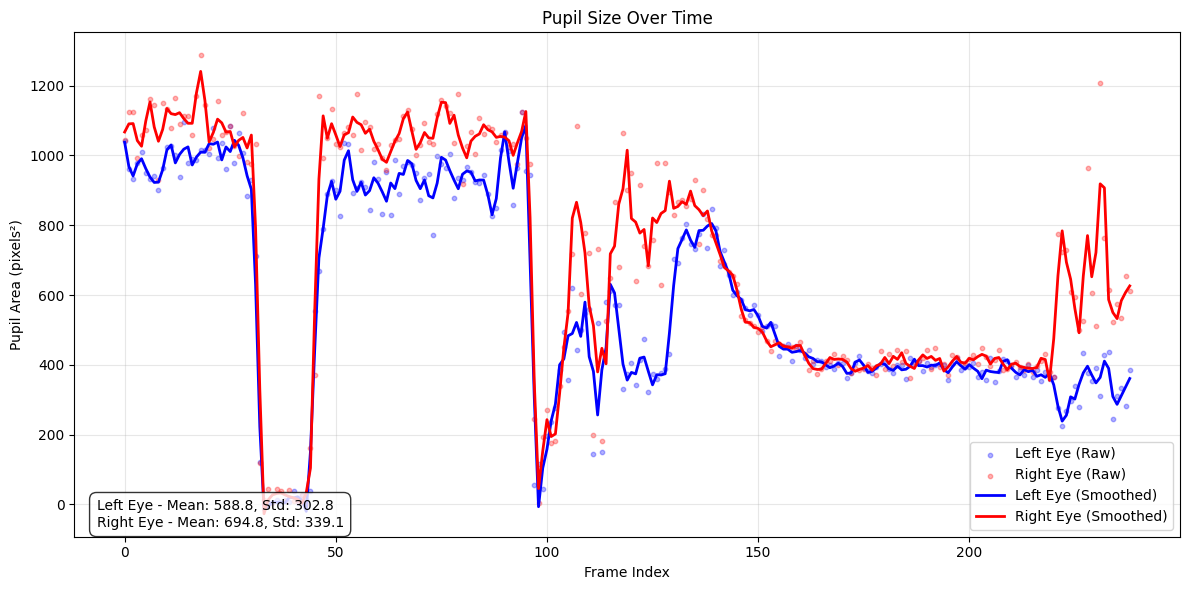

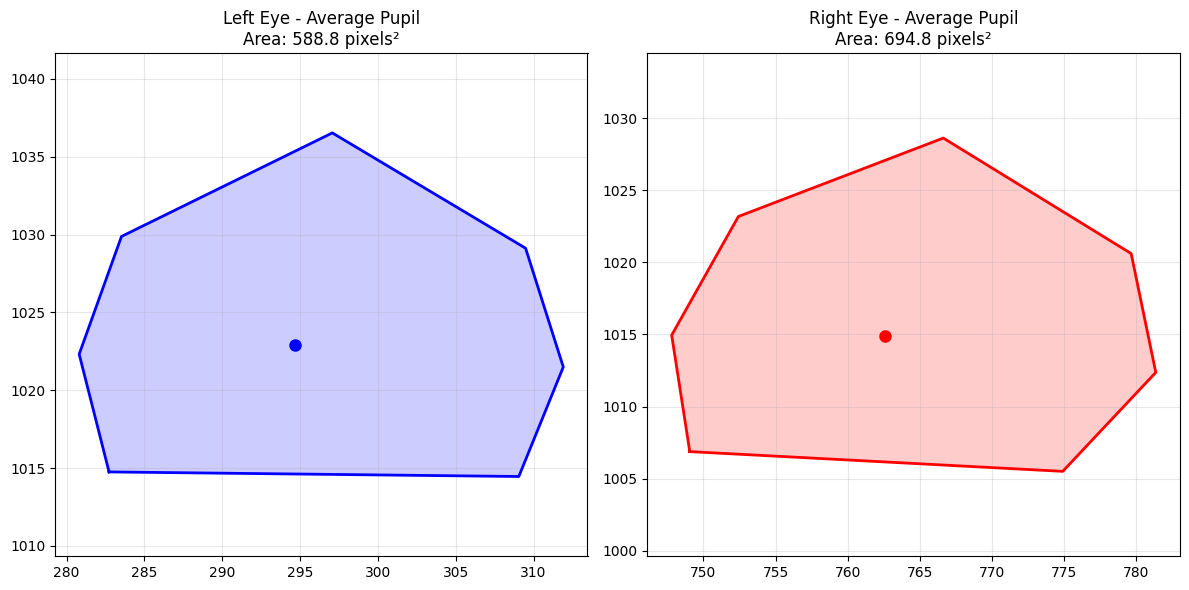


Summary Statistics:
Left Eye - Average Area: 588.85 pixels²
Right Eye - Average Area: 694.84 pixels²
Correlation between eyes: 0.8877


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy import signal
import math

def analyze_pupil_sizes(landmarks_file, window_size=5):
    """
    Analyze pupil sizes across all frames in the landmarks CSV file
    
    Args:
        landmarks_file (str): Path to the landmarks CSV file
        window_size (int): Window size for smoothing
        
    Returns:
        tuple: (results DataFrame, average pupil polygons)
    """
    print(f"Loading data from {landmarks_file}...")
    landmarks_df = pd.read_csv(landmarks_file)
    
    # Prepare results structure
    results = {
        'frame_idx': [],
        'timestamp': [],
        'left_pupil_area': [],
        'right_pupil_area': []
    }
    
    # For storing polygon points to calculate average shapes
    accumulated_points = {
        'left': {'x': [], 'y': []},
        'right': {'x': [], 'y': []}
    }
    
    print(f"Processing {len(landmarks_df)} frames...")
    
    # Process each frame
    for idx, frame in landmarks_df.iterrows():
        # Skip invalid frames
        if frame['retcode'] != 'OK':
            continue
            
        # Store frame info
        results['frame_idx'].append(idx)
        results['timestamp'].append(frame.get('timestamp', idx))
        
        # Calculate left eye pupil size
        left_area, left_points = calculate_pupil_size(frame, 'left')
        results['left_pupil_area'].append(left_area)
        
        # Store left pupil polygon points
        left_x, left_y = zip(*left_points)
        accumulated_points['left']['x'].append(left_x)
        accumulated_points['left']['y'].append(left_y)
        
        # Calculate right eye pupil size
        right_area, right_points = calculate_pupil_size(frame, 'right')
        results['right_pupil_area'].append(right_area)
        
        # Store right pupil polygon points
        right_x, right_y = zip(*right_points)
        accumulated_points['right']['x'].append(right_x)
        accumulated_points['right']['y'].append(right_y)
    
    # Convert to DataFrame for easier manipulation
    results_df = pd.DataFrame(results)
    
    # Add smoothed data columns using Savitzky-Golay filter
    if len(results_df) > window_size:
        results_df['left_pupil_area_smooth'] = signal.savgol_filter(
            results_df['left_pupil_area'], 
            window_size if window_size % 2 == 1 else window_size + 1,  # Must be odd
            2  # Polynomial order
        )
        results_df['right_pupil_area_smooth'] = signal.savgol_filter(
            results_df['right_pupil_area'], 
            window_size if window_size % 2 == 1 else window_size + 1, 
            2
        )
    else:
        # If not enough data for smoothing, use simple moving average
        results_df['left_pupil_area_smooth'] = results_df['left_pupil_area'].rolling(
            min(len(results_df), 3), min_periods=1
        ).mean()
        results_df['right_pupil_area_smooth'] = results_df['right_pupil_area'].rolling(
            min(len(results_df), 3), min_periods=1
        ).mean()
    
    # Calculate average pupil shapes
    avg_polygons = calculate_average_pupil_polygons(accumulated_points)
    
    # Generate visualizations
    plot_pupil_sizes_over_time(results_df)
    plot_average_pupil_shapes(avg_polygons, results_df)
    
    return results_df, avg_polygons

def calculate_pupil_size(frame, eye_side):
    """
    Calculate the pupil size for a given eye in a single frame
    
    Args:
        frame (pd.Series): Single frame data with landmarks
        eye_side (str): 'left' or 'right'
        
    Returns:
        tuple: (pupil_area, pupil_points)
    """
    # Get pupil points (using the specific landmarks that define the pupil)
    pupil_points = get_pupil_polygon_points(frame, eye_side)
    
    # Create a polygon and calculate its area
    if len(pupil_points) >= 3:  # Need at least 3 points to form a polygon
        polygon = Polygon(pupil_points)
        return polygon.area, pupil_points
    else:
        return 0, pupil_points

def get_pupil_polygon_points(frame, eye_side):
    """
    Extract the polygon points that define the pupil
    
    Args:
        frame (pd.Series): Single frame data with landmarks
        eye_side (str): 'left' or 'right'
        
    Returns:
        list: List of (x,y) points defining the pupil
    """
    # Pupil landmark indices 
    # These landmarks form the pupil contour based on the data format
    pupil_indices = [7, 25, 9, 22, 10, 23, 24]
    
    points = []
    for idx in pupil_indices:
        x_col = f"{eye_side}_lm_{idx}_x"
        y_col = f"{eye_side}_lm_{idx}_y"
        if x_col in frame and y_col in frame:
            points.append((frame[x_col], frame[y_col]))
    
    # Get the pupil center (landmark 8)
    center_x = frame[f"{eye_side}_lm_8_x"]
    center_y = frame[f"{eye_side}_lm_8_y"]
    
    # Sort points by angle around center for proper polygon formation
    sorted_points = sorted(points, key=lambda p: 
                          math.atan2(p[1] - center_y, p[0] - center_x))
    
    # Add the first point at the end to close the polygon
    sorted_points.append(sorted_points[0])
    
    return sorted_points

def calculate_average_pupil_polygons(accumulated_points):
    """
    Calculate the average pupil polygon for each eye
    
    Args:
        accumulated_points (dict): Dictionary with points from all frames
        
    Returns:
        dict: Average pupil polygons for left and right eyes
    """
    avg_polygons = {'left': [], 'right': []}
    
    for eye in ['left', 'right']:
        # Check if we have data for this eye
        if not accumulated_points[eye]['x']:
            continue
            
        # Get all x and y arrays
        x_arrays = accumulated_points[eye]['x']
        y_arrays = accumulated_points[eye]['y']
        
        # Make sure all arrays have the same length
        if len(set(len(arr) for arr in x_arrays)) != 1:
            print(f"Warning: Inconsistent number of points for {eye} eye")
            continue
        
        # Calculate average coordinates for each point
        num_points = len(x_arrays[0])
        avg_x = []
        avg_y = []
        
        for i in range(num_points):
            avg_x.append(sum(arr[i] for arr in x_arrays) / len(x_arrays))
            avg_y.append(sum(arr[i] for arr in y_arrays) / len(y_arrays))
        
        # Store the average polygon points
        avg_polygons[eye] = list(zip(avg_x, avg_y))
    
    return avg_polygons

def plot_pupil_sizes_over_time(results_df):
    """
    Plot pupil sizes over time for both eyes
    
    Args:
        results_df (pd.DataFrame): DataFrame with pupil size data
    """
    plt.figure(figsize=(12, 6))
    
    # Plot raw data with small markers
    plt.scatter(results_df['frame_idx'], results_df['left_pupil_area'], 
                color='blue', alpha=0.3, s=10, label='Left Eye (Raw)')
    plt.scatter(results_df['frame_idx'], results_df['right_pupil_area'], 
                color='red', alpha=0.3, s=10, label='Right Eye (Raw)')
    
    # Plot smoothed lines
    plt.plot(results_df['frame_idx'], results_df['left_pupil_area_smooth'], 
             color='blue', linewidth=2, label='Left Eye (Smoothed)')
    plt.plot(results_df['frame_idx'], results_df['right_pupil_area_smooth'], 
             color='red', linewidth=2, label='Right Eye (Smoothed)')
    
    # Calculate statistics for annotation
    left_mean = results_df['left_pupil_area'].mean()
    right_mean = results_df['right_pupil_area'].mean()
    left_std = results_df['left_pupil_area'].std()
    right_std = results_df['right_pupil_area'].std()
    
    # Add statistics annotation
    plt.annotate(f"Left Eye - Mean: {left_mean:.1f}, Std: {left_std:.1f}\n"
                 f"Right Eye - Mean: {right_mean:.1f}, Std: {right_std:.1f}",
                 xy=(0.02, 0.02), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
    
    plt.title('Pupil Size Over Time')
    plt.xlabel('Frame Index')
    plt.ylabel('Pupil Area (pixels²)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_average_pupil_shapes(avg_polygons, results_df):
    """
    Plot the average pupil shapes for both eyes
    
    Args:
        avg_polygons (dict): Average pupil polygons
        results_df (pd.DataFrame): Results with pupil size data
    """
    plt.figure(figsize=(12, 6))
    
    # Plot left eye
    plt.subplot(1, 2, 1)
    if avg_polygons['left']:
        x, y = zip(*avg_polygons['left'])
        plt.fill(x, y, 'blue', alpha=0.2)
        plt.plot(x, y, 'blue', linewidth=2)
        
        # Add center point
        center_x = sum(x) / len(x)
        center_y = sum(y) / len(y)
        plt.plot(center_x, center_y, 'bo', markersize=8)
        
        # Average area
        left_area = results_df['left_pupil_area'].mean()
        plt.title(f'Left Eye - Average Pupil\nArea: {left_area:.1f} pixels²')
    else:
        plt.title('Left Eye - No Data')
    
    plt.axis('equal')
    plt.grid(alpha=0.3)
    
    # Plot right eye
    plt.subplot(1, 2, 2)
    if avg_polygons['right']:
        x, y = zip(*avg_polygons['right'])
        plt.fill(x, y, 'red', alpha=0.2)
        plt.plot(x, y, 'red', linewidth=2)
        
        # Add center point
        center_x = sum(x) / len(x)
        center_y = sum(y) / len(y)
        plt.plot(center_x, center_y, 'ro', markersize=8)
        
        # Average area
        right_area = results_df['right_pupil_area'].mean()
        plt.title(f'Right Eye - Average Pupil\nArea: {right_area:.1f} pixels²')
    else:
        plt.title('Right Eye - No Data')
    
    plt.axis('equal')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    landmarks_file = "/home/lrn/Repos/analyze-eye-tracking-data/data/4cac0bd4-a541-48db-a20f-13daf9d5bf5d/4cac0bd4-a541-48db-a20f-13daf9d5bf5d_plr_landmarks.csv"
    results, avg_shapes = analyze_pupil_sizes(landmarks_file, window_size=5)
    
    print("\nSummary Statistics:")
    print(f"Left Eye - Average Area: {results['left_pupil_area'].mean():.2f} pixels²")
    print(f"Right Eye - Average Area: {results['right_pupil_area'].mean():.2f} pixels²")
    print(f"Correlation between eyes: {results['left_pupil_area'].corr(results['right_pupil_area']):.4f}")

## Signal Quality Analysis
Implement signal quality metrics

In [ ]:
def calculate_signal_quality(pupil_size_series):
    """
    Calculate signal quality metrics
    
    Args:
        pupil_size_series (pd.Series): Pupil size measurements
        
    Returns:
        float: Quality score between 0 and 1
    """
    # Calculate variance and continuity metrics
    variance = np.var(pupil_size_series)
    
    # Calculate signal-to-noise ratio
    # Implementation details here
    
    # Combine metrics into final quality score
    quality_score = 0  # Placeholder
    
    return quality_score

## Noise Reduction
Implement signal smoothing techniques

In [ ]:
def reduce_signal_noise(pupil_size_series):
    """
    Apply noise reduction to pupil size signal
    
    Args:
        pupil_size_series (pd.Series): Raw pupil size measurements
        
    Returns:
        pd.Series: Smoothed signal
    """
    # Apply Savitzky-Golay filter
    window_length = 15  # Must be odd number
    polyorder = 3
    smoothed = signal.savgol_filter(pupil_size_series, window_length, polyorder)
    
    return pd.Series(smoothed, index=pupil_size_series.index)

## Visualization Functions
Create plotting functions for data visualization

In [ ]:
def plot_pupil_response(timestamps, pupil_sizes, protocol_data, quality_score):
    """
    Create visualization of pupil response
    
    Args:
        timestamps (array): Time points
        pupil_sizes (array): Pupil size measurements
        protocol_data (pd.DataFrame): Flash protocol data
        quality_score (float): Signal quality score
    """
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, pupil_sizes, label='Pupil Size')
    
    # Add flash timing indicators
    # Add quality score
    # Add other visualization elements
    
    plt.title(f'Pupil Response (Quality Score: {quality_score:.2f})')
    plt.xlabel('Time (ms)')
    plt.ylabel('Pupil Size (mm)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def analyze_pupil_sizes_over_time(landmarks_df, use_interpolation=True, num_frames=None):
    """
    Analyze pupil sizes across all frames in the landmarks dataframe.
    
    Args:
        landmarks_df (pd.DataFrame): Landmarks data with multiple frames
        use_interpolation (bool): Whether to use interpolation for pupil size calculation
        num_frames (int, optional): Number of frames to process (None for all frames)
        
    Returns:
        tuple: (DataFrame with pupil sizes over time, accumulated polygon points)
    """
    # Prepare to store results
    results = []
    
    # Prepare to accumulate polygon points for averaging
    accumulated_points = {
        'left': {'x': [], 'y': []},
        'right': {'x': [], 'y': []}
    }
    
    # Determine how many frames to process
    if num_frames is None:
        num_frames = len(landmarks_df)
    else:
        num_frames = min(num_frames, len(landmarks_df))
    
    # Process each frame
    for idx in range(num_frames):
        frame = landmarks_df.iloc[[idx]]
        timestamp = frame['timestamp'].iloc[0]
        
        if use_interpolation:
            left_area, right_area = calculate_pupil_size_with_interpolation(frame)
            
            # Get interpolated polygon points for accumulation
            for eye in ['left', 'right']:
                center, boundary_points = get_pupil_center_and_points(eye, frame)
                interp_points = interpolate_points(center, boundary_points, num_interpolated=36)
                
                # Extract x,y coordinates and accumulate
                x_coords, y_coords = zip(*interp_points)
                accumulated_points[eye]['x'].append(x_coords)
                accumulated_points[eye]['y'].append(y_coords)
        else:
            left_area, right_area = calculate_pupil_size(frame)
            
            # Get regular polygon points for accumulation (simplified for consistency)
            for eye in ['left', 'right']:
                polygon_points = get_regular_pupil_points(eye, frame)
                x_coords, y_coords = zip(*polygon_points)
                accumulated_points[eye]['x'].append(x_coords)
                accumulated_points[eye]['y'].append(y_coords)
        
        # Store results for this frame
        results.append({
            'frame_idx': idx,
            'timestamp': timestamp,
            'left_pupil_area': left_area,
            'right_pupil_area': right_area
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Add moving average columns
    window_size = min(5, len(results_df))
    results_df['left_pupil_area_avg'] = results_df['left_pupil_area'].rolling(window=window_size, min_periods=1).mean()
    results_df['right_pupil_area_avg'] = results_df['right_pupil_area'].rolling(window=window_size, min_periods=1).mean()
    
    return results_df, accumulated_points

def get_pupil_center_and_points(eye, frame):
    """Extract pupil center and boundary points for a specific eye"""
    # Get center (landmark 8)
    center_x = frame[f'{eye}_lm_8_x'].iloc[0]
    center_y = frame[f'{eye}_lm_8_y'].iloc[0]
    center = (center_x, center_y)
    
    # Get known boundary points - using all the relevant pupil landmarks
    boundary_points = []
    for lm in [7, 25, 9, 22, 10, 23, 24]:  # Include all pupil landmarks
        x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
        y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
        boundary_points.append((x, y))
        
    return center, boundary_points

def interpolate_points(center, boundary_points, num_interpolated=36):
    """
    Interpolate points while ensuring all original boundary points are included
    
    Args:
        center: Tuple of (x, y) coordinates for the pupil center
        boundary_points: List of (x, y) coordinates for pupil boundary
        num_interpolated: Number of total points in the final polygon
        
    Returns:
        List of (x, y) coordinates forming a smooth polygon
    """
    # Convert to polar coordinates relative to center
    points_polar = []
    
    for p in boundary_points:
        dx = p[0] - center[0]
        dy = p[1] - center[1]
        angle = np.arctan2(dy, dx)
        distance = np.sqrt(dx**2 + dy**2)
        # Store the polar coordinates with the original point
        points_polar.append((angle, distance, p))
        
    # Sort by angle
    points_polar.sort(key=lambda pp: pp[0])
    
    # Extract the sorted original points and their angles
    original_angles = [pp[0] for pp in points_polar]
    original_distances = [pp[1] for pp in points_polar]
    
    # Create angles for interpolation that include the original angles
    # First, wrap the angles and distances to handle the circular nature
    wrapped_angles = original_angles.copy()
    wrapped_distances = original_distances.copy()
    
    # If we don't cover the full circle, add the first point at the end with +2π
    if max(wrapped_angles) - min(wrapped_angles) < 1.9 * np.pi:
        wrapped_angles.append(wrapped_angles[0] + 2 * np.pi)
        wrapped_distances.append(wrapped_distances[0])
    
    # Create a cubic spline interpolation
    from scipy.interpolate import CubicSpline
    cs = CubicSpline(wrapped_angles, wrapped_distances, bc_type='periodic')
    
    # Generate interpolated angles
    interp_angles = np.linspace(min(wrapped_angles), min(wrapped_angles) + 2*np.pi, num_interpolated, endpoint=False)
    
    # Get distances from spline
    interp_distances = cs(interp_angles)
    
    # Convert back to cartesian coordinates
    interp_points = []
    for angle, dist in zip(interp_angles, interp_distances):
        norm_angle = ((angle + np.pi) % (2 * np.pi)) - np.pi
        x = center[0] + dist * np.cos(norm_angle)
        y = center[1] + dist * np.sin(norm_angle)  # Using center[1] for y-coordinate
        interp_points.append((x, y))
        
    return interp_points

def get_regular_pupil_points(eye, frame):
    """Get the regular pupil polygon points for a specific eye"""
    # Landmark sequence for the pupil (ensure polygon is closed)
    landmark_sequence = [7, 25, 9, 22, 10, 23, 24, 7]
    
    points = []
    for lm in landmark_sequence:
        x = frame[f'{eye}_lm_{lm}_x'].iloc[0]
        y = frame[f'{eye}_lm_{lm}_y'].iloc[0]
        points.append((x, y))
        
    return points

In [ ]:
def plot_pupil_sizes_over_time(results_df):
    """
    Plot the pupil sizes over time for both eyes
    
    Args:
        results_df (pd.DataFrame): DataFrame with pupil size data over time
    """
    plt.figure(figsize=(12, 6))
    
    # Plot individual measurements
    plt.plot(results_df['frame_idx'], results_df['left_pupil_area'], 'b-', alpha=0.3, label='Left pupil (raw)')
    plt.plot(results_df['frame_idx'], results_df['right_pupil_area'], 'r-', alpha=0.3, label='Right pupil (raw)')
    
    # Plot moving averages
    plt.plot(results_df['frame_idx'], results_df['left_pupil_area_avg'], 'b-', linewidth=2.0, label='Left pupil (avg)')
    plt.plot(results_df['frame_idx'], results_df['right_pupil_area_avg'], 'r-', linewidth=2.0, label='Right pupil (avg)')
    
    # Add titles and labels
    plt.title('Pupil Size Over Time')
    plt.xlabel('Frame Index')
    plt.ylabel('Pupil Area (pixels²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Show statistics in text box
    stats_text = (
        f"Left pupil - Mean: {results_df['left_pupil_area'].mean():.1f}, Std: {results_df['left_pupil_area'].std():.1f}\n"
        f"Right pupil - Mean: {results_df['right_pupil_area'].mean():.1f}, Std: {results_df['right_pupil_area'].std():.1f}"
    )
    plt.figtext(0.5, 0.01, stats_text, ha='center', fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_average_pupil_polygon(accumulated_points):
    """
    Calculate the average pupil polygon points from accumulated data
    
    Args:
        accumulated_points (dict): Dictionary with accumulated pupil polygon points
        
    Returns:
        dict: Average pupil polygons for left and right eyes
    """
    avg_polygons = {'left': None, 'right': None}
    
    for eye in ['left', 'right']:
        # Get x and y point lists for this eye
        x_points_list = accumulated_points[eye]['x']
        y_points_list = accumulated_points[eye]['y']
        
        # Check that we have data and all arrays have the same length
        if not x_points_list or len(set(len(points) for points in x_points_list)) != 1:
            continue
        
        # Calculate average x and y coordinates
        num_points = len(x_points_list[0])
        avg_x = [sum(x_list[i] for x_list in x_points_list) / len(x_points_list) for i in range(num_points)]
        avg_y = [sum(y_list[i] for y_list in y_points_list) / len(y_points_list) for i in range(num_points)]
        
        # Store the average polygon
        avg_polygons[eye] = list(zip(avg_x, avg_y))
    
    return avg_polygons

In [ ]:
def plot_average_pupil_polygons(avg_polygons, results_df=None):
    """
    Plot the average pupil polygons
    
    Args:
        avg_polygons (dict): Average pupil polygons for left and right eyes
        results_df (pd.DataFrame, optional): Results dataframe for statistics
    """
    plt.figure(figsize=(10, 5))
    
    # Create two subplots side by side
    plt.subplot(1, 2, 1)
    if avg_polygons['left']:
        x, y = zip(*avg_polygons['left'])
        plt.plot(x, y, 'b-')
        plt.fill(x, y, 'b', alpha=0.2)
        plt.title('Average Left Pupil Shape')
    else:
        plt.title('Left Pupil Data Not Available')
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    if avg_polygons['right']:
        x, y = zip(*avg_polygons['right'])
        plt.plot(x, y, 'r-')
        plt.fill(x, y, 'r', alpha=0.2)
        plt.title('Average Right Pupil Shape')
    else:
        plt.title('Right Pupil Data Not Available')
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    
    # Add statistics if available
    if results_df is not None:
        stats_text = (
            f"Left pupil area - Mean: {results_df['left_pupil_area'].mean():.1f} px²\n"
            f"Right pupil area - Mean: {results_df['right_pupil_area'].mean():.1f} px²"
        )
        plt.figtext(0.5, 0.01, stats_text, ha='center', fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    plt.tight_layout()
    plt.show()

In [ ]:
def run_pupil_analysis(landmarks_csv_path, use_interpolation=True, num_frames=None):
    """
    Run the complete pupil analysis pipeline on a landmarks CSV file
    
    Args:
        landmarks_csv_path (str): Path to the landmarks CSV file
        use_interpolation (bool): Whether to use interpolation for pupil size calculation
        num_frames (int, optional): Number of frames to process (None for all frames)
        
    Returns:
        tuple: (Results DataFrame, average pupil polygons)
    """
    # Load the landmarks data
    print(f"Loading landmarks data from {landmarks_csv_path}")
    landmarks_df = pd.read_csv(landmarks_csv_path)
    
    # Process all frames
    print(f"Processing {'all' if num_frames is None else num_frames} frames...")
    results_df, accumulated_points = analyze_pupil_sizes_over_time(
        landmarks_df, 
        use_interpolation=use_interpolation,
        num_frames=num_frames
    )
    
    # Calculate average polygons
    print("Calculating average pupil polygons...")
    avg_polygons = calculate_average_pupil_polygon(accumulated_points)
    
    # Visualize the results
    print("Plotting pupil size over time...")
    plot_pupil_sizes_over_time(results_df)
    
    print("Plotting average pupil shapes...")
    plot_average_pupil_polygons(avg_polygons, results_df)
    
    # Return the data for further analysis if needed
    return results_df, avg_polygons

In [ ]:
def get_pupil_polygon_points(frame_data, eye_side='left'):
    """
    Extract pupil polygon points for the given eye from frame landmarks
    
    Args:
        frame_data (pd.Series): Landmarks data for a single frame
        eye_side (str): 'left' or 'right' to specify which eye
        
    Returns:
        tuple: Lists of x and y coordinates for pupil polygon points
    """
    # Pupil landmark indices (these form the pupil polygon)
    pupil_landmark_indices = [7, 8, 10, 22, 23, 24, 25]
    
    prefix = f"{eye_side}_lm_"
    
    # Extract coordinates
    x_points = [frame_data[f"{prefix}{i}_x"] for i in pupil_landmark_indices]
    y_points = [frame_data[f"{prefix}{i}_y"] for i in pupil_landmark_indices]
    
    return x_points, y_points

def calculate_pupil_size(frame_data, eye_side='left', use_interpolation=True):
    """
    Calculate the size (area) of the pupil for the given eye in a single frame
    
    Args:
        frame_data (pd.Series): Landmarks data for a single frame
        eye_side (str): 'left' or 'right' to specify which eye
        use_interpolation (bool): Whether to use interpolation for more accurate polygon
        
    Returns:
        tuple: (pupil_area, (x_points, y_points))
    """
    # Get the pupil polygon points
    x_points, y_points = get_pupil_polygon_points(frame_data, eye_side)
    
    if use_interpolation:
        # Create a more detailed polygon by interpolation (smoother curve)
        # This can provide a more accurate area measurement
        t = np.linspace(0, 1, len(x_points))
        t_interp = np.linspace(0, 1, 100)  # 100 points for smoother polygon
        
        # Wrap coordinates to ensure closed curve
        x_wrapped = np.append(x_points, x_points[0])
        y_wrapped = np.append(y_points, y_points[0])
        t_wrapped = np.append(t, 1)
        
        x_interp = np.interp(t_interp, t_wrapped, x_wrapped)
        y_interp = np.interp(t_interp, t_wrapped, y_wrapped)
        
        # Create polygon and calculate area
        polygon = Polygon(zip(x_interp, y_interp))
    else:
        # Use original points directly
        polygon = Polygon(zip(x_points, y_points))
    
    return polygon.area, (x_points, y_points)

def analyze_pupil_sizes_over_time(landmarks_df, window_size=5, use_interpolation=True, num_frames=None):
    """
    Analyze pupil sizes over all frames in the landmarks data
    
    Args:
        landmarks_df (pd.DataFrame): DataFrame containing landmarks data
        window_size (int): Window size for moving average
        use_interpolation (bool): Whether to use interpolation for pupil polygon
        num_frames (int, optional): Number of frames to process (None for all frames)
        
    Returns:
        tuple: (Results DataFrame, accumulated points for average polygon)
    """
    # Prepare results dataframe
    results = {
        'frame_idx': [],
        'timestamp': [],
        'left_pupil_area': [],
        'right_pupil_area': [],
        'left_pupil_area_avg': [],
        'right_pupil_area_avg': []
    }
    
    # Keep track of all pupil polygon points to calculate average shape
    accumulated_points = {
        'left': {'x': [], 'y': []},
        'right': {'x': [], 'y': []}
    }
    
    # Limit the number of frames if specified
    if num_frames is not None:
        landmarks_df = landmarks_df.iloc[:num_frames]
    
    # Process each frame
    for idx, (_, frame_data) in enumerate(landmarks_df.iterrows()):
        results['frame_idx'].append(idx)
        results['timestamp'].append(frame_data.get('timestamp', idx))
        
        # Process left eye
        left_area, (left_x, left_y) = calculate_pupil_size(
            frame_data, 
            eye_side='left', 
            use_interpolation=use_interpolation
        )
        results['left_pupil_area'].append(left_area)
        accumulated_points['left']['x'].append(left_x)
        accumulated_points['left']['y'].append(left_y)
        
        # Process right eye
        right_area, (right_x, right_y) = calculate_pupil_size(
            frame_data, 
            eye_side='right', 
            use_interpolation=use_interpolation
        )
        results['right_pupil_area'].append(right_area)
        accumulated_points['right']['x'].append(right_x)
        accumulated_points['right']['y'].append(right_y)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate moving averages
    results_df['left_pupil_area_avg'] = signal.savgol_filter(
        results_df['left_pupil_area'], 
        window_size if window_size < len(results_df) else (len(results_df) // 2) * 2 - 1,  # ensure odd window size
        2  # polynomial order
    )
    results_df['right_pupil_area_avg'] = signal.savgol_filter(
        results_df['right_pupil_area'], 
        window_size if window_size < len(results_df) else (len(results_df) // 2) * 2 - 1,
        2
    )
    
    return results_df, accumulated_points

In [ ]:
def visualize_pupil_size_over_time(results_df, save_path=None):
    """
    Create a visualization of pupil size over time for both eyes
    
    Args:
        results_df (pd.DataFrame): DataFrame with pupil size results
        save_path (str, optional): Path to save the figure, if None will display instead
    """
    plt.figure(figsize=(14, 7))
    
    # Plot raw data points with smaller markers
    plt.scatter(results_df['frame_idx'], results_df['left_pupil_area'], 
                color='blue', alpha=0.3, s=10, label='Left Eye (Raw)')
    plt.scatter(results_df['frame_idx'], results_df['right_pupil_area'], 
                color='red', alpha=0.3, s=10, label='Right Eye (Raw)')
    
    # Plot smoothed lines
    plt.plot(results_df['frame_idx'], results_df['left_pupil_area_avg'], 
             color='blue', linewidth=2, label='Left Eye (Averaged)')
    plt.plot(results_df['frame_idx'], results_df['right_pupil_area_avg'], 
             color='red', linewidth=2, label='Right Eye (Averaged)')
    
    plt.xlabel('Frame')
    plt.ylabel('Pupil Size (Area)')
    plt.title('Pupil Size Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [ ]:
def calculate_average_pupil_polygon(accumulated_points):
    """
    Calculate the average pupil polygon from accumulated points across frames
    
    Args:
        accumulated_points (dict): Dictionary with accumulated x,y coordinates
        
    Returns:
        dict: Average pupil polygon coordinates for left and right eyes
    """
    avg_polygons = {
        'left': {'x': [], 'y': []},
        'right': {'x': [], 'y': []}
    }
    
    for eye_side in ['left', 'right']:
        # Get all x and y points for this eye
        all_x_arrays = accumulated_points[eye_side]['x']
        all_y_arrays = accumulated_points[eye_side]['y']
        
        # Each frame has an array of points, we need to average each point position across frames
        # First, check that we have data and all arrays have the same number of points
        if not all_x_arrays or not all([len(arr) == len(all_x_arrays[0]) for arr in all_x_arrays]):
            continue
        
        # Calculate the average x and y for each point position
        num_points = len(all_x_arrays[0])
        for i in num_points:
            # Extract the i-th point from each frame
            x_values = [frame_points[i] for frame_points in all_x_arrays]
            y_values = [frame_points[i] for frame_points in all_y_arrays]
            
            # Calculate averages
            avg_polygons[eye_side]['x'].append(np.mean(x_values))
            avg_polygons[eye_side]['y'].append(np.mean(y_values))
    
    return avg_polygons

In [ ]:
def visualize_average_pupil_polygons(avg_polygons, save_path=None):
    """
    Visualize the average pupil polygons for both eyes
    
    Args:
        avg_polygons (dict): Dictionary with average pupil polygon coordinates
        save_path (str, optional): Path to save the figure, if None will display instead
    """
    plt.figure(figsize=(12, 6))
    
    # Create two subplots side by side
    plt.subplot(1, 2, 1)
    
    # Plot left eye average pupil
    left_x = avg_polygons['left']['x']
    left_y = avg_polygons['left']['y']
    
    if left_x and left_y:
        # Add first point at the end to close the polygon
        left_x_closed = left_x + [left_x[0]]
        left_y_closed = left_y + [left_y[0]]
        
        plt.plot(left_x_closed, left_y_closed, 'b-', linewidth=2)
        plt.scatter(left_x, left_y, color='blue', s=30)
        
        # Add point numbers
        for i, (x, y) in enumerate(zip(left_x, left_y)):
            plt.text(x, y, str(i+1), fontsize=9)
    
    plt.title('Left Eye - Average Pupil Shape')
    plt.axis('equal')  # Equal aspect ratio
    plt.grid(True, alpha=0.3)
    
    # Plot right eye average pupil
    plt.subplot(1, 2, 2)
    right_x = avg_polygons['right']['x']
    right_y = avg_polygons['right']['y']
    
    if right_x and right_y:
        # Add first point at the end to close the polygon
        right_x_closed = right_x + [right_x[0]]
        right_y_closed = right_y + [right_y[0]]
        
        plt.plot(right_x_closed, right_y_closed, 'r-', linewidth=2)
        plt.scatter(right_x, right_y, color='red', s=30)
        
        # Add point numbers
        for i, (x, y) in enumerate(zip(right_x, right_y)):
            plt.text(x, y, str(i+1), fontsize=9)
    
    plt.title('Right Eye - Average Pupil Shape')
    plt.axis('equal')  # Equal aspect ratio
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [ ]:
def process_landmarks_file(landmarks_file, output_dir=None, window_size=5, num_frames=None):
    """
    Process a landmarks CSV file to analyze pupil sizes and generate visualizations
    
    Args:
        landmarks_file (str): Path to the landmarks CSV file
        output_dir (str, optional): Directory to save output files, if None will display instead
        window_size (int): Window size for moving averages
        num_frames (int, optional): Number of frames to process (None for all)
        
    Returns:
        tuple: (Results DataFrame, Average pupil polygons)
    """
    # Load the landmarks data
    print(f"Loading landmarks data from: {landmarks_file}")
    landmarks_df = pd.read_csv(landmarks_file)
    
    total_frames = len(landmarks_df) if num_frames is None else min(num_frames, len(landmarks_df))
    print(f"Processing {total_frames} frames out of {len(landmarks_df)} total frames")
    
    # Analyze pupil sizes
    results_df, accumulated_points = analyze_pupil_sizes_over_time(
        landmarks_df, 
        window_size=window_size, 
        num_frames=num_frames
    )
    
    # Calculate average pupil polygons
    avg_polygons = calculate_average_pupil_polygon(accumulated_points)
    
    # Create visualizations
    if output_dir:
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        # Save pupil size over time visualization
        size_plot_path = os.path.join(output_dir, 'pupil_size_over_time.png')
        visualize_pupil_size_over_time(results_df, save_path=size_plot_path)
        print(f"Pupil size over time plot saved to: {size_plot_path}")
        
        # Save average pupil polygons visualization
        polygon_plot_path = os.path.join(output_dir, 'average_pupil_polygons.png')
        visualize_average_pupil_polygons(avg_polygons, save_path=polygon_plot_path)
        print(f"Average pupil polygons plot saved to: {polygon_plot_path}")
        
        # Save results DataFrame to CSV
        results_csv_path = os.path.join(output_dir, 'pupil_size_results.csv')
        results_df.to_csv(results_csv_path, index=False)
        print(f"Results data saved to: {results_csv_path}")
    else:
        # Display visualizations
        print("Showing pupil size over time plot:")
        visualize_pupil_size_over_time(results_df)
        
        print("Showing average pupil polygons plot:")
        visualize_average_pupil_polygons(avg_polygons)
    
    return results_df, avg_polygons

In [ ]:
# Example usage
if __name__ == "__main__":
    # Example usage of the functions
    landmarks_file = "../data/4cac0bd4-a541-48db-a20f-13daf9d5bf5d/4cac0bd4-a541-48db-a20f-13daf9d5bf5d_plr_landmarks.csv"
    output_dir = "../output/pupil_analysis"
    
    # Process the landmarks file
    results_df, avg_polygons = process_landmarks_file(
        landmarks_file,
        output_dir=output_dir,
        window_size=7,  # Use larger window for smoother averaging
        num_frames=None  # Process all frames
    )
    
    # Print some summary statistics
    print("\nSummary Statistics:")
    print(f"Left Pupil - Mean Area: {results_df['left_pupil_area'].mean():.2f}")
    print(f"Right Pupil - Mean Area: {results_df['right_pupil_area'].mean():.2f}")
    
    # Calculate the correlation between left and right pupil sizes
    correlation = results_df['left_pupil_area'].corr(results_df['right_pupil_area'])
    print(f"Correlation between left and right pupil sizes: {correlation:.4f}")